# Code used for generating figures
All figures apart from pathway illustrations and plots based on previously published data can be generated with the code below.

We reuse functions defined in the document "IterativeConstruction_SharedFunctions.ipynb" here and in other files. The respective functions are defined and explained in the shared notebook

We use data generated by executing "IterativeConstruction_NutrientRichEnsemble.ipynb" here. Please execute the respective code before generating figures here.

Note that the resource allocation data is generated from stochastically generated parameterizations, and among these, representative examples are randomly chosen (at times with suitable constraints to display the whole chain in the fixed field of view of individual panels). For this reason, representative illustrations will look different from the figures displayed in the manuscript, but should still exhibit the key features of the printed figures.

Also note, that this code is not commented in detail, as it does not contain key calculations. Instead, the relevant calculations are performed in the other two code files.

In [2]:
# Specify the folder in which files are saved here
data_folder = "/Users/leonseeger/Desktop/GithubCode/" #"/Users/leonseeger/Desktop/largeDBFiles/"

In [3]:
# The notebook which holds the shared functions first needs to be converted to an .py file to be imported
!jupyter nbconvert IterativeConstruction_SharedFunctions.ipynb --to python

#Import of required packages and the shared functions
from IterativeConstruction_SharedFunctions import *;

import numpy as np
import pandas as pd
import scipy as scp
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import linregress
from scipy.signal import savgol_filter
from itertools import permutations
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.colors
from matplotlib.colors import ListedColormap
from  matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import string
import warnings

warnings.filterwarnings("ignore")

#defining plotting parameters and colormaps
font = {'size'   : 30}
plt.rcParams.update({'axes.titlesize': 'medium'})
plt.rc('font', **font)
cmaprbg=LinearSegmentedColormap.from_list('rg',["r", "k", "g"], N=256)
cm = plt.cm.get_cmap('Spectral_r')

N = 256
vals = np.ones((N, 4)) #default alpha = 1
xs = np.linspace(0, 1, N)
vals[:, 0] = np.zeros(N)  #red
vals[:, 1] = 1-xs  #green
vals[:, 2] = 1-xs/3  #blue

Qcm = ListedColormap(vals[::-1])
cmQ = Qcm

N = 4096*2
vmin = 0
vmax = 4#3
vals = cm((np.log10(1/(1/xs-1))-vmin)/(vmax-vmin))#cm(xs**3)
cm3 = ListedColormap(vals)

[NbConvertApp] Converting notebook IterativeConstruction_SharedFunctions.ipynb to python
[NbConvertApp] Writing 16834 bytes to IterativeConstruction_SharedFunctions.py


(5, 3, 17)
(5, 10, 3, 3, 5)
(5, 10, 6, 3, 5)


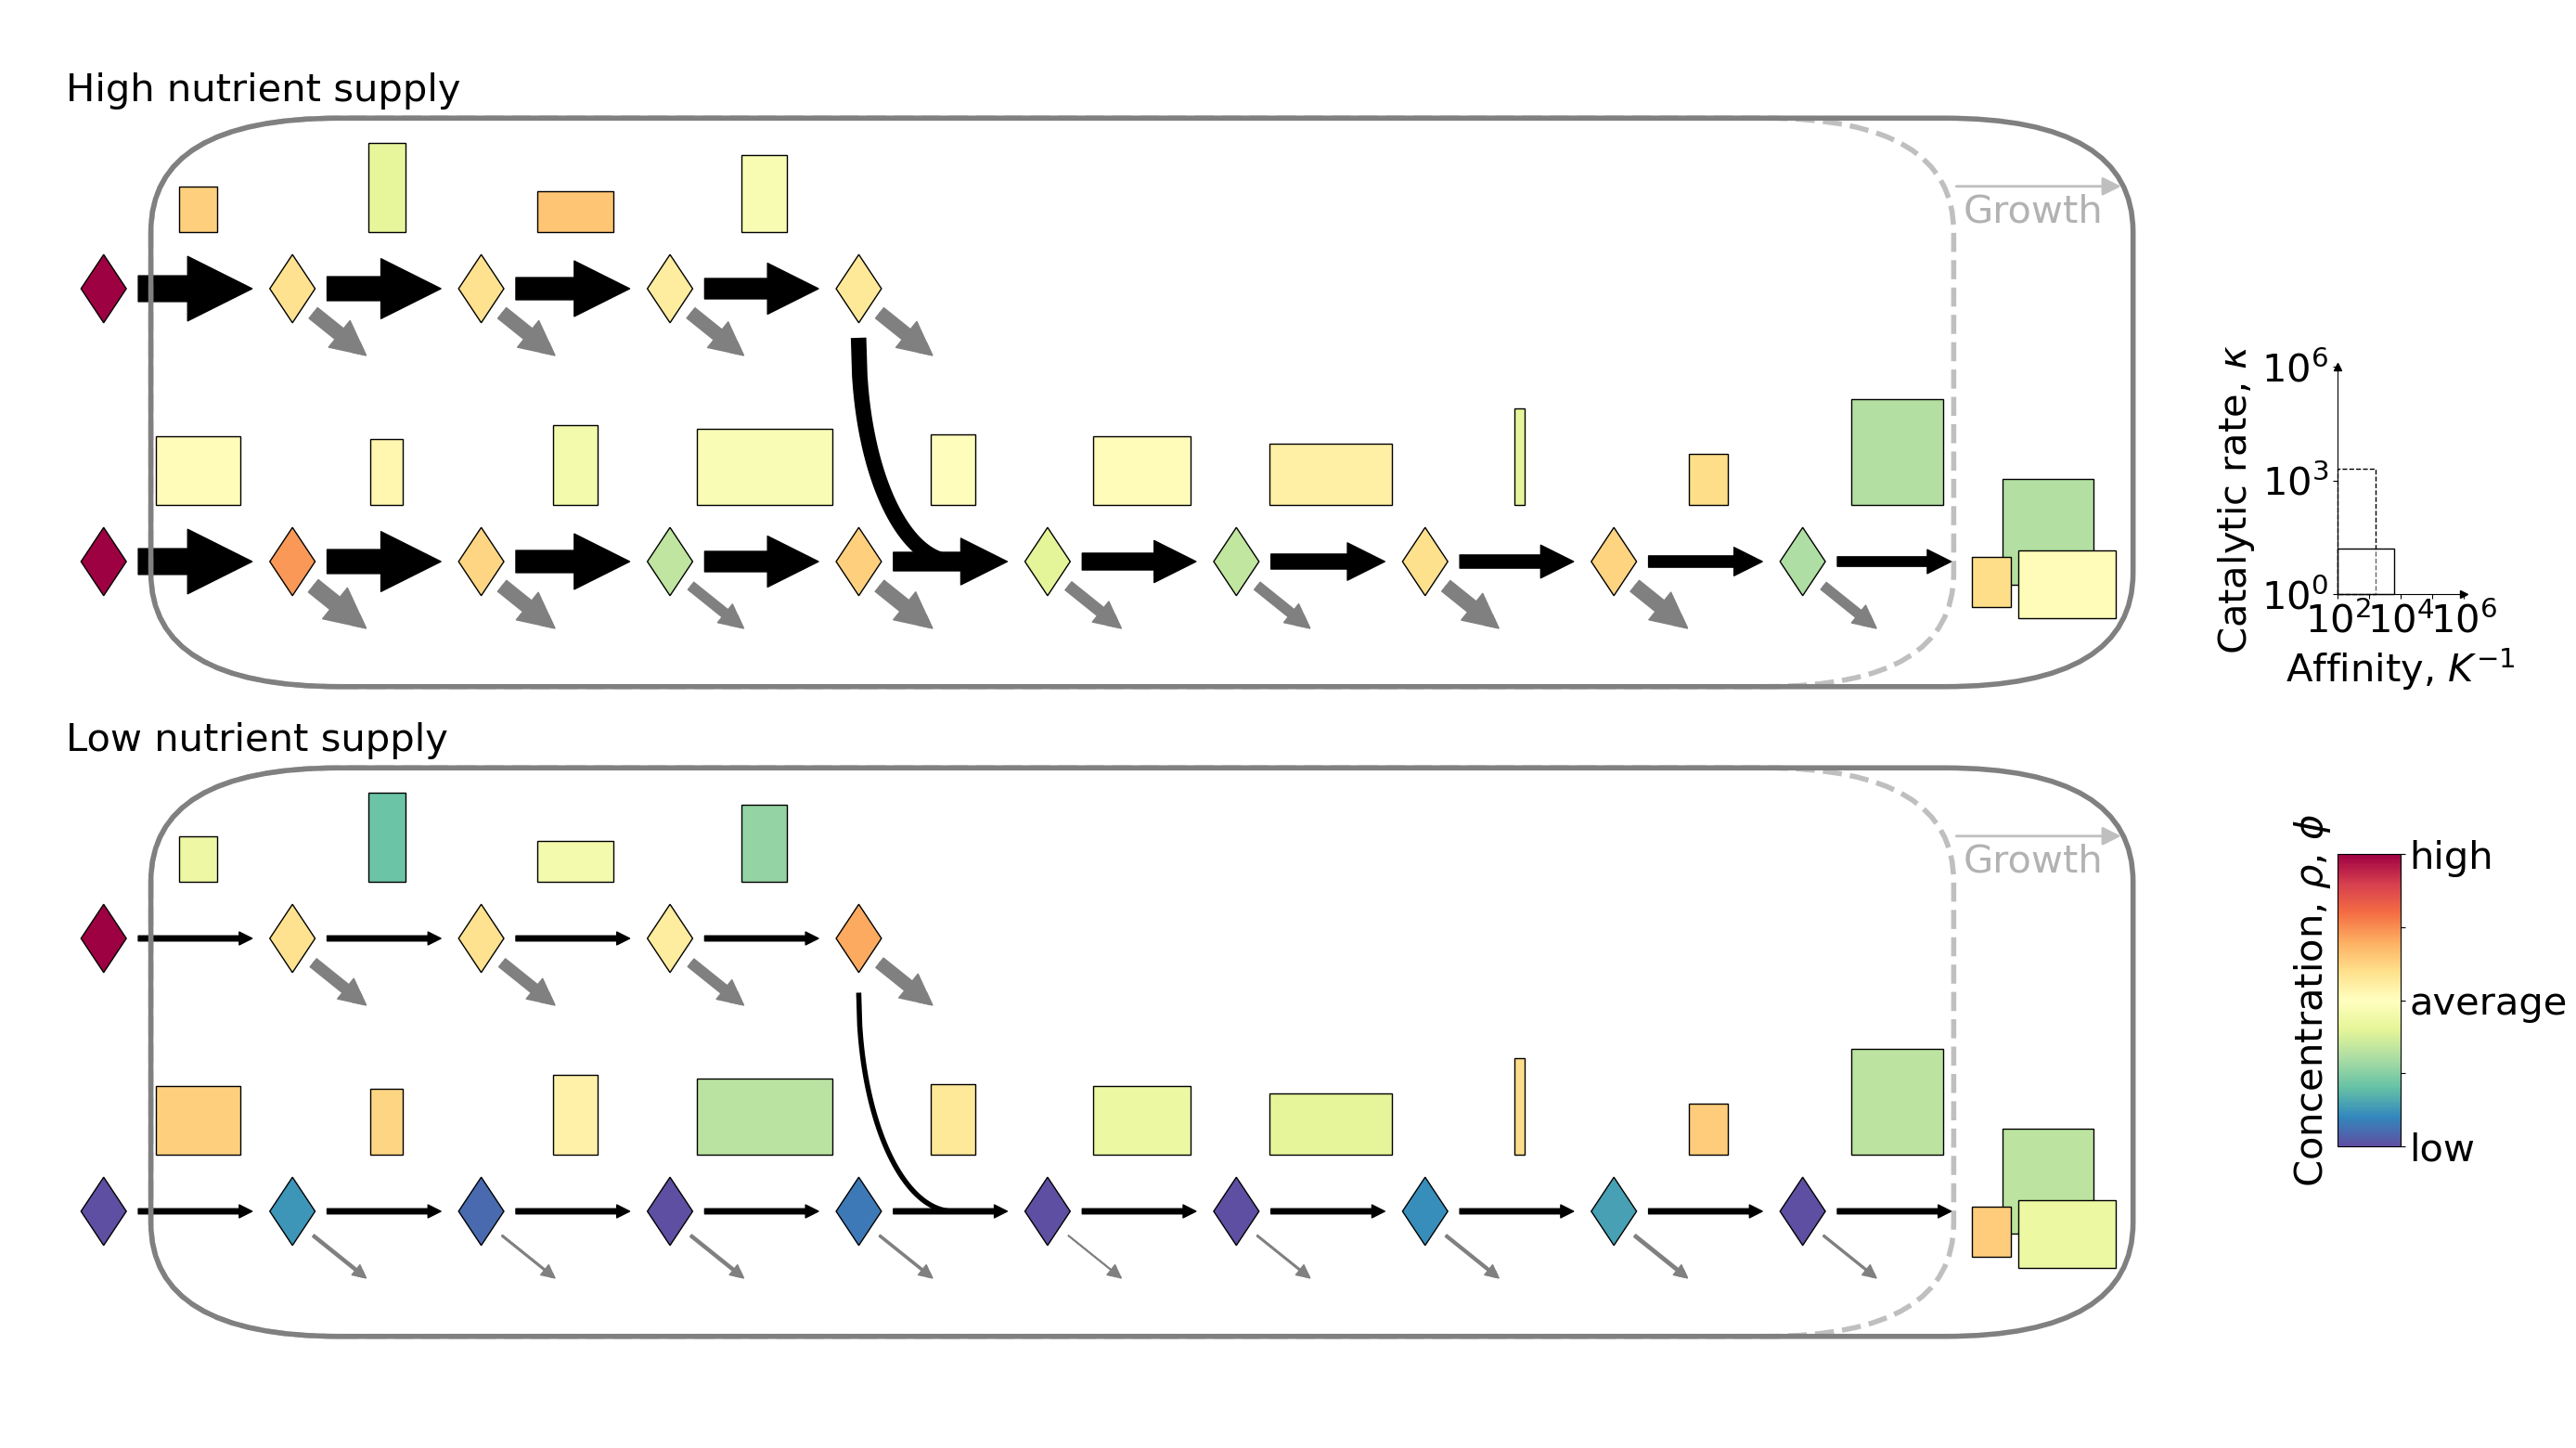

In [4]:
#### Illustrative figure 1

isample = 3#3

font = {'size'   : 30} #20
plt.rc('font', **font)

vmin = -2.5
vmax = 2.5

fig, axs = plt.subplots(5, 1, figsize = (35, 20))
for ax in axs:
    ax.axis("off")
Nenzymes = 5

gs = gridspec.GridSpec(44, 40)
gs.update(wspace=0, hspace=0)

axs[0] = plt.subplot(gs[2:22, 0:36])
axs[1] = plt.subplot(gs[11:18, -3:-1])
axs[2] = plt.subplot(gs[26:35, -3])
axs[3] = plt.subplot(gs[0, -4])
axs[4] = plt.subplot(gs[22:42, 0:36])

filename = "ConstrainedYChain_10grs_10.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"ConstrainedYChainParameters_10grs_10.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
for b in range(3):
    parameterensemble[:, :, 0, b, :] = np.repeat(parameters[:, None, b, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
    parameterensemble[:, :, 1, b, :] = np.repeat(parameters[:, None, b, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 0, 3, 1, -1])]
print(np.shape(fullensemble))

eps = np.mean(np.sum(np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 5, :]/fullensemble[:, 0, 0, :]), axis = 1))
KMmean = 10**(-4.1)

branch = 0
ilocs = []
ensemble = []
for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0, 0]
    halfgrs = (fullensemble[j, :, 5, 0, 0].T-maxgr/2.1).T
    halfgrs[halfgrs<=0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0, 0].T-maxgr/10.1).T
    tenthgrs[tenthgrs<=0] = np.max(tenthgrs)
    
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, :, ::-1]
ensemble[:, 0, 3, 2, 0] = 1e0
phiavg = np.mean(np.log10(ensemble[:, 0, 4, :, :-1]))
rhoavg = np.mean(np.log10(ensemble[:, 0, 3, :, 1:]))

for ax in [0, 4]:
    for b in [0, 1, 2]:
        heights = np.log10(ensemble[isample, 0, 0, b, :])/2/1.5
        widths = (-np.log10(ensemble[isample, 0, 1, b, :])-2)/(18*8/12)
        for j in np.arange(Nenzymes):
            if j<Nenzymes-1 or b != 1:
                axs[ax].add_patch(plt.Polygon([[j+1.5+Nenzymes*(b==0)-widths[j], 0.5+(b%2)*2.4+heights[j]], [j+1.5+Nenzymes*(b==0)-widths[j], 0.5+(b%2)*2.4], [j+1.5+Nenzymes*(b==0)+widths[j], 0.5+(b%2)*2.4], [j+1.5+Nenzymes*(b==0)+widths[j], 0.5+(b%2)*2.4+heights[j]]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 1, facecolor=cm((np.log10(ensemble[isample, int(ax/2), 4, b, j])-vmin-phiavg)/(vmax-vmin))))

            axs[ax].add_patch(plt.Polygon([[j+.88+Nenzymes*(b==0), 0+(b%2)*2.4], [j+1+Nenzymes*(b==0), 0.3+(b%2)*2.4], [j+1.12+Nenzymes*(b==0), 0+(b%2)*2.4], [j+1+Nenzymes*(b==0), -.3+(b%2)*2.4]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 1, facecolor=cm((np.log10(ensemble[isample, int(ax/2), 3, b, j])-vmin-rhoavg)/(vmax-vmin))))
            if not (b == 1 and j == Nenzymes-1):
                arrow = mpatches.FancyArrowPatch((j+1.17+Nenzymes*(b==0), 0+(b%2)*2.4), (j+1.8+Nenzymes*(b==0), 0+(b%2)*2.4), mutation_scale=100-7*(j+Nenzymes*(b==0))*(1-int(ax/4))-20*ax, color = "k")
                axs[ax].add_patch(arrow)
            
            if j<Nenzymes-1:
                arrow = mpatches.FancyArrowPatch((j+2.1+Nenzymes*(b==0), -0.2+(b%2)*2.4), (j+2.1+Nenzymes*(b==0)+0.3, -0.2-0.4+(b%2)*2.4), mutation_scale=50*(np.log10(ensemble[isample, int(ax/2), 3, b, j+1]*ensemble[isample, int(ax/2), 5, 0, -1]/ensemble[isample, 0, 5, 0, -1])/4+1.6), color = (0.5, 0.5, 0.5, 1))
                axs[ax].add_patch(arrow)
                arrow = mpatches.FancyArrowPatch((j+2.1+Nenzymes*(b==0), -0.2+(b%2)*2.4), (j+2.1+Nenzymes*(b==0)+0.3, -0.2-0.4+(b%2)*2.4), mutation_scale=1, color = (0.5, 0.5, 0.5, 1), arrowstyle='simple, head_width=10, head_length=10, tail_width=0.0')
                axs[ax].add_patch(arrow)

            if j==0 and b == 0:
                arrow = mpatches.FancyArrowPatch((j+1.1+Nenzymes*(b==0), -0.2+(b%2)*2.4), (j+1.1+Nenzymes*(b==0)+0.3, -0.2-0.4+(b%2)*2.4), mutation_scale=50*(np.log10(ensemble[isample, int(ax/2), 3, b, j]*ensemble[isample, int(ax/2), 5, 0, -1]/ensemble[isample, 0, 5, 0, -1])/4+1.6), color = (0.5, 0.5, 0.5, 1))
                axs[ax].add_patch(arrow)
                arrow = mpatches.FancyArrowPatch((j+1.1+Nenzymes*(b==0), -0.2+(b%2)*2.4), (j+1.1+Nenzymes*(b==0)+0.3, -0.2-0.4+(b%2)*2.4), mutation_scale=1, color = (0.5, 0.5, 0.5, 1), arrowstyle='simple, head_width=10, head_length=10, tail_width=0.0')
                axs[ax].add_patch(arrow)
                    
        if b == 1:
            j = int(Nenzymes)
            
    xs = np.linspace(0, 0.5, 100)
    axs[ax].plot(-xs+int(Nenzymes)+.5, 3.8*(0.5-np.sqrt(0.5**2 - xs**2)), "k-", linewidth = 12-2*ax)
    
    j = 2*Nenzymes-1
    heights = np.log10(ensemble[isample, 0, 0, 0, :])/2/1.5
    widths = (-np.log10(ensemble[isample, 0, 1, 0, :])-2)/(18*8/12)
    axs[ax].add_patch(plt.Polygon([[j+2.3-widths[4], -0.2+heights[4]], [j+2.3-widths[4], -0.2], [j+2.3+widths[4], -0.2], [j+2.3+widths[4], -0.2+heights[4]]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 1, facecolor=cm((np.log10(ensemble[isample, int(ax/2), 4, 0, 4])-vmin-phiavg)/(vmax-vmin))))
    axs[ax].add_patch(plt.Polygon([[j+2-widths[3], -0.4+heights[3]], [j+2-widths[3], -0.4], [j+2+widths[3], -0.4], [j+2+widths[3], -0.4+heights[3]]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 1, facecolor=cm((np.log10(ensemble[isample, int(ax/2), 4, 0, 3])-vmin-phiavg)/(vmax-vmin))))
    axs[ax].add_patch(plt.Polygon([[j+2.4-widths[0], -0.5+heights[0]], [j+2.4-widths[0], -0.5], [j+2.4+widths[0], -0.5], [j+2.4+widths[0], -0.5+heights[0]]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 1, facecolor=cm((np.log10(ensemble[isample, int(ax/2), 4, 0, 0])-vmin-phiavg)/(vmax-vmin))))

    axs[ax].annotate("", xy = (2*Nenzymes+1.7, 0.9+2.4), xytext = (2*Nenzymes+0.8, 0.9+2.4), arrowprops=dict(arrowstyle="-|>", color=(0.75, 0.75, 0.75, 1), linewidth = 2, linestyle = "-"))
    axs[ax].text(2*Nenzymes+0.85, 1+1.98, "Growth", alpha = 0.3)
    
    axs[ax].axis("off")
    axs[ax].set_xlim(0.5, 2*Nenzymes+2+0.5)
    axs[ax].set_ylim(-3/2.1, 3/2.1*3)
    fig.tight_layout()

    patch = mpatches.FancyBboxPatch(xy=(1.55, -0.8),
                                    width=9.9,
                                    height=4.4,
                                    boxstyle=mpatches.BoxStyle.Round(pad=0.3, rounding_size=2/2),
                                    #bbox_transmuter=None,
                                    mutation_scale=1.0,
                                    mutation_aspect=None,
                                    # COMMON OPTIONS:
                                    ec = (0.5, 0.5, 0.5, 1),
                                    facecolor=(0, 0, 0, 0),
                                    linewidth = 4)

    patch2 = mpatches.FancyBboxPatch(xy=(1.55, -0.8),
                                    width=8.95,
                                    height=4.4,
                                    boxstyle=mpatches.BoxStyle.Round(pad=0.3, rounding_size=2/2),
                                    #bbox_transmuter=None,
                                    mutation_scale=1.0,
                                    mutation_aspect=None,
                                    # COMMON OPTIONS:
                                    ec = (0.5, 0.5, 0.5, .5),
                                    facecolor=(0, 0, 0, 0),
                                    linestyle= "--",
                                    linewidth = 4)
    axs[ax].add_patch(patch)
    axs[ax].add_patch(patch2)  

x = np.logspace(vmin, vmax, 10)
y = np.zeros(5)
xx, yy = np.meshgrid(x, y)
heatmap = axs[3].pcolormesh(xx, cmap = cm, vmin = -4, vmax = 0)
axs[3].remove()

if True:
    axins = axs[2]
    cb = fig.colorbar(heatmap, orientation='vertical', cax=axins)#, label = r"Low          High")
    axins.set_yticks([-4, -3, -2, -1, 0])
    axins.set_yticklabels([r"low", "", r"average", "", r"high"])
    axins.set_ylabel(r"Concentration, $\rho$, $\phi$")
    axins.yaxis.set_label_position("left")
       

    axins3 = axs[1]
    axins3.spines["left"].set_position(("data", 0))
    axins3.spines["bottom"].set_position(("data", 0))
    axins3.spines["top"].set_visible(False)
    axins3.spines["right"].set_visible(False)
    axins3.plot(1, 0, ">k", transform=axins3.get_yaxis_transform(), clip_on=False)
    axins3.plot(0, 1, "^k", transform=axins3.get_xaxis_transform(), clip_on=False)
    axins3.set_xlabel(r"Affinity, $K^{-1}$")
    axins3.set_xlim(0, 4)
    axins3.set_xticks([0, 1, 2, 3, 4])
    axins3.set_xticklabels([r"$10^2$", "", r"$10^4$", "", r"$10^6$"])
    axins3.set_ylabel(r"Catalytic rate, $\kappa$    ")
    axins3.set_ylim(0, 4)
    axins3.set_yticks([0, 2, 4])
    axins3.set_yticklabels([r"$10^0$", r"$10^3$", r"$10^6$"])
    axins3.add_patch(plt.Polygon([[0, 0], [0, 2.2], [1.2, 2.2], [1.2, 0]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 1, facecolor=(0, 0, 0, 0), linestyle = "--"))
    axins3.add_patch(plt.Polygon([[0, 0], [0, 0.8], [1.8, 0.8], [1.8, 0]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 1, facecolor=(1, 1, 1, .4)))

axs[0].text(0.8, 4.05, "High nutrient supply")
axs[4].text(0.8, 4.05, "Low nutrient supply")
fig.tight_layout()

#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/MainText1_branched.pdf", bbox_inches="tight", format = 'pdf')

In [5]:
### data import and reshaping into an array of structure

filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"
Nenzymes = 20
fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print("Initial data structure: ", np.shape(fullensemble), np.shape(parameters))


parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]


meancolors = ["k", "dimgrey"]

KMmean = np.exp(np.mean(np.log(fullensemble[:, 0, 1, :])))

efficiencybins = np.logspace(-2.2 , 2.2, 12)#np.logspace(-1, 1, 6)
efficiencybins2 = np.copy(efficiencybins)
ilocs = []
ensemble = []

for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 4, 0]/fullensemble[j, :, 1, 0]/(fullensemble[j, :, 3, 0]/fullensemble[j, :, 1, 0])/(1+fullensemble[j, :, 3, 0]/fullensemble[j, :, 1, 0]).T-40).T
    #halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/2).T
    halfgrs[halfgrs<=0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    tenthgrs[tenthgrs<=0] = np.max(tenthgrs)
    
    #iloc = np.where(np.abs(fullensemble[j, :, 5, 0]-maxgr/2)==np.min(np.abs(fullensemble[j, :, 5, 0]-maxgr/2)))
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, :]

print("final data structure: ", np.shape(ensemble))

print("Ensemble structure: (parameterization, growth limitation, state variable, branch, enzyme position)")
print("")
print("There are 5000 parameterizations")
print("... a variable number of degrees of growth limitation, here from a thousand 3 are selected with equal relative growth rates across parameterizations")
print("... six state variables in index-order kappamax, Km, b {legacy parameter, always 1}, rhos, phis, js")
print("... up to three branches, here 1")
print("... of 10 or 20 enzymes each, here 20.")

Initial data structure:  (5000, 1000, 3, 20) (5000, 42)
final data structure:  (5000, 3, 6, 1, 20)
Ensemble structure: (parameterization, growth limitation, state variable, branch, enzyme position)

There are 5000 parameterizations
... a variable number of degrees of growth limitation, here from a thousand 3 are selected with equal relative growth rates across parameterizations
... six state variables in index-order kappamax, Km, b {legacy parameter, always 1}, rhos, phis, js
... up to three branches, here 1
... of 10 or 20 enzymes each, here 20.


(5000, 19)


Text(0.3, 0.11, '$q = 10^2$')

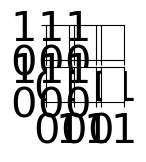

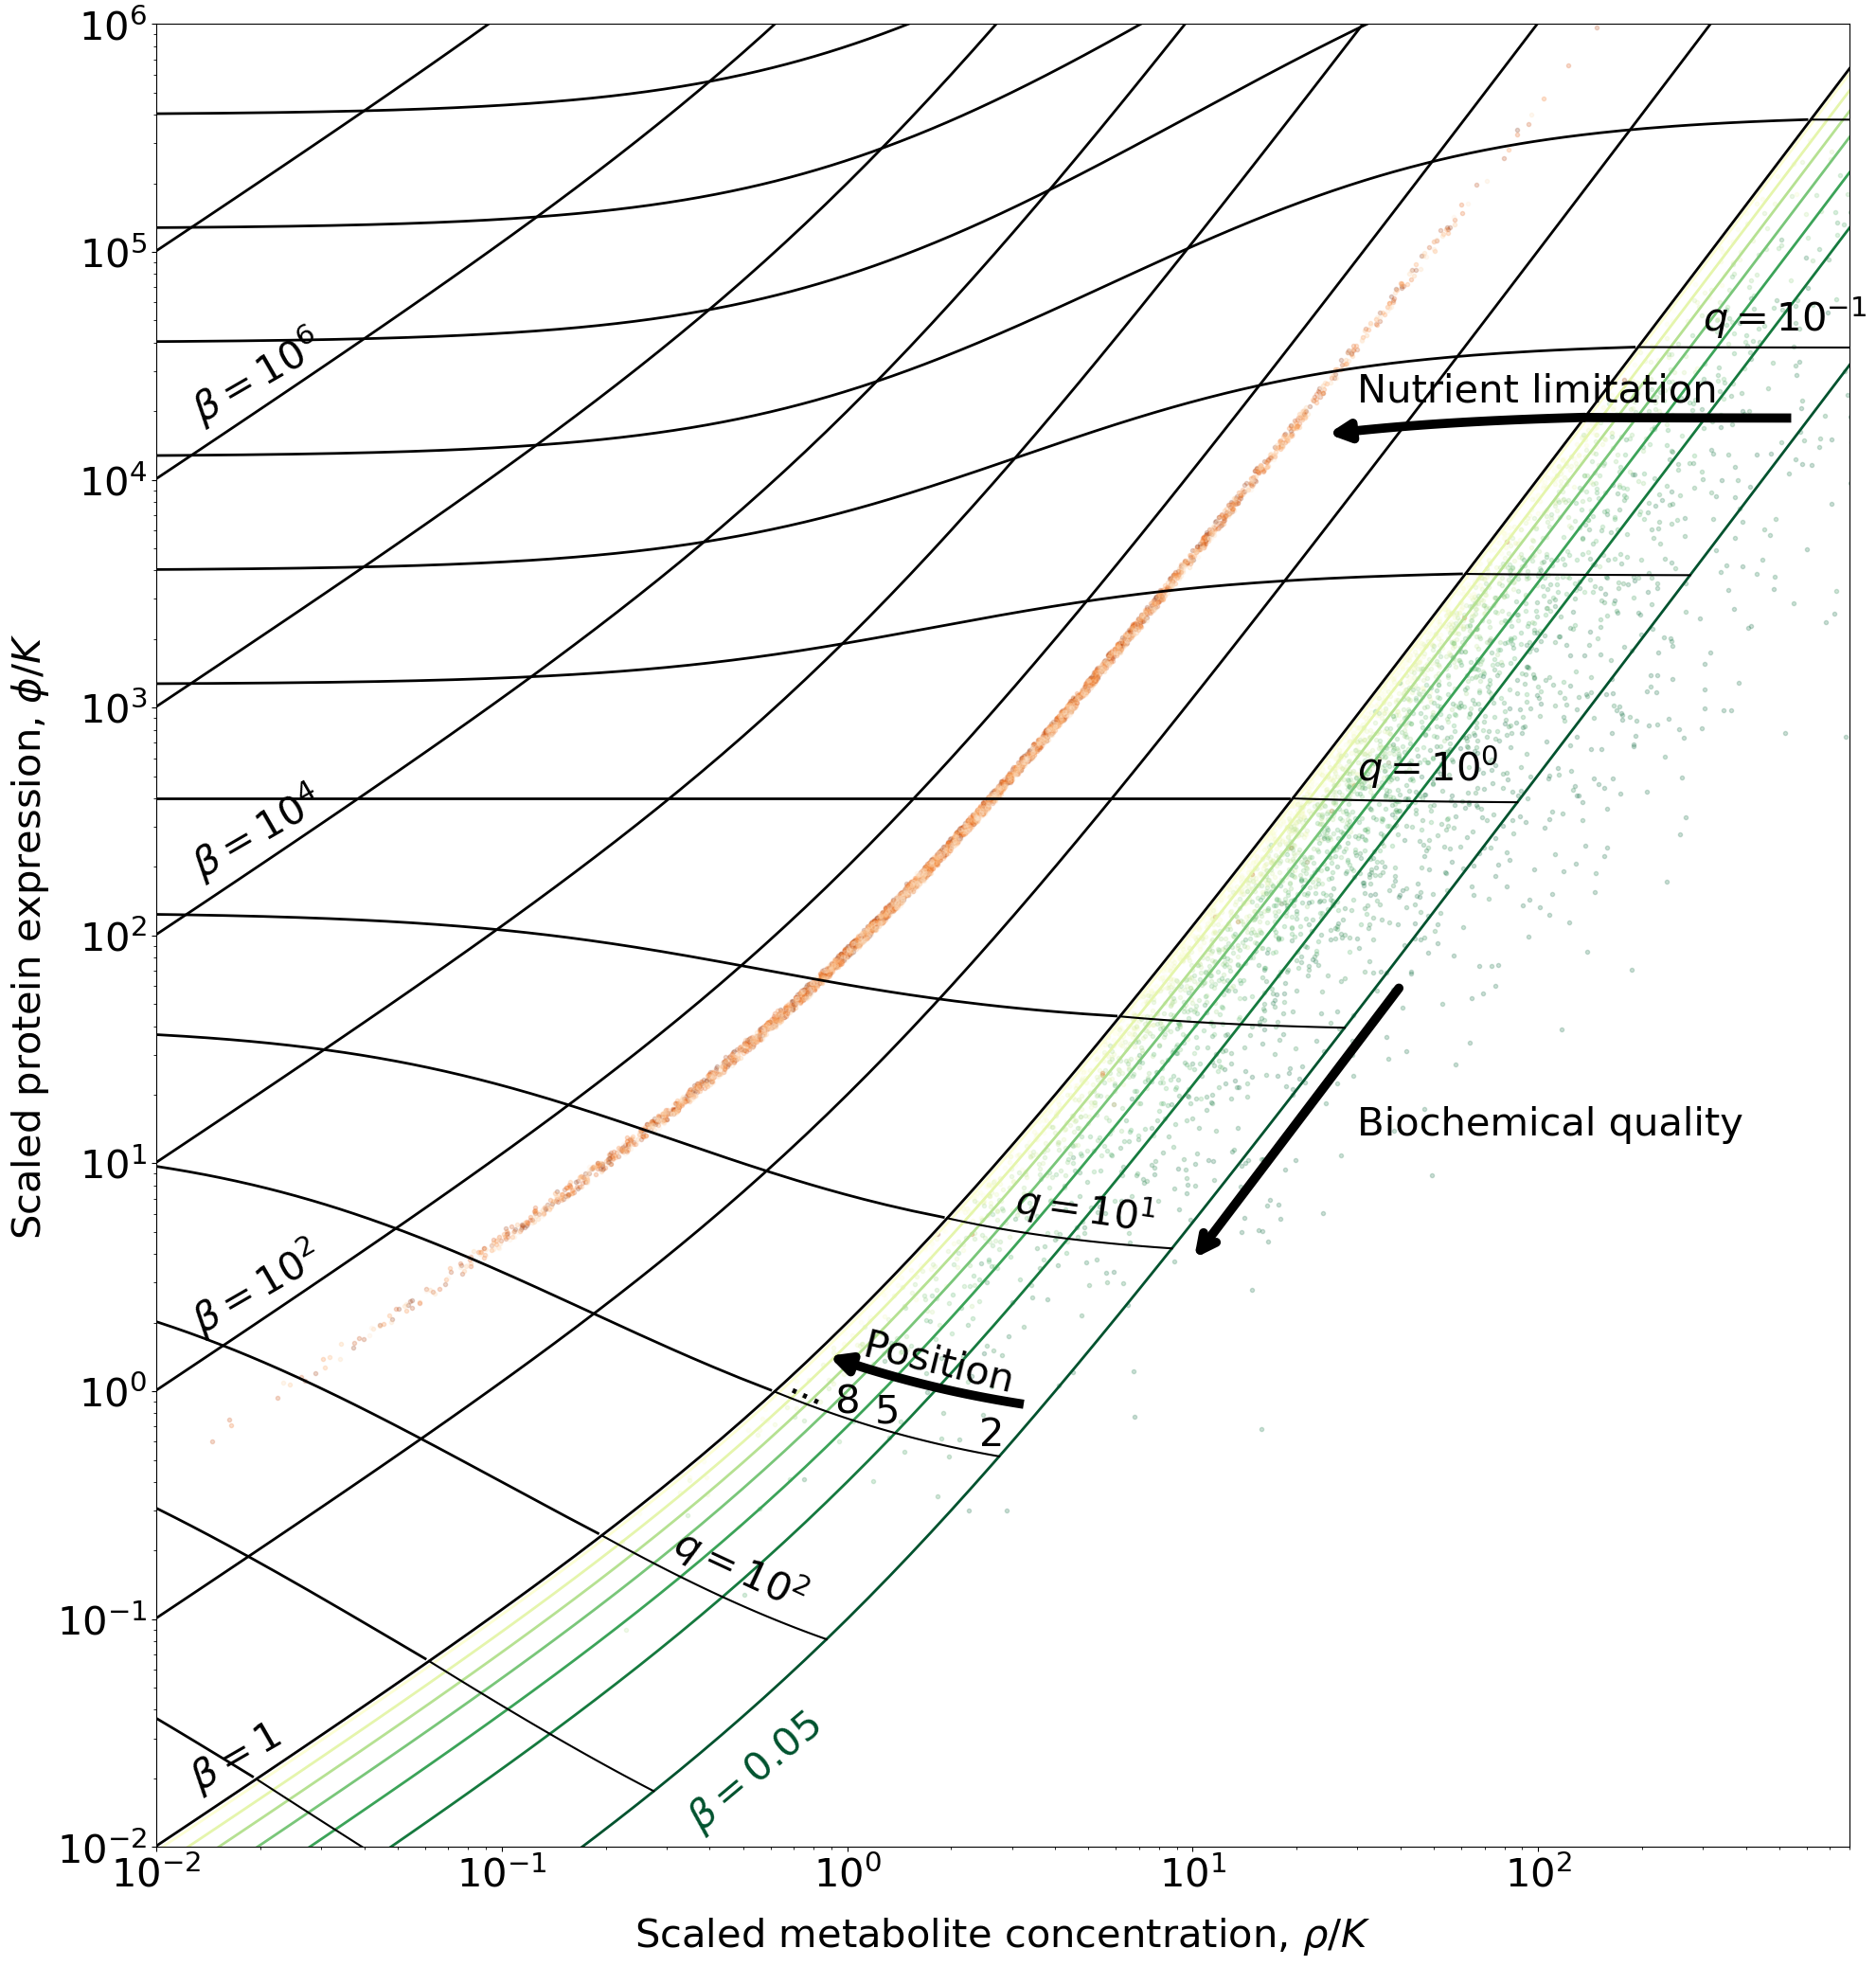

In [6]:
### Figure 2

eps = 0.05


font = {'size'   : 30} #20
plt.rc('font', **font)
cmplasma = plt.cm.get_cmap('plasma')
cmInferno = plt.cm.get_cmap('Oranges')
cmYlGn = plt.cm.get_cmap('YlGn_r')
fig, axs = plt.subplots(2, 3, figsize = (1, 1))
fig = plt.figure(figsize = (25, 25))
gs = gridspec.GridSpec(4, 13)
gs.update(wspace=0, hspace=0)

axs[0, 0] = plt.subplot(gs[:, :12])
#axs[0, 2] = plt.subplot(gs[0:3, 9:12])

ax0 = axs[0, 0]
Nenzymes = 20
for i in range(Nenzymes-1):
    for q in range(np.shape(ensemble)[0])[:200]: #display only a subset of points to ensure individual visibility
        ax0.scatter(ensemble[q, 0, 3, 0, i]/ensemble[q, 0, 1, 0, i], ensemble[q, 0, 4, 0, i]/ensemble[q, 0, 1, 0, i], marker = ".", color = cmYlGn((Nenzymes-i)/Nenzymes), alpha = 0.2)  
        #print("")
        #ax0.scatter(ensemble[q, 1, 3, 0, i]/ensemble[q, 1, 1, 0, i], ensemble[q, 1, 4, 0, i]/ensemble[q, 1, 1, 0, i], marker = ".", color = cmInferno((Nenzymes-i)/Nenzymes), alpha = 0.2) 
        ax0.scatter(ensemble[q, 1, 3, 0, i]/ensemble[q, 0, 1, 0, i], ensemble[q, 1, 4, 0, i]/ensemble[q, 0, 1, 0, i], marker = ".", color = cmInferno((Nenzymes-i)/Nenzymes), alpha = 0.2)
#ax0.scatter(ensemble[q, 0, 3, 0, 10:-1]/ensemble[q, 0, 1, 0, 10:-1], ensemble[q, 0, 4, 0, 10:-1]/ensemble[q, 0, 1, 0, 10:-1], marker = ".", color = cmplasma(15/20), alpha = 0.4, label = r"Catabolism, $i<\ell/2$")   
#ax0.scatter(ensemble[q, 0, 3, 0, :10]/ensemble[q, 0, 1, 0, :10], ensemble[q, 0, 4, 0, :10]/ensemble[q, 0, 1, 0, :10], marker = ".", color = cmplasma(5/20), alpha = 0.4, label = r"Anabolism, $i>\ell/2$")   

#lgnd = ax0.legend(handletextpad=-0.2, loc = "upper left")
#lgnd.legendHandles[0]._sizes = [100]
#lgnd.legendHandles[1]._sizes = [100]
ax0.set_xlim(1e-2, 8e2)
ax0.set_ylim(1e-2, 1e6)
ax0.set_ylabel(r"Scaled protein expression, $\phi/K$")
ax0.set_xlabel(r"Scaled metabolite concentration, $\rho/K$", labelpad = 15)
ax0.set_yscale("log")
ax0.set_xscale("log")
#ax0.plot(np.logspace(-2, 4, 100), np.logspace(-2, 4, 100)*(1+np.logspace(-2, 4, 100)), "k-", linewidth = 2)
#ax0.plot(np.logspace(-2, 4, 100), 0.1*np.logspace(-2, 4, 100)*(1+np.logspace(-2, 4, 100)), "--", color = cmplasma(5/20), linewidth = 2)

betas = ensemble[:, 0, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1]/(ensemble[:, 0, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])/(1+ensemble[:, 0, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])
print(np.shape(betas))

for i in [2, 5, 8, 11, 14, 17, 20]:
    axs[0, 0].plot(np.logspace(-2, 4, 100), (i-1)/20*np.logspace(-2, 4, 100)*(1+np.logspace(-2, 4, 100)), color = cmYlGn(((i-1))/Nenzymes), linewidth = 2)
   
for beta in np.logspace(0, 7, 8):
    axs[0, 0].plot(np.logspace(-2, 4, 100), beta*np.logspace(-2, 4, 100)*(1+np.logspace(-2, 4, 100)), color = "k", linewidth = 2)
    
allbetas = np.logspace(-np.log10(Nenzymes), 0, 100)
for rhorichOverKM in 1/eps*np.logspace(-3, 3, 13):
    rhoOverKM = rhorichOverKM*np.sqrt(1/allbetas)*np.sqrt(1-eps)
    axs[0, 0].plot(rhoOverKM, allbetas*rhoOverKM*(rhoOverKM+1), "k-")
    
alllambdas = np.logspace(-5, np.log10(1-eps), 1000)
for rhorichOverKM in 1/eps*np.logspace(-3, 3, 13):
    allbetas = ((1-alllambdas)/(np.sqrt(alllambdas)*eps))**2
    rhoOverKM = rhorichOverKM*np.sqrt(1/allbetas)*np.sqrt(alllambdas)
    axs[0, 0].plot(rhoOverKM, allbetas*rhoOverKM*(rhoOverKM+1), "k-", linewidth = 2)
    

allbetas = np.logspace(-np.log10(Nenzymes), 0, 100)
rhorichOverKM = 1/eps*4.2e-2
rhoOverKM = rhorichOverKM*np.sqrt(1/allbetas)*np.sqrt(1-eps)
axs[0, 0].plot(rhoOverKM[10:-15], (allbetas*rhoOverKM*(rhoOverKM+1))[10:-15], "k-", linewidth = 7)
axs[0, 0].annotate('', xy=(rhoOverKM[-5], (allbetas*rhoOverKM*(rhoOverKM+1))[-5]), xytext=(rhoOverKM[-15], (allbetas*rhoOverKM*(rhoOverKM+1))[-15]), arrowprops=dict(arrowstyle="-|>", color='k', linewidth = 7, linestyle = "-"))
axs[0, 0].text(1, 1, " Position", rotation = -14)


rhorichOverKM = 1/eps*7
rhoOverKM = rhorichOverKM*np.sqrt(1/allbetas)*np.sqrt(1-eps)
axs[0, 0].plot(rhoOverKM[10:], (allbetas*rhoOverKM*(rhoOverKM+1))[10:], "k-", linewidth = 7)

alllambdas = np.logspace(-.2, np.log10(1-eps), 100)
rhorichOverKM = 1/eps*7
allbetas = ((1-alllambdas)/(np.sqrt(alllambdas)*eps))**2
rhoOverKM = rhorichOverKM*np.sqrt(1/allbetas)*np.sqrt(alllambdas)
axs[0, 0].plot(rhoOverKM[60:], (allbetas*rhoOverKM*(rhoOverKM+1))[60:], "k-", linewidth = 7)
axs[0, 0].annotate('', xy=(rhoOverKM[50], (allbetas*rhoOverKM*(rhoOverKM+1))[50]), xytext=(rhoOverKM[60], (allbetas*rhoOverKM*(rhoOverKM+1))[60]), arrowprops=dict(arrowstyle="-|>", color='k', linewidth = 7, linestyle = "-"))
axs[0, 0].text(30, 2.2e4, r"Nutrient limitation")

axs[0, 0].annotate('', xy=(10, 15/4), xytext=(40, 60), arrowprops=dict(arrowstyle="->", color='k', linewidth = 7, linestyle = "-"))
axs[0, 0].text(90/3, 120/9, "Biochemical quality")

axs[0, 0].text(0.012, 0.018, r"$\beta = 1$", rotation = 30, color = "k", size = 30)#color=cmplasma(18/20))
axs[0, 0].text(0.012, 1.8, r"$\beta = 10^2$", rotation = 30, color = "k", size = 30)#color=cmplasma(18/20))
axs[0, 0].text(0.012, 180, r"$\beta = 10^4$", rotation = 30, color = "k", size = 30)#color=cmplasma(18/20))
axs[0, 0].text(0.012, 18000, r"$\beta = 10^6$", rotation = 30, color = "k", size = 30)#color=cmplasma(18/20))
axs[0, 0].text(0.33, 0.012, r"$\beta = 0.05$", rotation = 40, size = 30, color=cmYlGn(1/20))

#2, 5, 8, 11, 14, 17, 20
axs[0, 0].text(2.4, 0.58, r"$2$", rotation = 0, color = "k", size = 30)#color=cmplasma(18/20))
axs[0, 0].text(1.2, 0.73, r"$5$", rotation = 0, color = "k", size = 30)#color=cmplasma(18/20))
axs[0, 0].text(0.92, 0.81, r"$8$", rotation = 0, color = "k", size = 30)#color=cmplasma(18/20))
axs[0, 0].text(0.65, 0.86, r"...", rotation = -25, color = "k", size = 30)#color=cmplasma(18/20))

axs[0, 0].text(3e2, 4.5e4, r"$q = 10^{-1}$", rotation = 0, color = "k", size = 30)#color=cmplasma(18/20))
axs[0, 0].text(3e1, 4.8e2, r"$q = 10^0$", rotation = 0, color = "k", size = 30)#color=cmplasma(18/20))
axs[0, 0].text(3e0, 5, r"$q = 10^1$", rotation = -8, color = "k", size = 30)#color=cmplasma(18/20))
axs[0, 0].text(3e-1, 1.1e-1, r"$q = 10^2$", rotation = -25, color = "k", size = 30)

#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/MainTextMaster.pdf", bbox_inches="tight", format = 'pdf')

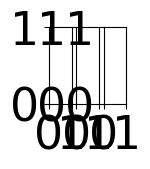

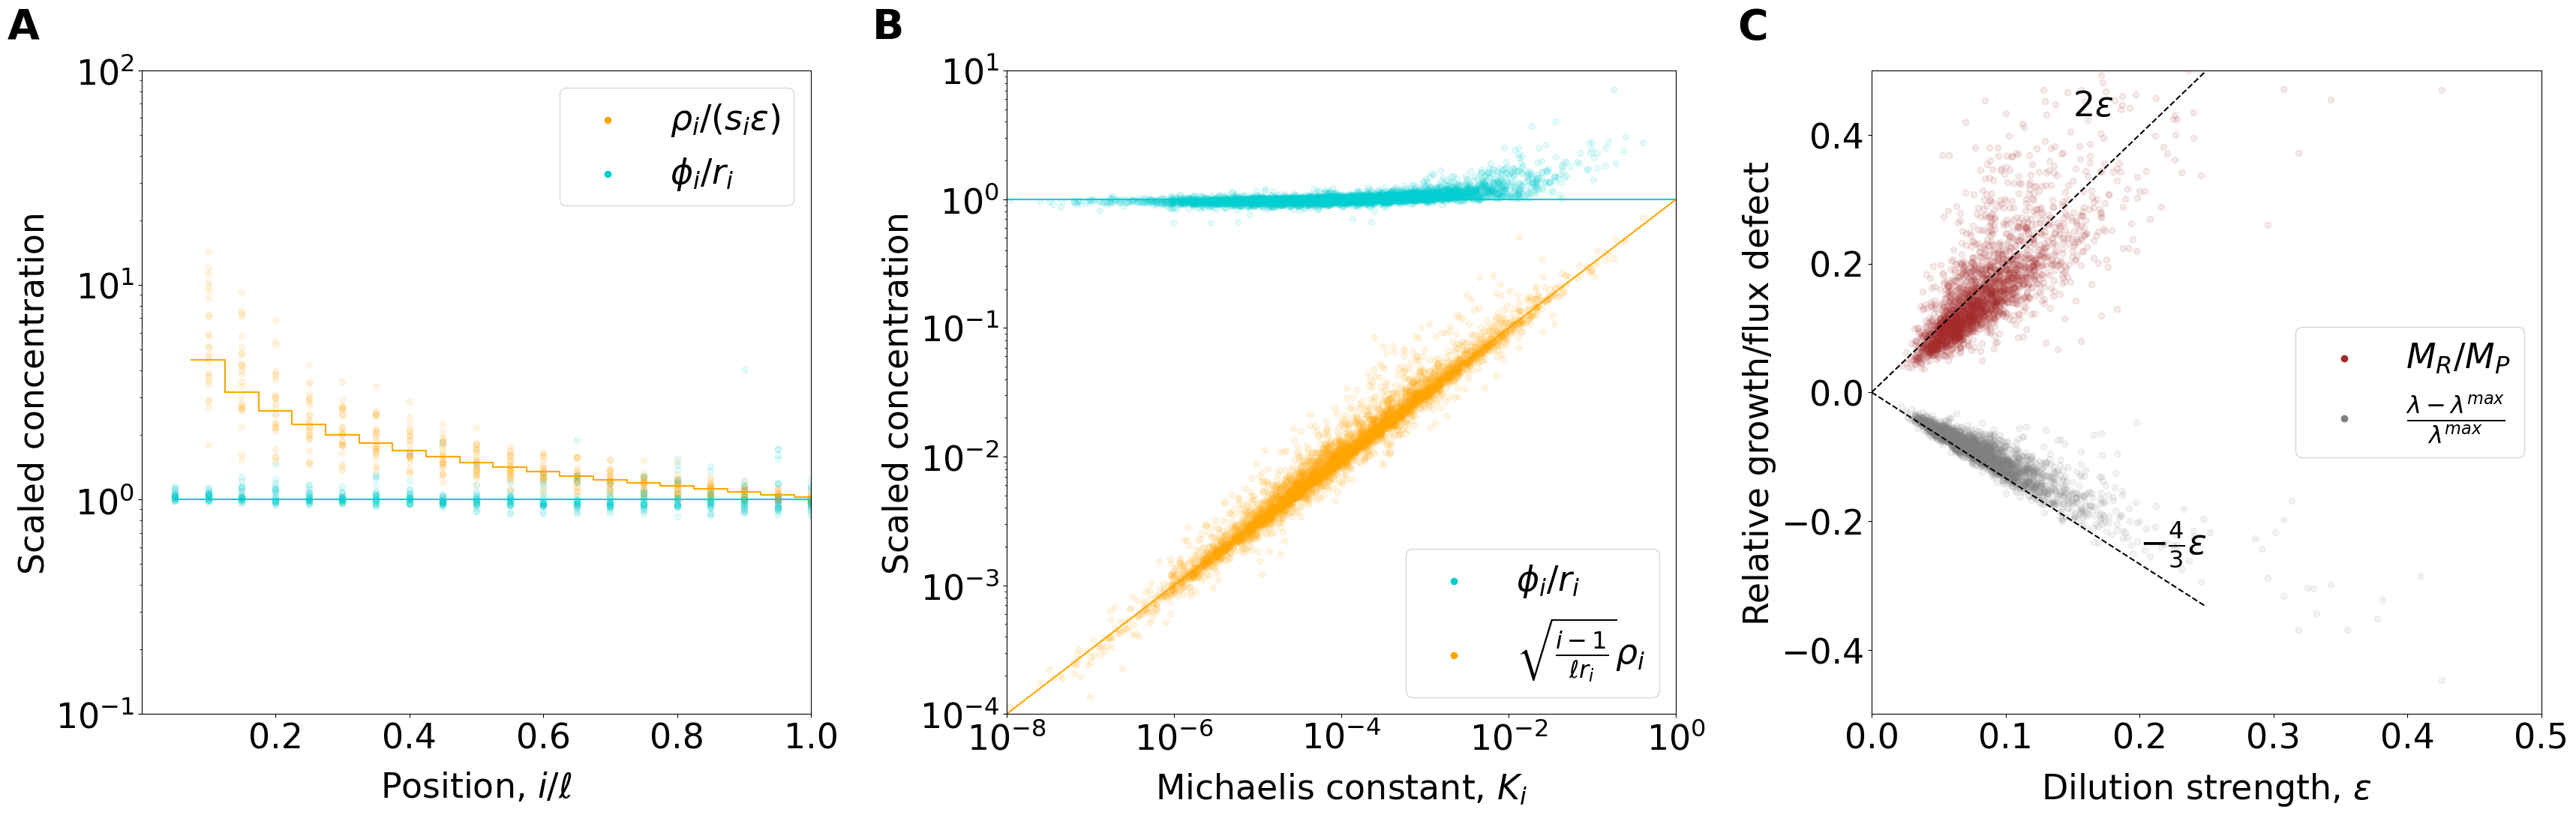

In [7]:
### Figure 3

epsilons = np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), axis = 1)/np.sqrt(np.sum(1/fullensemble[:, 0, 0, :], axis = 1))
lammax = 1/np.sum(1/fullensemble[:, 0, 0, :], axis = 1)

font = {'size'   : 33} #20
plt.rc('font', **font)

fig, axs = plt.subplots(1, 3, figsize = (1, 1))
fig = plt.figure(figsize = (35, 11))
gs = gridspec.GridSpec(1, 3)
#gs.update(wspace=0.2, hspace=0.2)

axs[0] = plt.subplot(gs[0, 0])
axs[1] = plt.subplot(gs[0, 1])
#ax00 = axs[0].twinx()
#ax01 = axs[1].twinx()
axs[2] = plt.subplot(gs[0, 2])

positions = np.arange(20)[::-1]+1
newaxis = np.zeros(np.shape(fullensemble)[0])
pos, axis = np.meshgrid(positions, newaxis)
si = ((np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]).T)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), axis = 1)).T
ri = (1/fullensemble[:, 0, 0, :].T/np.sum(1/fullensemble[:, 0, 0, :], axis = 1)).T
qi = (np.sqrt(fullensemble[:, 0, 0, :]*fullensemble[:, 0, 1, :]).T/(epsilons*np.sqrt(lammax))).T
#betai = fullensemble[:, 0, 4, :]/fullensemble[:, 0, 3, :]/(1+fullensemble[:, 0, 3, :]/fullensemble[:, 0, 1, :])
betai = np.arange(Nenzymes)[::-1]/Nenzymes
scaledrhos = ((fullensemble[:, 0, 3, :]/si).T/epsilons).T
scaledphis = fullensemble[:, 0, 4, :]/ri


axs[0].scatter(pos[::200, :]/Nenzymes, scaledrhos[::200], alpha = 0.1, color = "orange", label = r"$\rho_i/(s_i \epsilon)$")
axs[0].step(positions/Nenzymes, np.sqrt(Nenzymes/(positions-1)), color = "orange", where = "mid")
axs[0].scatter(pos[::200, :]/Nenzymes, scaledphis[::200], alpha = 0.1, color = "darkturquoise", label = r"$\phi_i/r_i$")
axs[0].step(positions/Nenzymes, 1+0*positions, color = "darkturquoise", where = "mid")
axs[0].set_xlim(0, 1)
axs[0].set_yscale("log")
axs[0].set_xlabel("Position, $i/\ell$", labelpad=15)
axs[0].set_ylabel("Scaled concentration")
axs[0].set_xticks([0.2, 0.4, 0.6, 0.8, 1])
axs[0].set_ylim(1e-1, 1e2)
axs[0].set_yticks([1e-1, 1e0, 1e1, 1e2])
leg = axs[0].legend(loc = "upper right")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

    
axs[1].scatter(fullensemble[::20, 0, 1, :], fullensemble[::20, 0, 4, :]/ri[::20], alpha = 0.1, color = "darkturquoise", label = r"$\phi_i/r_i$")
axs[1].plot(np.logspace(-10, 0, 10), np.logspace(-10, 0, 10)**0, color = "darkturquoise")
    
#axs[0, 1].scatter((epsilons*qi.T).T, np.sqrt(betai)*fullensemble[:, 0, 3, :]/fullensemble[:, 0, 1, :], alpha = 0.01, color = "orange")
#axs[1].scatter((epsilons*si.T).T, np.sqrt(betai)*fullensemble[:, 0, 3, :], alpha = 0.01, color = "orange")
axs[1].scatter(fullensemble[::20, 0, 1, :], np.sqrt(betai/ri)[::20]*fullensemble[::20, 0, 3, :], alpha = 0.1, color = "orange", label = r"$\sqrt{\frac{i-1}{\ell r_i}}\rho_i$")
axs[1].plot(np.logspace(-10, 0, 10), np.sqrt(np.logspace(-10, 0, 10)), color = "orange")
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlim(1e-8, 1e0)
axs[1].set_xlabel(r"Michaelis constant, $K_i$", labelpad=15)
axs[1].set_ylabel("Scaled concentration")
#axs[1].set_ylabel(r"$\sqrt{\frac{i-1}{\ell r_i}}\rho_i$")
axs[1].set_ylim(1e-4, 1e1)


leg = axs[1].legend(loc = "lower right")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

axs[2].scatter(epsilons[::2], np.sum(fullensemble[::2, 0, 3, :-1], 1), alpha = 0.1, color = "brown", label = r"$M_R/M_P$")
axs[2].plot(np.linspace(0, 0.25, 10), 2*np.linspace(0, 0.25, 10), "k--")
axs[2].text(0.15, 0.43, r"$2\epsilon$", color = "k")

axs[2].scatter(epsilons[::2], fullensemble[::2, 0, 5, 0]*np.sum(1/fullensemble[::2, 0, 0, :], 1)-1, alpha = 0.1, color = "grey", label = r"$\frac{\lambda-\lambda^{max}}{\lambda^{max}}$")
axs[2].plot(np.linspace(0, 0.25, 10), -4/3*np.linspace(0, 0.25, 10), "k--")
axs[2].set_xlim(0, 0.5)
axs[2].set_ylim(-0.5, 0.5)
axs[2].set_xlabel(r"Dilution strength, $\epsilon$", labelpad=15)
axs[2].set_ylabel("Relative growth/flux defect")
axs[2].text(0.2, -0.25, r"$-\frac{4}{3}\epsilon$", color = "k")
#ax03 = axs[2].twinx()

leg = axs[2].legend(loc = "center right")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

#ax03.set_xscale("log")
#ax03.set_yscale("log")
fig.tight_layout()

for n, ax in enumerate(axs.flatten()):  
    ax.text(-0.2, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold', size = 40)

#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/MainTextMarginals.pdf", bbox_inches="tight", format = 'pdf')

(5000, 42)
(5000, 1000, 3, 20)
(5000, 1000, 6, 20)
(5000, 1000, 6, 1, 20)
(5000, 1, 20)
283
0.04154519323813769 0.2135426010252803
[3.1475596  3.11584849 2.98785201 2.83196947 2.20328718 1.57569244
 0.94427968 0.31475702 0.15737787 0.03147569]
(5000, 3, 6, 3, 10)
(5000, 3, 10)
0


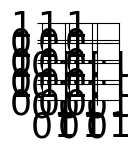

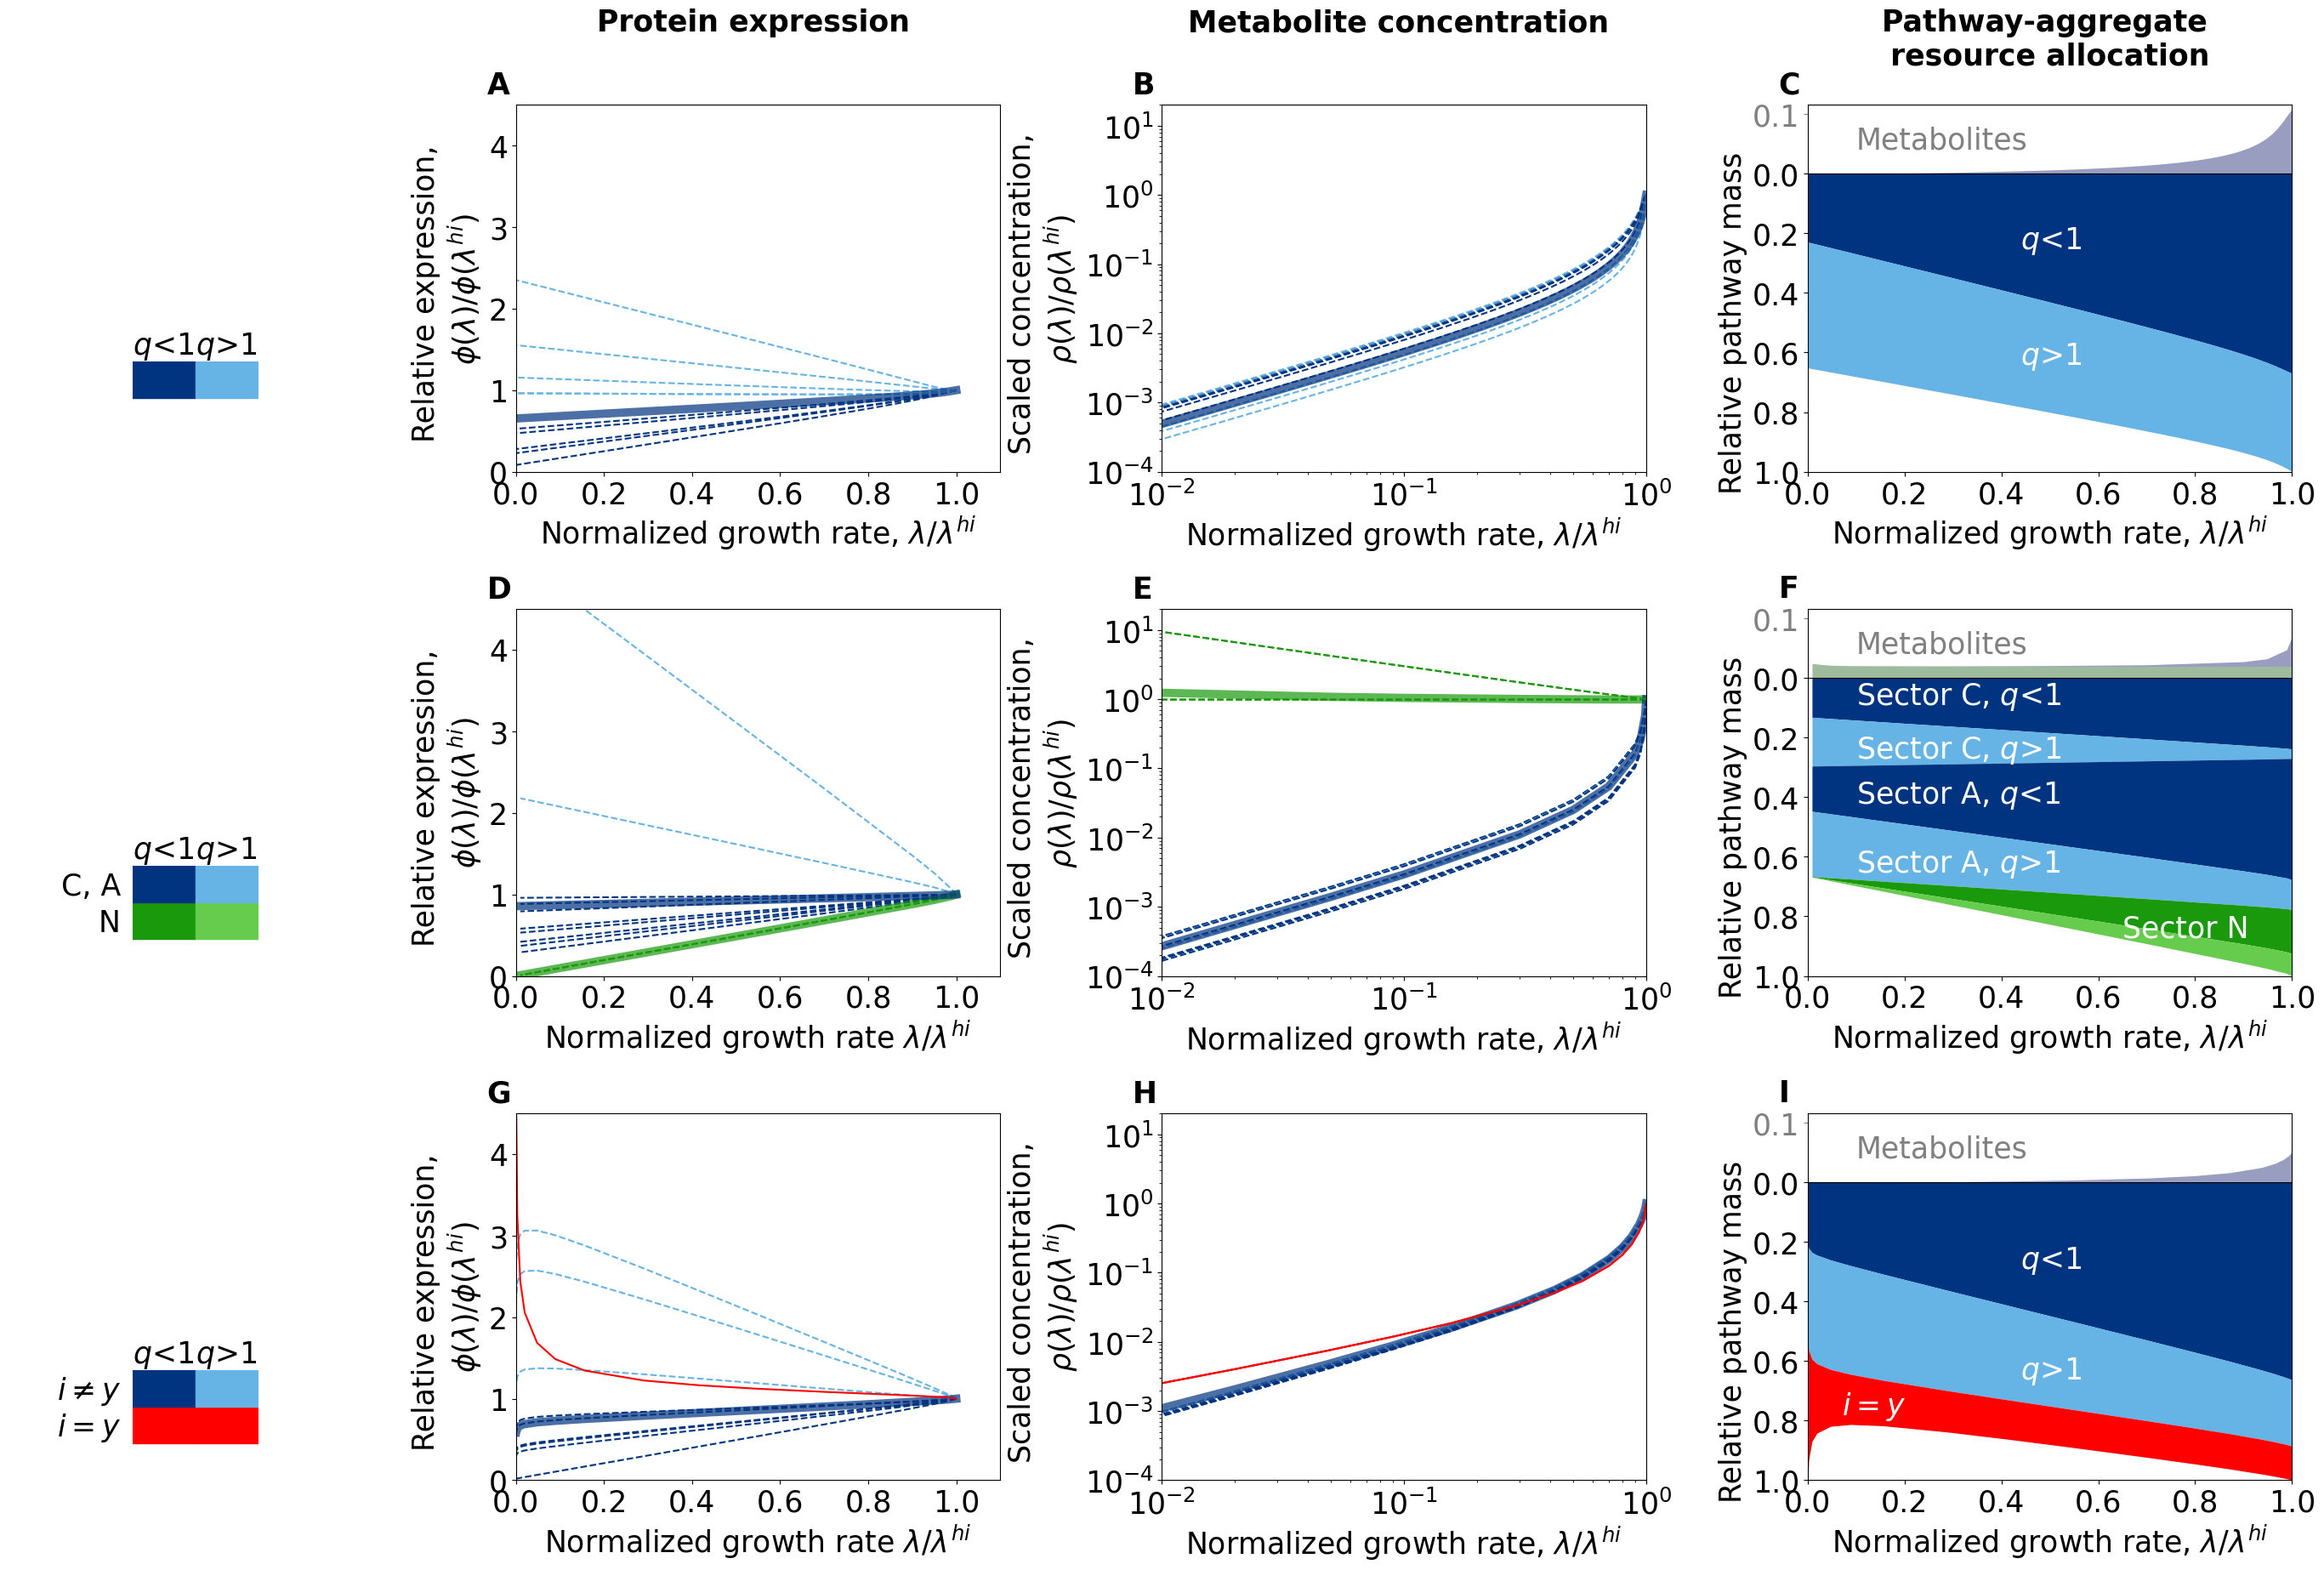

In [8]:
Nenzymes = 20
font = {'size'   : 25} #25#20
plt.rc('font', **font)

fig, axs = plt.subplots(4, 3, figsize = (1, 1))
fig = plt.figure(figsize = (35, 42))
gs = gridspec.GridSpec(120, 100)
gs.update(wspace=0, hspace=0)

axlabel1 = plt.subplot(gs[8:24, 0:18])
axlabel3 = plt.subplot(gs[30:46, 0:18])
axlabel2 = plt.subplot(gs[52:68, 0:18])

axs[0, 0] = plt.subplot(gs[8:24, 22:43])
axs[0, 1] = plt.subplot(gs[8:24, 50:71])
axs[0, 2] = plt.subplot(gs[11:24, 78:99])
ax03 = plt.subplot(gs[8:11, 78:99])

axs[2, 0] = plt.subplot(gs[30:46, 22:43])
axs[2, 1] = plt.subplot(gs[30:46, 50:71])
axs[2, 2] = plt.subplot(gs[33:46, 78:99])
ax23 = plt.subplot(gs[30:33, 78:99])

axs[1, 0] = plt.subplot(gs[52:68, 22:43])
axs[1, 1] = plt.subplot(gs[52:68, 50:71])
axs[1, 2] = plt.subplot(gs[55:68, 78:99])
ax13 = plt.subplot(gs[52:55, 78:99])

ax03.set_xticks([])
ax13.set_xticks([])
ax23.set_xticks([])
ax03.set_yticks([0.1])
ax13.set_yticks([0.1])
ax23.set_yticks([0.1])
ax03.tick_params(axis='y', colors='grey')
ax13.tick_params(axis='y', colors='grey')  
ax23.tick_params(axis='y', colors='grey') 

#Linear pathways
filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)
fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]
print(np.shape(fullensemble))

meancolors = ["k", "dimgrey"]
KMmean = np.exp(np.mean(np.log(fullensemble[:, 0, 1, :])))

efficiencybins = np.logspace(-2.2 , 2.2, 12)#np.logspace(-1, 1, 6)
efficiencybins2 = np.copy(efficiencybins)
ilocs = []
ensemble = []

ensemble = np.array(fullensemble)[:, :, :, None, :]

efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
efficiencies = efficiencies[:, None, :]

epsilons = np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), axis = 1)/np.sqrt(np.sum(1/fullensemble[:, 0, 0, :], axis = 1))
si = ((np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]).T)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), axis = 1)).T

print(np.shape(ensemble))
print(np.shape(efficiencies))

shift = 0
cutoff = 0
colors = ["k", "r"]
effs = ["L", "H"]
effcolors = ["b", "orange"]

basecolors = np.array([[(0, 0.2, 0.5, 1.0), (0.1, 0.6, 0.05, 1.0), (0, 0.2, 0.5, 1.0)], 
                       [(0.4, 0.7, 0.9, 1.0), (0.4, 0.8, 0.3, 1.0), (0.4, 0.7, 0.9, 1.0)]])

index = 283#111 #np.random.randint(500)
print(index)
lowcumulatives = np.zeros(np.shape(ensemble[index, :, 4, 0, 0]))
highcumulatives = np.zeros(np.shape(ensemble[index, :, 4, 0, 0]))
print(ensemble[index, 0, 4, 0, -1], ensemble[index, -1, 4, 0, -1])
#print("qbarbw_linear: ", np.sum(ensemble[index, 0, 4, 0, 8:18]*efficiencies[index, 0, 8:18])/np.sum(ensemble[index, 0, 4, 0, 8:18]))

for gr in range(1000):
    lowefficiencies = np.copy(ensemble[index, gr, 4, 0, 8:18])
    lowefficiencies[efficiencies[index, 0, 8:18]>1] = np.nan
    lowcumulative = np.nansum(lowefficiencies)
    lowcumulatives[gr] = lowcumulative

    highefficiencies = np.copy(ensemble[index, gr, 4, 0, 8:18])
    highefficiencies[efficiencies[index, 0, 8:18]<1] = np.nan
    highcumulative = np.nansum(highefficiencies)
    highcumulatives[gr] = highcumulative

norm = np.sum(lowcumulatives[0]+highcumulatives[0])

axs[0, 2].fill_between(ensemble[index, :, 5, 0, 0]/ensemble[index, 0, 5, 0, 0], lowcumulatives*0, lowcumulatives/norm, facecolor = tuple(np.abs(basecolors[0, 0])))#+np.array([*np.random.normal(0, 0.03, 3), 0]))))
axs[0, 2].fill_between(ensemble[index, :, 5, 0, 0]/ensemble[index, 0, 5, 0, 0], lowcumulatives/norm, (lowcumulatives+highcumulatives)/norm, facecolor = tuple(np.abs(basecolors[1, 0])))#+np.array([*np.random.normal(0, 0.03, 3), 0]))))
axs[0, 2].set_xlabel("Normalized growth rate, $\lambda/\lambda^{hi}$")
axs[0, 2].set_ylabel("Relative pathway mass")
axs[0, 2].text(0.44, 0.64, r"$q$>1", color = "white")
axs[0, 2].text(0.44, 0.25, r"$q$<1", color = "white")
axs[0, 2].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[0, 2].set_xlim(0, 1)
axs[0, 2].set_ylim(1, 0)
ax03.set_xlim(0, 1)
ax03.set_ylim(0, 3/13/2)
ax03.fill_between(ensemble[index, :, 5, 0, 0]/ensemble[index, 0, 5, 0, 0], np.zeros(1000), np.sum(ensemble[index, :, 3, 0, 5:15], axis = 1)/norm, edgecolor = 'white', facecolor = (0, 0.05, 0.4, 0.4))
#ax03.plot(np.linspace(0, 1, 100), np.zeros(100), "k", linewidth = 3)
ax03.text(0.1, 0.042, "Metabolites", color = "grey")

nrhos = []
Nenzymes = 20
for j in np.arange(10)+8:
    ngr = fullensemble[index, cutoff+1:, 5, 0]/fullensemble[index, cutoff+1, 5, 0]
    nrho = fullensemble[index, cutoff+1:, 3, j]/fullensemble[index, cutoff+1, 3, j]#(epsilons[index]**2*si[index, j])
    nphi = fullensemble[index, cutoff+1:, 4, j]/fullensemble[index, cutoff+1, 4, j]
    axs[0, 1].plot(ngr, nrho, color = tuple(np.abs(basecolors[int(efficiencies[index, 0, j]>1), 0])), linestyle = "--")
    axs[0, 0].plot(ngr, nphi, color = tuple(np.abs(basecolors[int(efficiencies[index, 0, j]>1), 0])), linestyle = "--")
    nrhos.append(nrho)

nrhos = np.array(nrhos)
axs[0, 0].plot(ngr, np.sum(fullensemble[index, cutoff+1:, 4, 8:18], axis = 1)/np.sum(fullensemble[index, cutoff+1, 4, 8:18]), color = tuple(np.abs(basecolors[0, 0])), linewidth = 7, linestyle = "-", alpha = 0.7)
axs[0, 1].plot(ngr, np.sum(fullensemble[index, cutoff+1:, 3, 8:18], axis = 1)/np.sum(fullensemble[index, cutoff+1, 3, 8:18]), color = tuple(np.abs(basecolors[0, 0])), linewidth = 7, linestyle = "-", alpha = 0.7)

axs[0, 1].set_ylabel("Scaled concentration, \n"+r"$\rho(\lambda)/\rho(\lambda^{hi})$")
axs[0, 1].set_xlabel("Normalized growth rate, $\lambda/\lambda^{hi}$")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xscale("log")
axs[0, 1].set_xlim(1e-2, 1e0)
axs[0, 1].set_ylim(1e-4, 2e1)

axs[0, 0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[0, 0].set_xlim(0, 1.1)
axs[0, 0].set_ylim(0, 4.5)
axs[0, 0].set_xlabel(r"Normalized growth rate, $\lambda/\lambda^{hi}$")
axs[0, 0].set_ylabel("Relative expression, \n"+r"$\phi(\lambda)/\phi(\lambda^{hi})$")

#illustrative plots for the cyclic network

cyclicensemble = np.load(data_folder+"cyclicPathway_nutrientLimitation_1.npy")
cyclicefficiencies = (np.sum(cyclicensemble[0, 0, :]**(-1))/np.sum(np.sqrt(cyclicensemble[0, 1, :]/cyclicensemble[0, 0, :]))*np.sqrt(cyclicensemble[0, 1, :]*cyclicensemble[0, 0, :]).T).T

cycliccumulatives = np.zeros(np.shape(cyclicensemble)[0])
cyclichighcumulatives = np.zeros(np.shape(cyclicensemble)[0])

for gr in range(np.shape(cyclicensemble)[0]):
    lowefficiencies = np.copy(cyclicensemble[gr, 4, :])
    lowefficiencies[9] = np.nan
    lowefficiencies[:5] = np.nan
    lowefficiencies[9:20] = np.nan
    lowefficiencies[cyclicefficiencies>1] = np.nan
    highefficiencies = np.copy(cyclicensemble[gr, 4, :])
    highefficiencies[9] = np.nan
    highefficiencies[:5] = np.nan
    highefficiencies[9:20] = np.nan
    highefficiencies[cyclicefficiencies<1] = np.nan
    
    cycliccumulative = np.nansum(lowefficiencies)
    cycliccumulatives[gr] = cycliccumulative
    cycliccumulative = np.nansum(highefficiencies)
    cyclichighcumulatives[gr] = cycliccumulative

norm = np.sum(cycliccumulatives[0]+cyclichighcumulatives[0]+cyclicensemble[0, 4, 9])

axs[1,  2].fill_between(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cycliccumulatives*0, cycliccumulatives/norm, facecolor = tuple(np.abs(basecolors[0, 0])))
axs[1,  2].fill_between(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cycliccumulatives/norm, (cycliccumulatives+cyclichighcumulatives)/norm, facecolor = tuple(np.abs(basecolors[1, 0])))
axs[1,  2].fill_between(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], (cycliccumulatives+cyclichighcumulatives)/norm, (cycliccumulatives+cyclichighcumulatives+cyclicensemble[:, 4, 9])/norm, facecolor = "red")

ax13.fill_between(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], 0*cyclicensemble[:, 5, 0], (np.sum(cyclicensemble[:, 3, 5:9], axis = 1)+np.sum(cyclicensemble[:, 3, Nenzymes:], axis = 1))/norm, edgecolor = 'white', facecolor = (0, 0.05, 0.4, 0.4))
axs[1,  2].set_xlabel("Normalized growth rate, $\lambda/\lambda^{hi}$")
axs[1,  2].set_ylabel("Relative pathway mass")
axs[1,  2].set_xlim(0, 1)
axs[1,  2].set_ylim(1, 0)
axs[1,  2].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axs[1,  2].text(0.44, 0.66, r"$q$>1", color = "white")
axs[1,  2].text(0.44, 0.29, r"$q$<1", color = "white")
axs[1,  2].text(0.07, 0.78, r"$i = y$", color = "white")
ax13.set_xlim(0, 1)
ax13.set_ylim(0, 3/13/2)
ax13.text(0.1, 0.042, "Metabolites", color = "grey")

phitot = 0
phiq = 0
nrhos = []
for j in [5, 6, 7, 8, 20, 21, 22, 23, 24]:
    phitot += cyclicensemble[0, 4, j]
    phiq += cyclicensemble[0, 4, j]*cyclicefficiencies[j]
    #illustrative plots for the cyclic network
    axs[1,  1].plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cyclicensemble[:, 3, j]/cyclicensemble[0, 3, j], color = tuple(np.abs(basecolors[int(cyclicefficiencies[j]>1), 0])), linestyle = "--")#(cyclicepsilon**2*cyclics[j]), color = tuple(np.abs(basecolors[int(cyclicefficiencies[j]>1), 0])), linestyle = "--")
    nrhos.append(cyclicensemble[:, 3, j]/cyclicensemble[0, 3, j])#/(cyclicepsilon**2*cyclics[j]))
nrhos = np.array(nrhos)
#phitot += cyclicensemble[0, 4, 9]
#phiq += cyclicensemble[0, 4, 9]*cyclicefficiencies[9]
#print("qbarbw_cyclic: ", phiq/phitot)
axs[1,  1].plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], np.mean(nrhos, axis = 0), color = tuple(np.abs(basecolors[0, 0])), linewidth = 7, alpha = 0.7)

axs[1,  1].plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cyclicensemble[:, 3, 9]/cyclicensemble[0, 3, 9], color = "red")#(cyclicepsilon**2*cyclics[9]), color = "red")
axs[1,  1].plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cyclicensemble[:, 3, 20]/cyclicensemble[0, 3, 20], color = "red")#(cyclicepsilon**2*cyclics[9]), color = "red") #same s for 9 and 20

axs[1,  1].set_ylabel("Scaled concentration, \n"+r"$\rho(\lambda)/\rho(\lambda^{hi})$")
axs[1,  1].set_xlabel("Normalized growth rate, $\lambda/\lambda^{hi}$")
axs[1,  1].set_yscale("log")
axs[1,  1].set_xscale("log")
axs[1,  1].set_xlim(1e-2, 1e0)
axs[1,  1].set_ylim(1e-4, 2e1)

allphis = []
for j in [5, 6, 7, 8, 20, 21, 22, 23, 24]:  
    #illustrative plots for the cyclic network
    axs[1,  0].plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cyclicensemble[:, 4, j]/cyclicensemble[0, 4, j], color = tuple(np.abs(basecolors[int(cyclicefficiencies[j]>1), 0])), linestyle = "--")
    allphis.append(cyclicensemble[:, 4, j])
allphis = np.array(allphis)
axs[1,  0].plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], np.sum(allphis, axis = 0)/np.sum(allphis[:, 0]), color = tuple(np.abs(basecolors[0, 0])), linewidth = 7, alpha = 0.7)

j = 9
axs[1,  0].plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cyclicensemble[:, 4, j]/cyclicensemble[0, 4, j], color = "red")

axs[1,  0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[1,  0].set_xlim(0, 1.1)
axs[1,  0].set_ylim(0, 4.5)
axs[1,  0].set_xlabel(r"Normalized growth rate $\lambda/\lambda^{hi}$")
axs[1,  0].set_ylabel("Relative expression, \n"+r"$\phi(\lambda)/\phi(\lambda^{hi})$")


#fig.tight_layout()

#### Branched Chain
Nenzymes = 10

#before #realization, nutrient, type, position
#iter, gr, type, branch, pos
ConstrainedResultsArray = np.load("ConstrainedYChain_10grs_Monod.npy")

saveargsYArray = np.load("ConstrainedYChainParameters_10grs_Monod.npy")
#iter, branch, [kappas, KMs, bs, ..]
KMmean = np.exp(np.mean(np.log(saveargsYArray[:, :, Nenzymes:2*Nenzymes])))

kappas = np.repeat(saveargsYArray[:, None, None, :, :Nenzymes], 10, axis=1)
KMs = np.repeat(saveargsYArray[:, None, None, :, Nenzymes:2*Nenzymes], 10, axis=1)
bs = np.repeat(saveargsYArray[:, None, None, :, 2*Nenzymes:3*Nenzymes], 10, axis=1)

params = np.concatenate((kappas, KMs, bs), axis = 2)

fullensemble = ConstrainedResultsArray
fullensemble = np.concatenate((params, fullensemble), axis = 2)
print(fullensemble[0, :, 5, 0, 0])
ensemble=fullensemble[:, [0, 5, 7]]
print(np.shape(ensemble))

### calculate efficiencies based on the whole network
Normalization_old = np.sum(saveargsYArray[:, :, :Nenzymes]**(-1), (1, 2))/np.sum(np.sqrt(saveargsYArray[:, :, Nenzymes:2*Nenzymes]/saveargsYArray[:, :, :Nenzymes]), (1, 2))
efficiencies = (Normalization_old * np.sqrt(saveargsYArray[:, :, Nenzymes:2*Nenzymes]*saveargsYArray[:, :, :Nenzymes]).T).T
print(np.shape(efficiencies))

efficiencybins = np.logspace(-1.4, 1.4, 8)
ensemble[:, :, 3, 1, -1] = ensemble[:, :, 1, 1, -1]*1000
epsilons = np.sum(np.sqrt(fullensemble[:, 0, 1, :, :]/fullensemble[:, 0, 0, :, :]), axis = (1, 2))/np.sqrt(np.sum(1/fullensemble[:, 0, 0, :, :], axis = (1, 2)))
si = ((np.sqrt(fullensemble[:, 0, 1, :, :]/fullensemble[:, 0, 0, :, :]).T)/np.sum(np.sqrt(fullensemble[:, 0, 1, :, :]/fullensemble[:, 0, 0, :, :]), axis = (1, 2))).T

specialindex = 0#np.random.randint(500)
index = specialindex

lowcumulatives = np.zeros(np.shape(fullensemble[index, :, 4, :, 0])) 
highcumulatives = np.zeros(np.shape(fullensemble[index, :, 4, :, 0]))  


for b in [0, 2, 1]:
    for gr in range(10):
        lowefficiencies = np.copy(fullensemble[index, gr, 4, b, (b == 0)*5:5+(b == 0)*5])
        lowefficiencies[efficiencies[index, b, (b == 0)*5:5+(b == 0)*5]>1] = np.nan
        highefficiencies = np.copy(fullensemble[index, gr, 4, b, (b == 0)*5:5+(b == 0)*5])
        highefficiencies[efficiencies[index, b, (b == 0)*5:5+(b == 0)*5]<1] = np.nan
        lowcumulative = np.nansum(lowefficiencies)
        lowcumulatives[gr, b] = lowcumulative
        highcumulative = np.nansum(highefficiencies)
        highcumulatives[gr, b] = highcumulative

norm = np.sum(lowcumulatives[0, :])+np.sum(highcumulatives[0, :])
subcumulative = 0*lowcumulatives[:,0]
for b in [0, 2, 1]:
    axs[2, 2].fill_between(fullensemble[index, :, 5, 0, 0]/fullensemble[index, 0, 5, 0, 0], subcumulative, subcumulative+lowcumulatives[:, b]/norm, facecolor = tuple(np.abs(basecolors[0, b])))
    subcumulative = subcumulative+lowcumulatives[:, b]/norm
    axs[2, 2].fill_between(fullensemble[index, :, 5, 0, 0]/fullensemble[index, 0, 5, 0, 0], subcumulative, subcumulative+highcumulatives[:, b]/norm, facecolor = tuple(np.abs(basecolors[1, b])))
    subcumulative = subcumulative+highcumulatives[:, b]/norm

axs[2, 2].set_xlabel("Normalized growth rate, $\lambda/\lambda^{hi}$")
axs[2, 2].set_ylabel("Relative pathway mass")
axs[2, 2].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axs[2, 2].set_xlim(0, 1)
axs[2, 2].set_ylim(1, 0)
ax23.set_xlim(0, 1)
ax23.set_ylim(0, 3/13/2)
ax23.fill_between(fullensemble[index, :, 5, 0, 0]/fullensemble[index, 0, 5, 0, 0], np.zeros(10), np.sum(fullensemble[index, :, 3, 1, :5], axis = 1)/norm, facecolor = (0, 0.3, 0, 0.38))
ax23.fill_between(fullensemble[index, :, 5, 0, 0]/fullensemble[index, 0, 5, 0, 0], np.sum(fullensemble[index, :, 3, 1, :5], axis = 1)/norm, (np.sum(fullensemble[index, :, 3, 1, :5], axis = 1)+np.sum(fullensemble[index, :, 3, 0, 5:], axis = 1)+np.sum(fullensemble[index, :, 3, 2, :5], axis = 1))/norm, facecolor = (0, 0.05, 0.4, 0.4))
#ax23.plot(np.linspace(0, 1, 100), np.zeros(100), "k", linewidth = 3)
ax23.text(0.1, 0.042, "Metabolites", color = "grey")
axs[2, 2].text(0.65, 0.87, "Sector N", color = "white")
axs[2, 2].text(0.1, 0.65, r"Sector A, $q$>1", color = "white")
axs[2, 2].text(0.1, 0.42, r"Sector A, $q$<1", color = "white")
axs[2, 2].text(0.1, 0.27, r"Sector C, $q$>1", color = "white")
axs[2, 2].text(0.1, 0.09, r"Sector C, $q$<1", color = "white")

nrhos1 = []
nrhos = []
nphis1 = []
nphis = []
phitot = 0
phiq = 0
for b in [0, 2, 1]:
    for j in range(5):
        if b !=1:
            phitot += fullensemble[index, 0, 4, b, j+5*(b==0)]
            phiq += fullensemble[index, 0, 4, b, j+5*(b==0)]*efficiencies[index, b, j+5*(b==0)]
        ngr = fullensemble[index, :, 5, 0, 0]/fullensemble[index, 0, 5, 0, 0]#lammaxs[index]
        nrho = fullensemble[index, :, 3, b, j+5*(b==0)]/fullensemble[index, 0, 3, b, j+5*(b==0)]#/(epsilons[index]**2*si[index, b, j+5*(b==0)])
        nphi = fullensemble[index, :, 4, b, j+5*(b==0)]/fullensemble[index, 0, 4, b, j+5*(b==0)]
        axs[2, 1].plot(ngr, nrho, color = tuple(np.abs(basecolors[int(efficiencies[index, b, j+5*(b==0)]>1), b])), linestyle = "--")
        axs[2, 0].plot(ngr, nphi, color = tuple(np.abs(basecolors[int(efficiencies[index, b, j+5*(b==0)]>1), b])), linestyle = "--")
        if b == 1:
            nrhos1.append(fullensemble[index, :, 3, b, j+5*(b==0)])#/(epsilons[index]**2*si[index, b, j+5*(b==0)]))
            nphis1.append(fullensemble[index, :, 4, b, j+5*(b==0)])
        else:
            nrhos.append(fullensemble[index, :, 3, b, j+5*(b==0)])#/(epsilons[index]**2*si[index, b, j+5*(b==0)]))
            nphis.append(fullensemble[index, :, 4, b, j+5*(b==0)]) 
nrhos1 = np.array(nrhos1)
nrhos = np.array(nrhos)
nphis1 = np.array(nphis1)
nphis = np.array(nphis)

#print("qbarbw_branched: ", phiq/phitot)
axs[2, 0].plot(ngr, np.sum(nphis1, axis = 0)/np.sum(nphis1[:, 0]), color = tuple(np.abs(basecolors[0, 1])), linewidth = 7, alpha = 0.7)
axs[2, 0].plot(ngr, np.sum(nphis, axis = 0)/np.sum(nphis[:, 0]), color = tuple(np.abs(basecolors[0, 0])), linewidth = 7, alpha = 0.7)
axs[2, 1].plot(ngr, np.sum(nrhos1, axis = 0)/np.sum(nrhos1[:, 0]), color = tuple(np.abs(basecolors[0, 1])), linewidth = 7, alpha = 0.7)
axs[2, 1].plot(ngr, np.sum(nrhos, axis = 0)/np.sum(nrhos[:, 0]), color = tuple(np.abs(basecolors[0, 0])), linewidth = 7, alpha = 0.7)


ngr = fullensemble[index, :, 5, 0, 0]/fullensemble[index, 0, 5, 0, 0]#/lammaxs[index]
nrho = fullensemble[index, :, 3, 1, 0]/fullensemble[index, 0, 3, 1, 0]#(epsilons[index]**2*si[index, 1, 0])
axs[2, 1].plot(ngr, nrho, "--", color = tuple(np.abs(basecolors[int(efficiencies[index, 1, 0]>1), 1])), label = "junction")#+np.array([*np.random.normal(0, 0.03, 3), 0]))))
axs[2, 1].plot([0,0], [0,0], "-", color = basecolors[0, 0], label = "C, A sector: q<1")#+np.array([*np.random.normal(0, 0.03, 3), 0]))))
axs[2, 1].plot([0,0], [0,0], "-", color = basecolors[1, 0], label = "C, A sector: q>1")
axs[2, 1].plot([0,0], [0,0], "-", color = basecolors[1, 1], label = "N sector")

axs[2, 1].set_ylabel("Scaled concentration, \n"+r"$\rho(\lambda)/\rho(\lambda^{hi})$")
axs[2, 1].set_xlabel("Normalized growth rate, $\lambda/\lambda^{hi}$")
axs[2, 1].set_yscale("log")
axs[2, 1].set_xscale("log")
axs[2, 1].set_xlim(1e-2, 1e0)
axs[2, 1].set_ylim(1e-4, 2e1)

axs[2, 0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[2, 0].set_xlim(0, 1.1)#1.1*fullensemble[index, 0, 5, 0, 0]/lammaxs[index])
axs[2, 0].set_ylim(0, 4.5)
axs[2, 0].set_xlabel(r"Normalized growth rate $\lambda/\lambda^{hi}$")
axs[2, 0].set_ylabel("Relative expression, \n"+r"$\phi(\lambda)/\phi(\lambda^{hi})$")


#Legends for insets
axins = inset_axes(axlabel1, width="30%", height="30%", loc=1, bbox_to_anchor=(-0.4, -0.7, 1, 1), bbox_transform=axlabel1.transAxes, borderpad=0)
for i in range(2):
    j = 0
    axins.fill_between(np.linspace(i, i+1, 10), np.zeros(10)+2, np.zeros(10)+2+1, color = basecolors[i, j])
axins.set_xlim(0, 2)
axins.set_ylim(0, 3)
axins.axis("off")
axins.text(0, 3.2, r"$q$<1")
axins.text(1, 3.2, r"$q$>1")

axins = inset_axes(axlabel2, width="30%", height="30%", loc=1, bbox_to_anchor=(-0.4, -0.7, 1, 1), bbox_transform=axlabel2.transAxes, borderpad=0)
for i in range(2):
    j = 1#for j in np.arange(2)+1:
    axins.fill_between(np.linspace(i, i+1, 10), np.zeros(10)+j, np.zeros(10)+j+1, color = "red")
    j = 2
    axins.fill_between(np.linspace(i, i+1, 10), np.zeros(10)+j, np.zeros(10)+j+1, color = basecolors[i, j])
axins.set_xlim(0, 2)
axins.set_ylim(0, 3)
axins.axis("off")
axins.text(0, 3.2, r"$q$<1")
axins.text(1, 3.2, r"$q$>1")
axins.text(-.2, 2.2, r"$i\neq y$", horizontalalignment='right')
axins.text(-.2, 1.2, r"$i = y$", horizontalalignment='right')
#axins.text(-.6, 0.2, "C")
    
axins = inset_axes(axlabel3, width="30%", height="30%", loc=1, bbox_to_anchor=(-0.4, -0.7, 1, 1), bbox_transform=axlabel3.transAxes, borderpad=0)
for i in range(2):
    for j in np.arange(2)+1:
        axins.fill_between(np.linspace(i, i+1, 10), np.zeros(10)+j, np.zeros(10)+j+1, color = basecolors[i, j])
axins.set_xlim(0, 2)
axins.set_ylim(0, 3)
axins.axis("off")
axins.text(0, 3.2, r"$q$<1")
axins.text(1, 3.2, r"$q$>1")
axins.text(-.2, 2.2, "C, A", horizontalalignment='right')
axins.text(-.2, 1.2, "N", horizontalalignment='right')
#axins.text(-.6, 0.2, "C")


axlabel1.axis("off")
axlabel2.axis("off")
axlabel3.axis("off")


for n, ax in enumerate([axs[0, 0], axs[0, 1], axs[0, 2], axs[2, 0], axs[2, 1], axs[2, 2], axs[1, 0], axs[1, 1], axs[1, 2]]): 
    if n in (0, 1, 3, 4, 6, 7, 9, 10):
        ax.text(-0.06, 1.03, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')
    elif n in (2, 5, 8, 11):
        ax.text(-0.06, 1.27, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

axs[0, 0].set_title("Protein expression \n \n", weight='bold')
axs[0, 1].set_title("Metabolite concentration \n \n", weight='bold')
ax03.set_title("Pathway-aggregate \n resource allocation \n", weight='bold')
#Illustrative insets added with inkscape       

print(specialindex) #466
#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/MainTextReallocation_Pathways.pdf", bbox_inches="tight", format = 'pdf')


(720, 100)
-0.11437283274056738 6.090504964866401e-37
Ribosome
P0AD49
P62399
P0A7J3
P0A7J7
P0ADY3
P0AG44
P61175
P0ADZ0
P68919
P0A7M6
P0A7N9
P0A7Q1
P0AG67
P0A7V3
P0A7V8
P0A7W1
P0A7W7
P0A7X3
P0A7R5
P0A7S9
P0AG59
P0A7T3
P0AG63
P0A7U3
P0A7U7
Glycolysis
P0A6P9
P0A9B2
P62707
P0A796
P0A6T1
P0A799
P0A858
Tetrahydrofolate
P0ABQ4
P0AC16
P08192
P0A6T5
P26281
P0AC19
P08179
P37051
P0A884


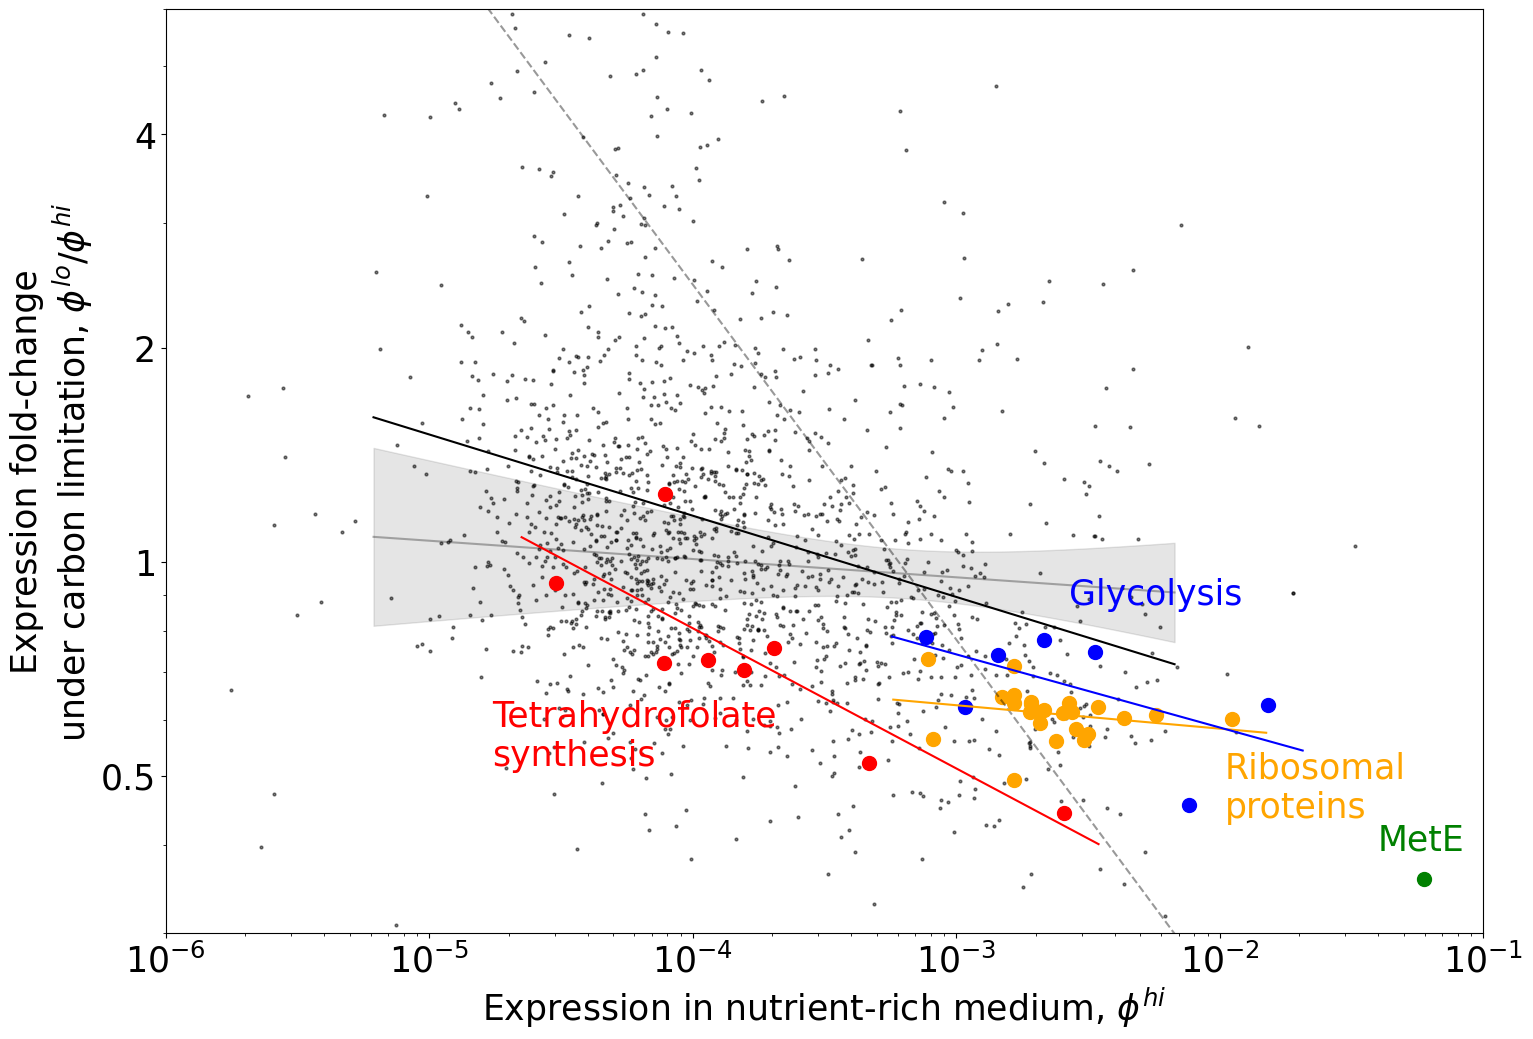

In [9]:
#Figure 5
fig, axs = plt.subplots(1, 1, figsize = (17, 12))
font = {'size'   : 25} #20
plt.rc('font', **font)

ax = axs

dataset = pd.read_excel("/Users/leonseeger/Desktop/largeDBFiles/msb20209536-sup-0010-datasetev9.xlsx", sheet_name = "EV9-AbsoluteMassFractions-2", index_col = 1, header=6) 

data = dataset[["C2", "C3", "C4", "C5", "C6", "C7"]].to_numpy()
grs = np.array([0.91, 0.77, 0.69, 0.56, 0.48, 0.35])
meangr = np.mean(grs)

names = dataset[["Gene name"]].to_numpy()
UniIDs = dataset[["Protein ID"]].to_numpy()
means = np.mean(data, 1)
#means[means == 0] = np.nan
means[np.any(data == 0, axis = 1)] = np.nan
slopes = np.sum((data.T-means).T*(grs-meangr), 1)/np.sum((grs-meangr)**2)
offsets = means-slopes*meangr
r2s = np.sum((data.T-means).T*(grs-meangr), 1)/np.sqrt(np.sum((grs-meangr)**2)*np.sum((data.T-means).T**2, 1))
squares = np.sum((data - ((np.array([slopes]*len(grs)).T*grs).T+offsets).T)**2, 1)/means**2

#ax = axs[0, 2]
#x = means[~np.isnan(offsets)]
#y = offsets[~np.isnan(offsets)]/means[~np.isnan(offsets)]
x = (data[:, 0])[~np.isnan(offsets)]
y = (data[:, -1]/data[:, 0])[~np.isnan(offsets)]
validdata = np.all(np.array([x>0, y>0]), 0)
y = np.log(y[validdata])
x = np.log(x[validdata])

x_data = np.copy(x)
y_data = np.copy(y)
#print(np.sum([y>1]/np.shape(y)[0]))


perms = np.array(list(set(permutations(["C2", "C3", "C4", "C5", "C6", "C7"]))))
xs = np.linspace(-12, -5, 100)
if True:
    allys = []
    for perm in perms[:]:
        permuted_data = dataset[perm].to_numpy()
        permuted_slopes = np.sum((permuted_data.T-means).T*(grs-meangr), 1)/np.sum((grs-meangr)**2)
        permuted_offsets = means-permuted_slopes*meangr
        permuted_x = (permuted_data[:, 0])[~np.isnan(permuted_offsets)]
        permuted_y = (permuted_data[:, -1]/permuted_data[:, 0])[~np.isnan(permuted_offsets)]
        permuted_validdata = np.all(np.array([permuted_x>0, permuted_y>0]), 0)
        permuted_y = np.log(permuted_y[permuted_validdata])
        permuted_x = np.log(permuted_x[permuted_validdata])
        permuted_slope, permuted_intercept, permuted_r_value, permuted_p_value, permuted_std_err = linregress(permuted_x,permuted_y)
        allys.append(permuted_slope*xs+permuted_intercept)
        #ax.plot(np.exp(xs), np.exp(permuted_slope*xs+permuted_intercept), "k--", alpha = 0.1)
    allys = np.array(allys)
    meany = np.mean(allys, 0)
    yup = meany + 2*np.std(allys, 0)
    ydown = meany - 2*np.std(allys, 0)
    ax.plot(np.exp(xs), np.exp(meany), "k-", alpha = 0.3)
    ax.fill_between(np.exp(xs), np.exp(ydown), np.exp(yup), color = "k", alpha = 0.1)
    print(np.shape(allys))
    
    x_rotate = xs[np.where(np.std(allys, 0) == np.min(np.std(allys, 0)))[0][0]]
    y_rotate = meany[np.where(np.std(allys, 0) == np.min(np.std(allys, 0)))[0][0]]
    y_expected = y_rotate-0.5*(xs-x_rotate)
    ax.plot(np.exp(xs), np.exp(y_expected), "k--", alpha = 0.4)

slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, p_value)
#print(p_value, permuted_p_value)

ax.scatter(np.exp(x), np.exp(y), s = 4, c="k", alpha = 0.5)#np.abs(r2s[~np.isnan(offsets)][validdata]))
ax.plot(np.exp(xs), np.exp(slope*xs+intercept), label = "Linear regression over all proteins", color = "k")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Expression in nutrient-rich medium, $\phi^{hi}$")
ax.set_ylabel("Expression fold-change\nunder carbon limitation" + r", $\phi^{lo}/\phi^{hi}$")

RibosomalIDs = []
with open("pantherRibosomalProteins.txt") as file:
    for line in file:
        if "PC00202" in line: #finds all ribosomal proteins
            RibosomalIDs.append(line[39:45])
            #print(line)

maskR = []
index = 0
print("Ribosome")
for UniID in UniIDs:
    if UniID not in RibosomalIDs:
        maskR.append(index)
    else:
        print(UniID[0])
    #if UniID not in RibosomalIDs:
    #    maskR.append(index)
    index += 1

offsetsR = np.copy(offsets)
offsetsR[maskR] = np.nan

x = (data[:, 0])[~np.isnan(offsetsR)]
y = (data[:, -1]/data[:, 0])[~np.isnan(offsetsR)]
validdata = np.all(np.array([x>0, y>0]), 0)
y = np.log(y[validdata])
x = np.log(x[validdata])
ax.scatter(np.exp(x), np.exp(y), s = 100, alpha = 1, c = "orange")
ax.annotate("Ribosomal\nproteins", (np.exp(np.nanmean(x))*4.5, np.exp(np.nanmean(y))/1.4), color = "orange")
xs = np.linspace(np.nanmin(x)-0.3, np.nanmax(x)+0.3, 100)
slope, intercept, r_value, p_value, std_err = linregress(x,y)
ax.plot(np.exp(xs), np.exp(slope*xs+intercept), label = "Linear regression over ribosomal proteins", color = "orange")


xM = data[np.where(names=="metE")[0][0], 0]
yM = data[np.where(names=="metE")[0][0], -1]/data[np.where(names=="metE")[0][0], 0]
#print(data[np.where(names=="metE")[0][0], 0], data[np.where(names=="metE")[0][0], -1])
ax.scatter(xM, yM, s = 100, alpha = 1, c = "g")
ax.annotate("MetE", (xM/1.5, yM*1.1), color = "g")

ax.set_ylim(0.3, 6)
ax.set_yticks([0.5, 1, 2, 4])
ax.set_yticklabels([0.5, 1, 2, 4])
ax.set_xlim(1e-6, 1e-1)



GlycolyticIDs = []
with open("pantherGlycolyticProteins.txt") as file:
    for line in file:
        GlycolyticIDs.append(line[39:45])

maskG = []
index = 0
print("Glycolysis")
for UniID in UniIDs:
    if UniID not in GlycolyticIDs:
        maskG.append(index)
    else:
        print(UniID[0])
    index += 1

offsetsG = np.copy(offsets)
offsetsG[maskG] = np.nan

x = (data[:, 0])[~np.isnan(offsetsG)]
y = (data[:, -1]/data[:, 0])[~np.isnan(offsetsG)]
validdata = np.all(np.array([x>0, y>0]), 0)
y = np.log(y[validdata])
x = np.log(x[validdata])
ax.scatter(np.exp(x), np.exp(y), s = 100, alpha = 1, c = "b")
ax.annotate("Glycolysis", (np.exp(np.nanmean(x)), np.exp(np.nanmean(y))*1.3), color = "b")
xs = np.linspace(np.nanmin(x)-0.3, np.nanmax(x)+0.3, 100)
slope, intercept, r_value, p_value, std_err = linregress(x,y)
ax.plot(np.exp(xs), np.exp(slope*xs+intercept), label = "Linear regression over Glycolysis", color = "b")


THFIDs = []
#with open("pantherTCAProteins.txt") as file:
with open("pantherTHFSynthesis.txt") as file:
    for line in file:
        THFIDs.append(line[39:45])

maskT = []
index = 0
print("Tetrahydrofolate")
for UniID in UniIDs:
    if UniID not in THFIDs:
        maskT.append(index)
    else:
        print(UniID[0])
    #if UniID not in THFIDs:
    #    maskT.append(index)
    index += 1

offsetsT = np.copy(offsets)
offsetsT[maskT] = np.nan

x = (data[:, 0])[~np.isnan(offsetsT)]
y = (data[:, -1]/data[:, 0])[~np.isnan(offsetsT)]
validdata = np.all(np.array([x>0, y>0]), 0)
y = np.log(y[validdata])
x = np.log(x[validdata])
ax.scatter(np.exp(x), np.exp(y), s = 100, alpha = 1, color = "r")
ax.annotate("Tetrahydrofolate\nsynthesis", (np.exp(np.nanmean(x))/10, np.exp(np.nanmean(y))/1.4), color = "r")
xs = np.linspace(np.nanmin(x)-0.3, np.nanmax(x)+0.3, 100)
slope, intercept, r_value, p_value, std_err = linregress(x,y)
ax.plot(np.exp(xs), np.exp(slope*xs+intercept), label = "Linear regression over THF-Synthesis", color = "r")


#ax.legend()
#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/MainText4b.pdf", bbox_inches="tight", format = 'pdf')

In [10]:
#Feed-forward regulation simulation

Nenzymes = 20
filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]

print(np.shape(fullensemble))

index = np.where((fullensemble[:, 0, 3, -1]<1)*(fullensemble[:, 0, 1, -1]>1e-5))[0][1]
onechain = fullensemble[index]

def Pproduction(rho, KM, kappa, sumoverkappa, sumKMoverkappa):
    phii0 = KM/kappa/(np.sqrt(KM/kappa)*sumKMoverkappa)
    ai = (1/kappa/sumoverkappa-phii0)
    Kregi = np.sqrt(KM/kappa)*sumKMoverkappa/sumoverkappa
    return phii0 +ai/(1+Kregi/rho)
    #return 1/kappa*(rho+KM)/(rho*sumoverkappa+np.sqrt(KM/kappa)*sumKMoverkappa)

def Rproduction(phi, rho, KM, kappa):
    return kappa*phi/(1+KM/rho)

def iterate(phistart, KMs, kappas, nu, phiUptake, Nsteps = 500000):
    sumoverkappa = np.sum(1/kappas)
    sumKMoverkappa = np.sum(np.sqrt(KMs/kappas))
    phis = phistart
    phis = phis/np.sum(phis)
    lam = 0
    rhos = KMs*np.sqrt(phistart/KMs)
    rhos[-1] = nu
    
    dt = 1e-5
    savephis = [phis]
    saverhos = [rhos]
    times = [0]
    steps = np.arange(Nsteps)
    for i in steps:
        fluxes = Rproduction(phis, rhos, KMs, kappas)
        shiftedfluxes = np.append(fluxes[1:], np.zeros(1))
        drhos = -lam*rhos-fluxes+shiftedfluxes
        
        dMs = Pproduction(rhos, KMs, kappas, sumoverkappa, sumKMoverkappa)*(1-phiUptake)
        dMs = dMs/np.sum(dMs[:-1])*(1-phiUptake)
        dMs[-1] = phiUptake
        
        phis += (-lam*phis+lam*dMs/np.sum(dMs))*dt
        phis = phis/np.sum(phis)
        rhos += drhos*dt
        
        lam = fluxes[0]
        rhos[-1] = nu
        rhos[rhos<0] = 1e-15
        if i%100 == 0:
            times.append(dt*steps[i])
            savephis.append(phis)
            saverhos.append(np.copy(rhos))
            
    savephis = np.array(savephis)
    saverhos = np.array(saverhos)
    
    #fig, axs = plt.subplots(1, 2, figsize = (15, 5))
    allrhos = np.logspace(-3, 3, 100)
    productions = []
    
    for rho in allrhos:
        productions.append(Pproduction(rho*KMs, KMs, kappas, sumoverkappa, sumKMoverkappa))
    productions = np.array(productions)
    
    return times, saverhos, savephis, allrhos, productions[:, 0]/productions[-1, 0], rhos, phis, fluxes

reduction0 = np.min(np.where(onechain[:, 5, 0] <= onechain[0, 5, 0]/1.01))
reduction1 = np.min(np.where(onechain[:, 5, 0] <= onechain[0, 5, 0]/2))
reduction2 = np.min(np.where(onechain[:, 5, 0] <= onechain[0, 5, 0]/1.5))

richref = onechain[reduction0]
ref = onechain[reduction1]
ref2 = onechain[reduction2]

kappas = richref[0]
KMs = richref[1]
phistart = ref2[4]*np.random.lognormal(0, 2, 20)
richref = onechain[0]
nu = richref[3, -1]
phimin = richref[4, -1]
phimax = 5*phimin/(1+(5-1)*phimin)
phiUptake = (1/phimax+(1/phimin-1/phimax)*nu/(nu+KMs[-1]))**(-1)

times0, saverhos0, savephis0, allrhos0, normproductions0, rhos0, phis0, fluxes0 = iterate(phistart, KMs, kappas, nu, phiUptake)

#phistart = richref[4]*np.random.lognormal(0, 2, 20)
phistart = np.copy(phis0)
nu = richref[3, -1]
phiUptake = (1/phimax+(1/phimin-1/phimax)*nu/(nu+KMs[-1]))**(-1)

times, saverhos, savephis, allrhos, normproductions, rhos, phis, fluxes = iterate(phistart, KMs, kappas, nu, phiUptake, Nsteps = 250000)


phistart = np.copy(phis)#richref[4]*np.random.lognormal(0, 1, 20)*ref[5, 0]/richref[5, 0]
nu = ref[3, -1]
phiUptake = (1/phimax+(1/phimin-1/phimax)*nu/(nu+KMs[-1]))**(-1)

times2, saverhos2, savephis2, allrhos2, normproductions2, rhos2, phis2, fluxes2 = iterate(phistart, KMs, kappas, nu, phiUptake)


phistart = np.copy(phis2)#richref[4]*np.random.lognormal(0, 1, 20)*ref[5, 0]/richref[5, 0]
nu = ref2[3, -1]
phiUptake = (1/phimax+(1/phimin-1/phimax)*nu/(nu+KMs[-1]))**(-1)

times3, saverhos3, savephis3, allrhos3, normproductions3, rhos3, phis3, fluxes3 = iterate(phistart, KMs, kappas, nu, phiUptake)

(5000, 42)
(5000, 1000, 3, 20)
(5000, 1000, 6, 20)


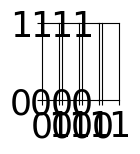

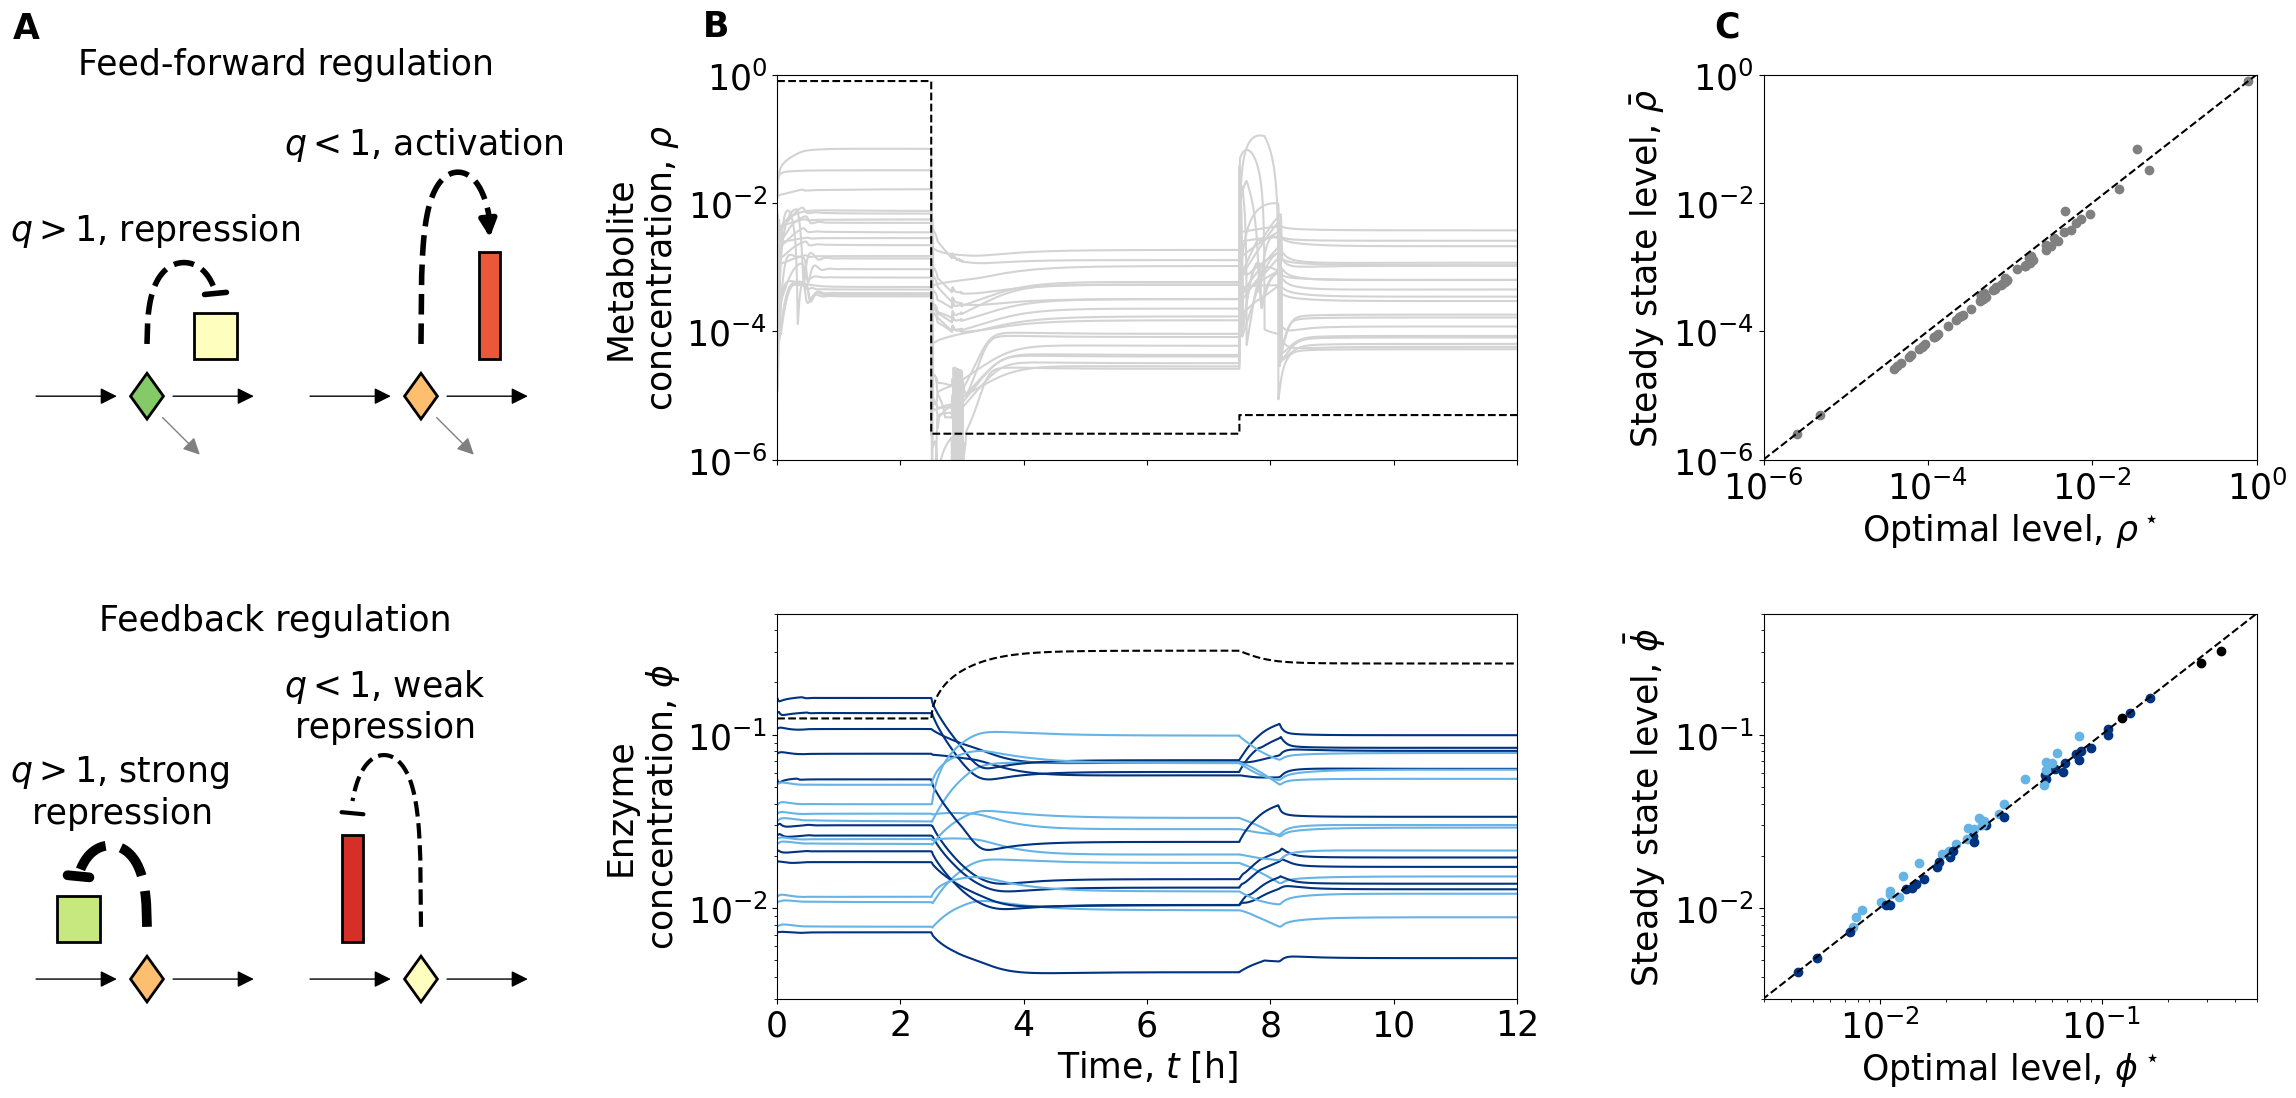

In [11]:
#Figure 6

times = np.array(times)
savephis = np.array(savephis)
saverhos = np.array(saverhos)
times2 = np.array(times2)
savephis2 = np.array(savephis2)
saverhos2 = np.array(saverhos2)
times3 = np.array(times3)
savephis3 = np.array(savephis3)
saverhos3 = np.array(saverhos3)

alltimes = np.concatenate((times, times2+times[-1], times3+times2[-1]+times[-1]))
allphis = np.concatenate((savephis, savephis2, savephis3))
allrhos = np.concatenate((saverhos, saverhos2, saverhos3))

lammax = 1/np.sum(1/kappas)
Qs = np.sqrt(kappas*KMs)
qis = Qs/(np.sum(Qs/kappas)*lammax)

RYG = plt.cm.get_cmap('RdYlGn')


font = {'size'   : 25}
plt.rc('font', **font)
dt = 1e-5
fig, axs = plt.subplots(1, 4, figsize = (1, 1))
fig = plt.figure(figsize = (35, 12))
gs = gridspec.GridSpec(12, 11)
gs.update(wspace=0, hspace=0)
axs[0] = plt.subplot(gs[:6, 2:3])
ax0 = plt.subplot(gs[:6, 3:4])
ax10 = plt.subplot(gs[6:, 2:3])
ax11 = plt.subplot(gs[6:, 3:4])

axs[1] = plt.subplot(gs[:5, 5:8])
ax1 = plt.subplot(gs[7:, 5:8])
ax2 = plt.subplot(gs[7:, 9:])
axs[2] = plt.subplot(gs[:5, 9:])
#axs[2, 2] = plt.subplot(gs[7:10, 9:])
#axs[3, 0] = plt.subplot(gs[11:13, 1:6])
#axs[3, 1] = plt.subplot(gs[11:13, 7:])
#axs[4, 0] = plt.subplot(gs[14:17, 1:4])
#axs[4, 1] = plt.subplot(gs[14:17, 5:8])
#axs[4, 2] = plt.subplot(gs[14:17, 9:])
isample = 0
xs = np.linspace(0, 0.5, 100)

vmin = -5
vmax = 1

j = 1
axs[0].annotate("", xy = (j+0.8, 1), xytext = (j+0.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
axs[0].annotate("", xy = (j+1.8, 1), xytext = (j+1.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
axs[0].annotate("", xy = (j+1.4, .5), xytext = (j+1.1, 0.8), arrowprops=dict(arrowstyle="-|>", color='grey'))

axs[0].plot(j+1+xs, (1.4+j**2*8*np.sqrt(0.27**2-(xs-0.27)**2))*1.3, "k--", linewidth = 4)
axs[0].add_patch(plt.Polygon([[j+.88, 1], [j+1, 1.3], [j+1.12, 1], [j+1, 1/1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=RYG((7-2.5*j)/(vmax-vmin))))
axs[0].add_patch(plt.Polygon([[j+1-.16/j+.5, 2*1.3*j], [j+1-.16/j+.5, 2/1.3], [j+1+.16/j+.5, 2/1.3], [j+1+.16/j+.5, 2*1.3*j]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=RYG((5-2*j)/(vmax-vmin))))   
axs[0].annotate("", xy = (j+1.4, 3.2), xytext = (j+1.6, 3.3), arrowprops=dict(arrowstyle="-", color='k', linewidth = 4))
#axs[0].annotate(r"q>1", xy = (j+1.1, 5), xytext = (j+1.1, 5), arrowprops=dict(arrowstyle="-", color='white'))
axs[0].text(1, 6, "$q>1$, repression")

axs[0].text(1.5, 40, "Feed-forward regulation")

axs[0].set_yscale("log")
axs[0].set_xlim(1.2, 3)
axs[0].set_ylim(0.2, 40)
axs[0].axis("off")

j = 2
ax0.annotate("", xy = (j-1+0.8, 1), xytext = (j-1+0.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
ax0.annotate("", xy = (j+.8, 1), xytext = (j+.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
ax0.annotate("", xy = (j+.4, .5), xytext = (j+.1, 0.8), arrowprops=dict(arrowstyle="-|>", color='grey'))

ax0.plot(j+xs, (1.4+j**2*8*np.sqrt(0.27**2-(xs-0.27)**2))*1.3, "k--", linewidth = 4)
ax0.add_patch(plt.Polygon([[j-1+.88, 1], [j, 1.3], [j+.12, 1], [j, 1/1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=RYG((7-2.5*j)/(vmax-vmin))))
ax0.add_patch(plt.Polygon([[j-.16/j+.5, 2*1.3*j], [j-.16/j+.5, 2/1.3], [j+.16/j+.5, 2/1.3], [j+.16/j+.5, 2*1.3*j]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=RYG((5-2*j)/(vmax-vmin))))   
ax0.annotate("", xy = (j+.505, 3*2), xytext = (j+.495, 3.5*2), arrowprops=dict(arrowstyle="-|>", color='k', linewidth = 4))
#ax0.annotate(r"q<1", xy = (j+.1, 5*3), xytext = (j+.1, 5*3), arrowprops=dict(arrowstyle="-", color='white'))
ax0.text(1, 16, "$q<1$, activation")

ax0.set_yscale("log")
ax0.set_xlim(1, 2.8)
ax0.set_ylim(0.2, 40)
ax0.axis("off")

isample = 1
xs = np.linspace(0, 0.5, 100)

vmin = -5
vmax = 1

j = 1
ax10.annotate("", xy = (j+0.8, 1), xytext = (j+0.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
ax10.annotate("", xy = (j+1.8, 1), xytext = (j+1.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
ax10.annotate("", xy = (j+1.4, .5), xytext = (j+1.1, 0.8), arrowprops=dict(arrowstyle="-|>", color='grey'))

ax10.plot(j+1-xs, (1.4+j**2*8*np.sqrt(0.27**2-(xs-0.27)**2))*1.3, "k--", linewidth = 7)
ax10.add_patch(plt.Polygon([[j+.88, 1], [j+1, 1.3], [j+1.12, 1], [j+1, 1/1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=RYG((7-5*j)/(vmax-vmin))))
ax10.add_patch(plt.Polygon([[j+1-.16/j+.5-1, 2*1.3*j], [j+1-.16/j+.5-1, 2/1.3], [j+1+.16/j+.5-1, 2/1.3], [j+1+.16/j+.5-1, 2*1.3*j]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=RYG((5-1.2*j)/(vmax-vmin))))   
ax10.annotate("", xy = (j-1+1.6, 3.2), xytext = (j-1+1.4, 3.3), arrowprops=dict(arrowstyle="-", color='k', linewidth = 7))
#ax10.annotate(r"q>1", xy = (j+1.1, 5), xytext = (j+1.1, 5), arrowprops=dict(arrowstyle="-", color='white'))
ax10.text(1, 6, r"$q > 1$, strong"+"\n  repression")

ax10.text(1.65, 55, "Feedback regulation")

ax10.set_yscale("log")
ax10.set_xlim(1.2, 3)
ax10.set_ylim(0.8, 160)
ax10.axis("off")

j = 2
ax11.annotate("", xy = (j-1+0.8, 1), xytext = (j-1+0.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
ax11.annotate("", xy = (j+.8, 1), xytext = (j+.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
ax11.annotate("", xy = (j+.4, .5), xytext = (j+.1, 0.8), arrowprops=dict(arrowstyle="-|>", color='grey'))

ax11.plot(j-xs, (1.4+j**2*8*np.sqrt(0.27**2-(xs-0.27)**2))*1.3, "k--", linewidth = 3)
ax11.add_patch(plt.Polygon([[j-1+.88, 1], [j, 1.3], [j+.12, 1], [j, 1/1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=RYG((7-2*j)/(vmax-vmin))))
ax11.add_patch(plt.Polygon([[j-.16/j+.5-1, 2*1.3*j], [j-.16/j+.5-1, 2/1.3], [j+.16/j+.5-1, 2/1.3], [j+.16/j+.5-1, 2*1.3*j]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=RYG((5-2.2*j)/(vmax-vmin))))   
ax11.annotate("", xy = (j-1+.6, 3.3*2), xytext = (j-1+.4, 3.4*2), arrowprops=dict(arrowstyle="-", color='k', linewidth = 3))
#ax11.annotate("", xy = (j-1+.495, 3*2), xytext = (j-1+.505, 3.5*2), arrowprops=dict(arrowstyle="-|>", color='k', linewidth = 4))
#ax11.annotate(r"q<1", xy = (j+.1, 5*3), xytext = (j+.1, 5*3), arrowprops=dict(arrowstyle="-", color='white'))
ax11.text(1, 16, r"$q < 1$, weak"+"\n repression")

ax11.set_yscale("log")
ax11.set_xlim(1, 2.8)
ax11.set_ylim(0.8, 160)
ax11.axis("off")


xs = np.linspace(0, 0.5, 100)


for i in range(Nenzymes-1):
    ax1.plot(alltimes, allphis[:, i], color = basecolors[int(qis[i]>1), 0])#RYG(np.log(qis)[i]/4+1/2))
    axs[1].plot(alltimes, allrhos[:, i], color = "lightgrey")

i = Nenzymes-1
ax1.plot(alltimes, allphis[:, i], color = "k", linestyle = "--")
axs[1].plot(alltimes, allrhos[:, i], color = "k", linestyle = "--")

ax1.set_yscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("")
ax1.set_ylabel("Enzyme\n"+r"concentration, $\phi$")
axs[1].set_ylabel("Metabolite\n"+r"concentration, $\rho$")
ax1.set_ylim(3e-3, 5e-1)
axs[1].set_ylim(1e-6, 1e0)
ax1.set_xlabel("Time, $t$ [h]")
axs[1].set_xlim(0, 12)
ax1.set_xlim(0, 12)
axs[1].set_xticklabels([])

axs[2].scatter(richref[3], rhos, color = "grey")
axs[2].scatter(ref[3], rhos2, color = "grey")
axs[2].scatter(ref2[3], rhos3, color = "grey")
axs[2].plot([1e-6, 1], [1e-6, 1], "k--")
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlim(1e-6, 1)
axs[2].set_ylim(1e-6, 1)
axs[2].set_ylabel(r"Steady state level, $\bar \rho$")
axs[2].set_xlabel(r"Optimal level, $\rho^\star$")
#axs[3].set_xlabel("Optimal resource allocation")
#axs[3].set_ylabel("Regulatory steady state")

for i in range(Nenzymes-1):
    ax2.scatter(richref[4, i], phis[i], color = basecolors[int(qis[i]>1), 0])
    ax2.scatter(ref[4, i], phis2[i], color = basecolors[int(qis[i]>1), 0])
    ax2.scatter(ref2[4, i], phis3[i], color = basecolors[int(qis[i]>1), 0])
    
i = Nenzymes -1
ax2.scatter(richref[4, i], phis[i], color = "k")
ax2.scatter(ref[4, i], phis2[i], color = "k")
ax2.scatter(ref2[4, i], phis3[i], color = "k")

ax2.plot([1e-3, 1], [1e-3, 1], "k--")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlim(3e-3, 5e-1)
ax2.set_ylim(3e-3, 5e-1)
ax2.set_xlabel(r"Optimal level, $\phi^\star$")
ax2.set_ylabel(r"Steady state level, $\bar \phi$")
#ax2.yaxis.set_label_coords(-0.25, 1.25)

#fig.tight_layout()
for n, ax in enumerate([axs[0], axs[1], axs[2]]): 
    if n == 0:
        ax.text(-0.1, 1.08, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')
    else:
        ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/MainTextRegulation.pdf", bbox_inches="tight", format = 'pdf')

[0.13269456 0.16663648 0.2222988  0.33782167 0.3       ]
[0.13269432 0.16663608 0.22229802 0.0613737 ]
0.5049895030426061
[0.17711097 0.18305207 0.19026273 0.1991733  0.25040093]
1.0 0.9999999999999999
[0.57359603 0.41198841 0.26555711 0.1346624  0.01      ] [0.60093461 0.43162494 0.27821484 0.01      ]


Text(988.0428743961355, 0.5, 'Mass, $M_i$')

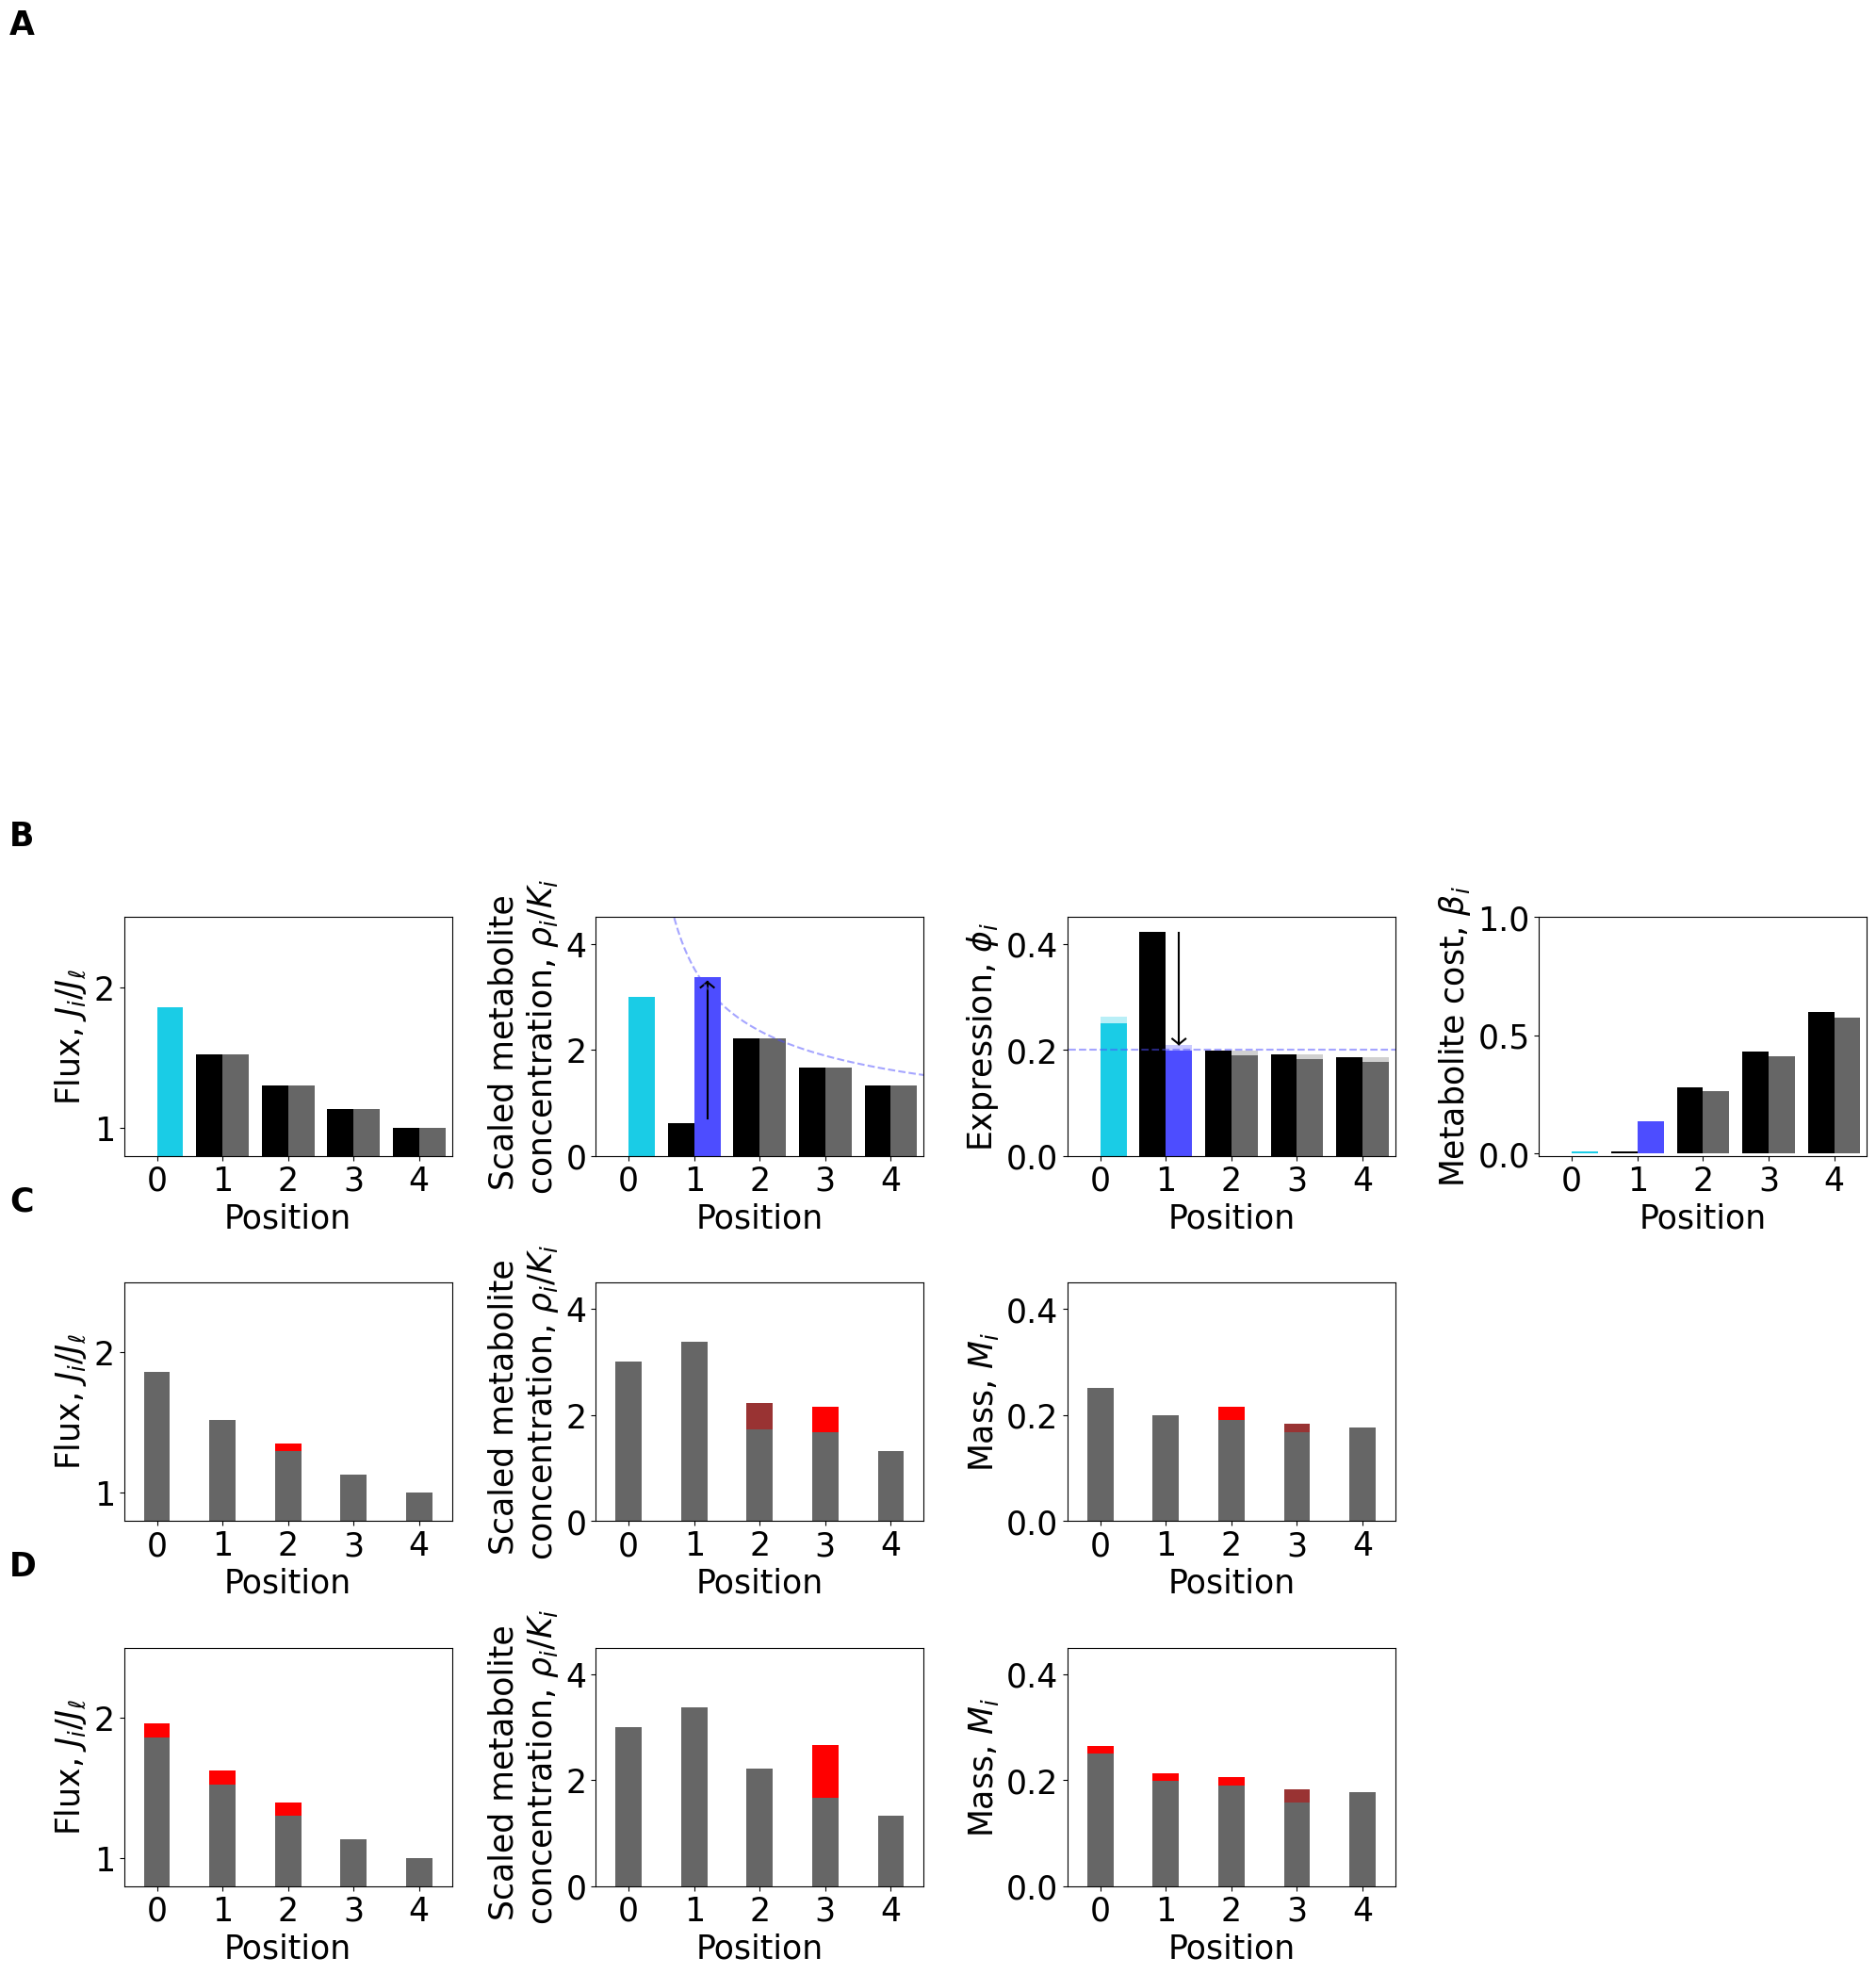

In [12]:
#Figure S1

font = {'size'   : 25}
plt.rc('font', **font)

fig, axs =plt.subplots(3, 4, figsize = (20, 12), gridspec_kw={'width_ratios': [5, 5, 5, 5]})

KMmean = 0.1
kappamean = 100
nu = 0.3
Nenzymes = 5

kappas = np.ones(Nenzymes)*kappamean #
KMs = np.ones(Nenzymes)*KMmean #
lamapprox = np.sum(kappas**(-1))**(-1)

args = np.array([*kappas, *KMs, nu, lamapprox])

res = minimize(wrapper3, -5, args = args)
rhos = rhoIterator(kappas, KMs, nu, np.exp(res.x[0]))
phis = findPhis(kappas, KMs, rhos)
jouts = phis*kappas/(1+KMs/rhos)

nu2 = nu*0.204579#nu*0.27539518 #nu*0.204579
args2 = np.array([*kappas[:-1], *KMs[:-1], nu2, lamapprox])

Nenzymes = 4
res2 = minimize(wrapper3, -5, args = args2)
Nenzymes = 5

rhos2 = rhoIterator(kappas[:-1], KMs[:-1], nu2, np.exp(res2.x[0]))
phis2 = findPhis(kappas[:-1], KMs[:-1], rhos2)
jouts2 = phis2*kappas[:-1]/(1+KMs[:-1]/rhos2)

print(rhos)
print(rhos2)

lambdasup = np.sum(kappas**(-1))**(-1)
print(jouts[0]/lambdasup)

w = 0.4

for row in range(3):
    axs[row, 0].set_xlabel("Position")
    axs[row, 0].set_xlim((-.5, Nenzymes-0.5))
    axs[row, 0].set_ylabel(r"Flux, $J_i/J_\ell$")
    #axs[row, 0].set_yscale("log")
    axs[row, 0].set_ylim((.8, 2.5))

    axs[row, 1].set_xlabel("Position")
    axs[row, 1].set_xlim((-.5, Nenzymes-0.5))
    axs[row, 1].set_ylabel("Scaled metabolite \n"r"concentration, $\rho_i/K_i$")
    axs[row, 1].set_ylim((0, 4.5))

    axs[row, 2].set_xlabel("Position")
    axs[row, 2].set_xlim((-.5, Nenzymes-0.5))
    axs[row, 2].set_ylabel(r"Expression, $\phi_i$")
    #axs[row, 2].set_yscale("log")
    axs[row, 2].set_ylim((0., .45))

    axs[row, 3].set_xlabel("Position")
    axs[row, 3].set_xlim((-.5, Nenzymes-0.5))
    axs[row, 3].set_ylabel(r"Metabolite cost, $\beta_i$")
    axs[row, 3].set_ylim((-0.01, 1))

print(phis)

print(np.sum(phis), np.sum(phis2))

cost = phis/KMs/(rhos/KMs*(1+rhos/KMs))
cost[-1] = 1e-2

cost2 = phis2/KMs[:-1]/(rhos2/KMs[:-1]*(1+rhos2/KMs[:-1]))
cost2[-1] = 1e-2
print(cost, cost2)

axs[0, 0].bar(np.arange(Nenzymes)[::-1]+w/2, jouts/jouts[0], width = w, color = (0.4, 0.4, .4, 1))
#axs[0, 0].bar(1+w/2, (jouts/jouts[0])[-2], width = w, color = (0.3, 0.3, 1, 1))
axs[0, 0].bar(0+w/2, (jouts/jouts[0])[-1], width = w, color = (0.1, 0.8, 0.9, 1))
axs[0, 0].bar(np.arange(Nenzymes)[:0:-1]-w/2, jouts2/jouts2[0], width = w, color = "black")

axs[0, 1].bar(np.arange(Nenzymes)[::-1]+w/2, rhos/KMs, width = w, color = (0.4, 0.4, .4, 1))
axs[0, 1].bar(1+w/2, (rhos/KMs)[-2], width = w, color = (0.3, 0.3, 1, 1))
axs[0, 1].bar(0+w/2, (rhos/KMs[0])[-1], width = w, color = (0.1, 0.8, 0.9, 1))
axs[0, 1].bar(np.arange(Nenzymes)[:0:-1]-w/2, rhos2/KMs[:-1], width = w, color = "black")
axs[0, 1].plot(np.linspace(1+w/2, 1+w/2, 100), np.linspace(rhos[-2]/KMs[0]-.1, rhos2[-1]/KMs[0]+.1,100), "k-")
axs[0, 1].plot(np.linspace(1+w/2, 1.1+w/2, 2), np.linspace(rhos[-2]/KMs[0], rhos[-2]/KMs[0]-.1, 2)-.1, "k-")
axs[0, 1].plot(np.linspace(1+w/2, .9+w/2, 2), np.linspace(rhos[-2]/KMs[0], rhos[-2]/KMs[0]-.1, 2)-.1, "k-")
axs[0, 1].plot(np.linspace(0, 5, 100)+w/2, 1/np.sqrt(KMmean*np.linspace(0, 5, 100)), "--", color = (0.3, 0.3, 1, 1), alpha = 0.5)

axs[0, 2].bar(np.arange(Nenzymes)[::-1]+w/2, phis, width = w, color = (0.4, 0.4, .4, 1))
axs[0, 2].bar(1+w/2, phis[-2], width = w, color = (0.3, 0.3, 1, 1))
axs[0, 2].bar(0+w/2, phis[-1], width = w, color = (0.1, 0.8, 0.9, 1))
axs[0, 2].bar((np.arange(Nenzymes)[::-1]+w/2)[:-2], (phis*phis2[0]/phis[0])[:-2], width = w, color = (0.4, 0.4, .4, 1), alpha = 0.3)
axs[0, 2].bar(1+w/2, (phis*phis2[0]/phis[0])[-2], width = w, color = (0.3, 0.3, 1, 1), alpha = 0.3)
axs[0, 2].bar(0+w/2, (phis*phis2[0]/phis[0])[-1], width = w, color = (0.1, 0.8, 0.9, 1), alpha = 0.3)
#axs[0, 2].bar(np.arange(Nenzymes)[::-1]+w/2, phis*phis2[0]/phis[0], width = w, color = "orange", alpha = 0.3)
axs[0, 2].bar(np.arange(Nenzymes)[:0:-1]-w/2, phis2, width = w, color = "black", alpha = 1.0)
axs[0, 2].plot(np.linspace(-1, 5.5, 100)+w/2, [1/5]*100, "--", color = (0.3, 0.3, 1, 1), alpha = 0.5)
axs[0, 2].plot(np.linspace(1+w/2, 1+w/2, 100), np.linspace(phis[-2]*phis2[0]/phis[0]+0.002, phis2[-1]-.002,100), "k-")
axs[0, 2].plot(np.linspace(1+w/2, 1.1+w/2, 2), np.linspace(phis[-2]*phis2[0]/phis[0], phis[-2]*phis2[0]/phis[0]+0.01, 2)+0.002, "k-")
axs[0, 2].plot(np.linspace(1+w/2, .9+w/2, 2), np.linspace(phis[-2]*phis2[0]/phis[0], phis[-2]*phis2[0]/phis[0]+0.01, 2)+0.002, "k-")

axs[0, 3].bar(np.arange(Nenzymes)[::-1]+w/2, cost, width = w, color = (0.4, 0.4, .4, 1))
axs[0, 3].bar(1+w/2, cost[-2], width = w, color = (0.3, 0.3, 1, 1))
axs[0, 3].bar(0+w/2, cost[-1], width = w, color = (0.1, 0.8, 0.9, 1))
axs[0, 3].bar(np.arange(Nenzymes)[:0:-1]-w/2, cost2, width = w, color = "black")

for ax in axs.flatten():
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels([0, 1, 2, 3, 4])

fig.tight_layout()

for n, ax in enumerate([axs[0, 0], axs[1, 0], axs[2, 0]]):  
    ax.text(-0.35, 1.30, string.ascii_uppercase[n+1], transform=ax.transAxes, weight='bold')

axs[0, 0].text(-0.35, 4.70, string.ascii_uppercase[0], transform=axs[0, 0].transAxes, weight='bold')


deltaj = .5
newjouts = np.copy(jouts)
newjouts[2] = newjouts[2]+deltaj
newrhos = np.copy(rhos)
newrhos[:-1] = (newjouts[1:]-newjouts[:-1])/newjouts[0]
newphis = newjouts/kappas*(1+KMs/newrhos)

axs[1, 0].bar(np.arange(Nenzymes)[::-1], newjouts/newjouts[0], width = w, color = (1, 0, 0, 1))
axs[1, 1].bar(np.arange(Nenzymes)[::-1], newrhos/KMs, width = w, color = (1, 0, 0, 1))
axs[1, 2].bar(np.arange(Nenzymes)[::-1], newphis, width = w, color = (1, 0, 0, 1))

axs[1, 0].bar(np.arange(Nenzymes)[::-1], jouts/jouts[0], width = w, color = (0.6, 0.2, .2, 1))
axs[1, 1].bar(np.arange(Nenzymes)[::-1], rhos/KMs, width = w, color = (0.6, 0.2, .2, 1))
axs[1, 2].bar(np.arange(Nenzymes)[::-1], phis, width = w, color = (0.6, 0.2, .2, 1))

axs[1, 0].bar(np.arange(Nenzymes)[::-1], np.min(np.array([jouts/jouts[0], newjouts/newjouts[0]]), 0), width = w, color = (0.4, .4, .4, 1))
axs[1, 1].bar(np.arange(Nenzymes)[::-1], np.min(np.array([rhos/KMs, newrhos/KMs]), 0), width = w, color = (0.4, .4, .4, 1))
axs[1, 2].bar(np.arange(Nenzymes)[::-1], np.min(np.array([phis, newphis]), 0), width = w, color = (0.4, .4, .4, 1))

axs[1, 3].axis("off")#bar(np.arange(Nenzymes)[::-1], cost, width = w, color = (0.4, 0.4, .4, 1))
axs[1, 2].set_ylabel(r"Mass, $M_i$")

deltaj = 1
newjouts = np.copy(jouts)
newjouts[2:] = newjouts[2:]+deltaj
newrhos = np.copy(rhos)
newrhos[:-1] = (newjouts[1:]-newjouts[:-1])/newjouts[0]
newphis = newjouts/kappas*(1+KMs/newrhos)

axs[2, 0].bar(np.arange(Nenzymes)[::-1], newjouts/newjouts[0], width = w, color = (1, 0, 0, 1))
axs[2, 1].bar(np.arange(Nenzymes)[::-1], newrhos/KMs, width = w, color = (1, 0, 0, 1))
axs[2, 2].bar(np.arange(Nenzymes)[::-1], newphis, width = w, color = (1, 0, 0, 1))

axs[2, 0].bar(np.arange(Nenzymes)[::-1], jouts/jouts[0], width = w, color = (0.6, 0.2, .2, 1))
axs[2, 1].bar(np.arange(Nenzymes)[::-1], rhos/KMs, width = w, color = (0.6, 0.2, .2, 1))
axs[2, 2].bar(np.arange(Nenzymes)[::-1], phis, width = w, color = (0.6, 0.2, .2, 1))

axs[2, 0].bar(np.arange(Nenzymes)[::-1], np.min(np.array([jouts/jouts[0], newjouts/newjouts[0]]), 0), width = w, color = (0.4, .4, .4, 1))
axs[2, 1].bar(np.arange(Nenzymes)[::-1], np.min(np.array([rhos/KMs, newrhos/KMs]), 0), width = w, color = (0.4, .4, .4, 1))
axs[2, 2].bar(np.arange(Nenzymes)[::-1], np.min(np.array([phis, newphis]), 0), width = w, color = (0.4, .4, .4, 1))

axs[2, 3].axis("off")#bar(np.arange(Nenzymes)[::-1], cost, width = w, color = (0.4, 0.4, .4, 1))
axs[2, 2].set_ylabel(r"Mass, $M_i$")

#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/SI_schematic_barplots.pdf", bbox_inches="tight", format = 'pdf')

### the rest of this figure was created in vectornator, not with python

(5000, 42)
(5000, 1000, 3, 20)
(5000, 1000, 6, 20)
(5000, 3, 6, 1, 20)
(5000, 1, 20)


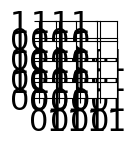

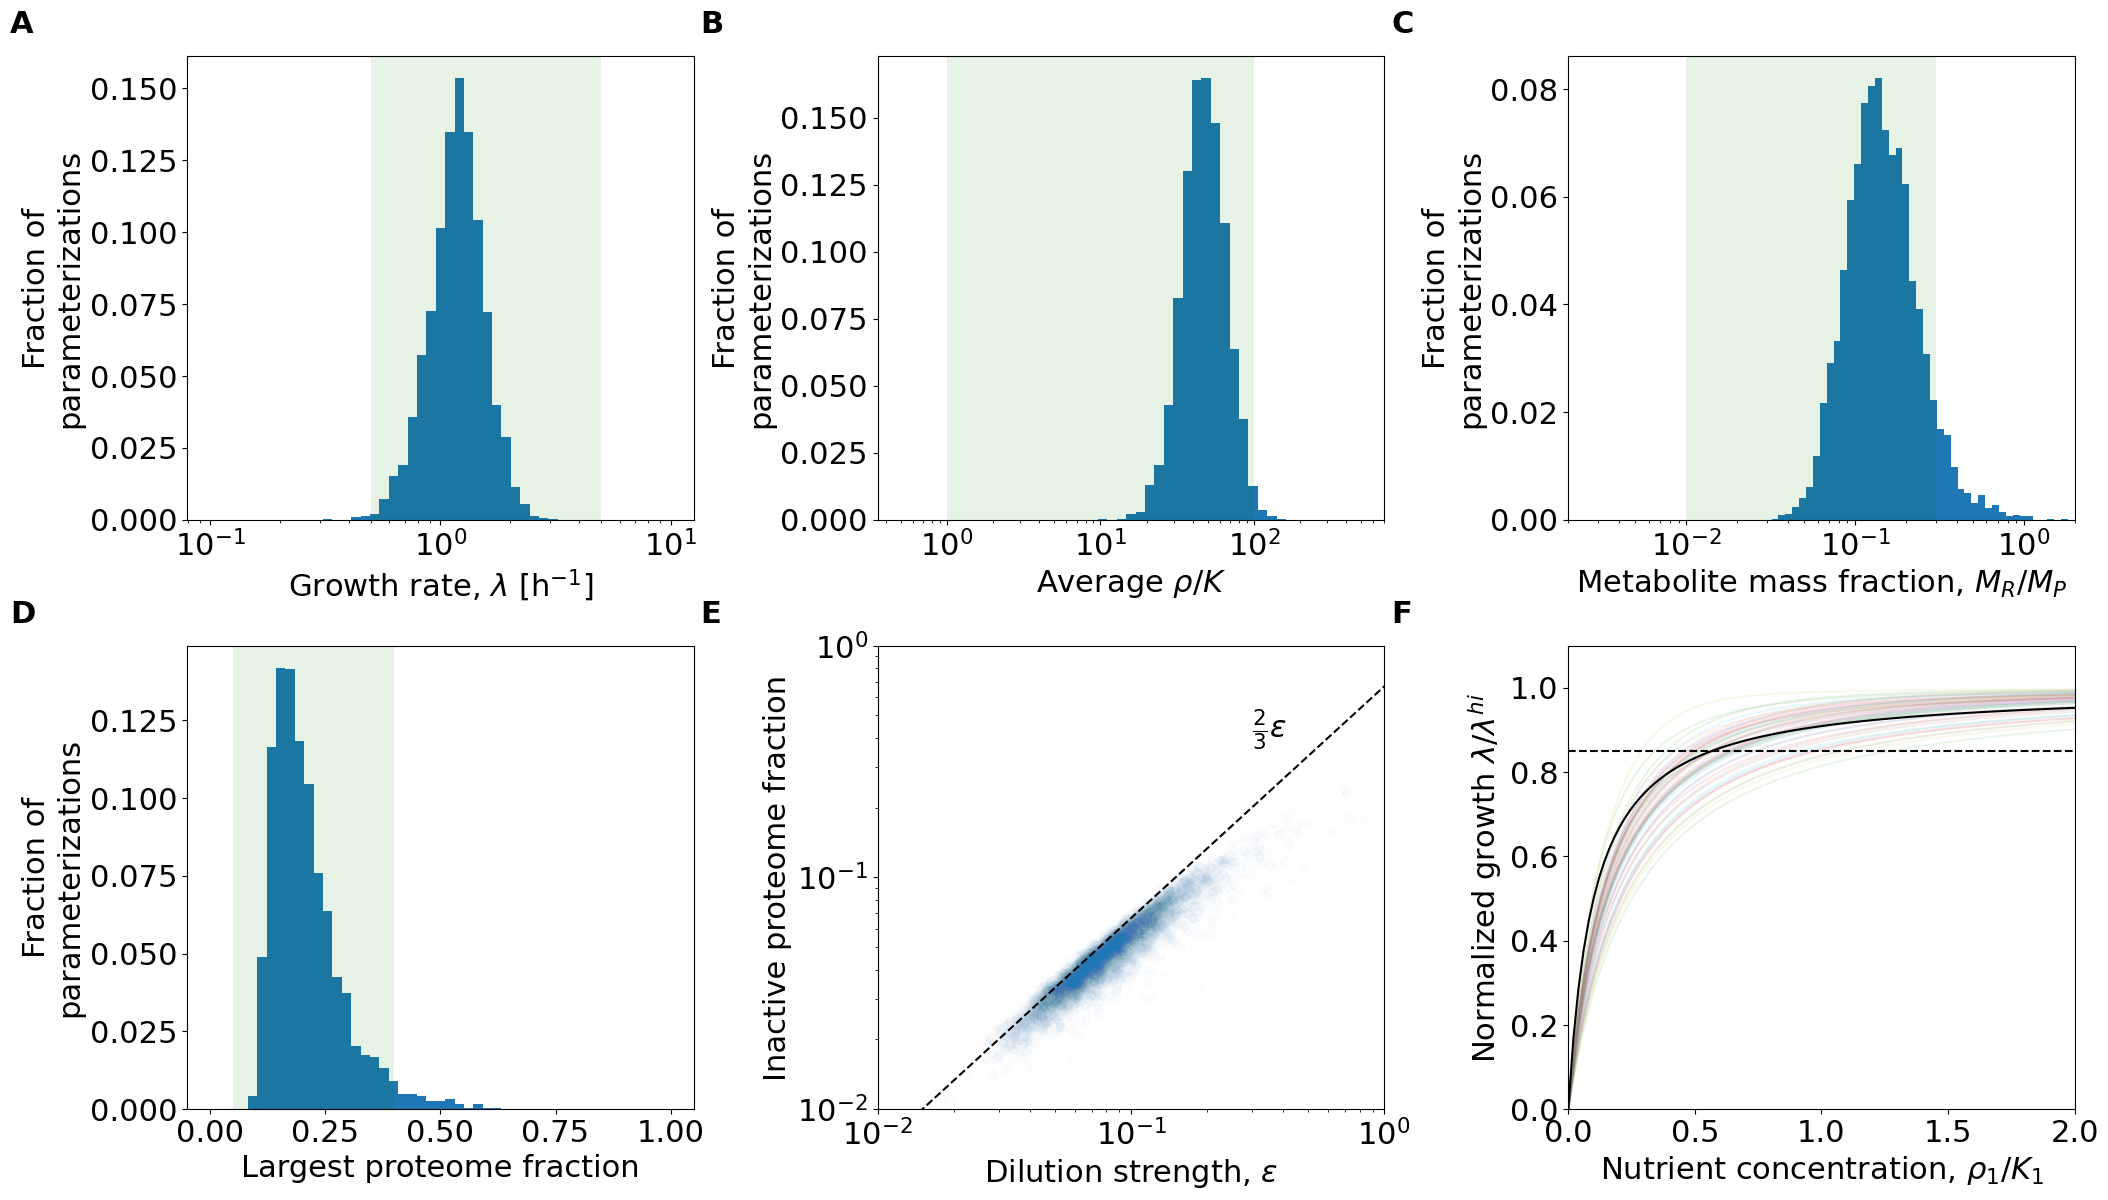

In [13]:
#Figure S2

font = {'size'   : 22}
plt.rc('font', **font)


#fig, axs = plt.subplots(2, 2, figsize = (10, 10))
Nenzymes = 20

fig, axs = plt.subplots(4, 4, figsize = (1, 1))
fig = plt.figure(figsize = (35, 12))
gs = gridspec.GridSpec(2, 5)
#gs.update(wspace=0, hspace=0.15)
axs[0, 0] = plt.subplot(gs[0, 0])
axs[0, 1] = plt.subplot(gs[0, 1])
axs[0, 2] = plt.subplot(gs[0, 2])
axs[1, 0] = plt.subplot(gs[1, 0])
axs[1, 1] = plt.subplot(gs[1, 1])
axs[1, 2] = plt.subplot(gs[1, 2])

filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]

print(np.shape(fullensemble))


efficiencybins = np.logspace(-1, 1, 6)

ilocs = []
ensemble = []

for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    halfgrs[halfgrs<=0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    tenthgrs[tenthgrs<=0] = np.max(tenthgrs)
    
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, :]

#print(np.shape(smallensemble))
efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
efficiencies = efficiencies[:, None, :]
print(np.shape(ensemble))
print(np.shape(efficiencies))


#what are high proteome mass fractions of the largest enzyme correlated with
#fig, axs = plt.subplots(2, 2, figsize = (15, 14))
axs[0, 0].hist(ensemble[:, 0, 5, 0, 0]*10**(-.5), bins = np.logspace(np.log10(0.1), np.log10(10), 50), weights = 0*ensemble[:, 0, 5, 0, 0]+1/(np.shape(ensemble[:, 0, 5, 0, 0])[0]))
axs[0, 0].set_xscale("log")
axs[0,0].set_xlabel("Growth rate, $\lambda$ [h$^{-1}$]")
limits = axs[0,0].get_ylim()
axs[0,0].add_patch(plt.Polygon([[.5, limits[0]], [.5, limits[1]], [5, limits[1]], [5, limits[0]]], facecolor='green', clip_on = True, linewidth = 0, alpha = .1))
axs[0,0].set_ylabel("Fraction of\nparameterizations")

axs[0,1].hist(np.exp(np.mean(np.log(ensemble[:, 0, 3, 0, :]/ensemble[:, 0, 1, 0, :]), 1)), bins = np.logspace(np.log10(.5), np.log10(500), 50), weights = 0*ensemble[:, 0, 5, 0, 0]+1/(np.shape(ensemble[:, 0, 5, 0, 0])[0]))
#axs[0,1].hist(np.mean(1/(1+1/(ensemble[:, 0, 3, 0, :]/ensemble[:, 0, 1, 0, :])), 1), bins = np.linspace(0, 1, 200), weights = 0*ensemble[:, 0, 5, 0, 0]+1/(np.shape(ensemble[:, 0, 5, 0, 0])[0]))
#axs[0,1].hist((ensemble[:, 0, 3, 0, :]/ensemble[:, 0, 1, 0, :]).flatten(), bins = np.logspace(np.log10(.5), np.log10(500), 50))
axs[0,1].set_xscale("log")
#axs[0,1].set_xlabel("Average saturation")
axs[0,1].set_xlabel(r"Average $\rho/K$")#scaled metabolite concentration, 
limits = axs[0,1].get_ylim()
#axs[0,1].set_xlim(0.7, 1)
#axs[0,1].add_patch(plt.Polygon([[0.8, limits[0]], [0.8, limits[1]], [0.95, limits[1]], [0.95, limits[0]]], facecolor='green', clip_on = True, linewidth = 0, alpha = .1))
axs[0,1].add_patch(plt.Polygon([[1, limits[0]], [1, limits[1]], [100, limits[1]], [100, limits[0]]], facecolor='green', clip_on = True, linewidth = 0, alpha = .1))
axs[0,1].set_ylabel("Fraction of\nparameterizations")

axs[0,2].hist(np.sum(ensemble[:, 0, 3, 0, :-1], 1), bins = np.logspace(np.log10(0.02), np.log10(2), 50), weights = 0*ensemble[:, 0, 5, 0, 0]+1/(np.shape(ensemble[:, 0, 5, 0, 0])[0]))
#axs[0,2].hist(np.sum(ensemble[:, 0, 3, 0, :-1], 1), bins = np.logspace(np.log10(0.001), np.log10(2), 50))
axs[0,2].set_xscale("log")
axs[0,2].set_xlabel("Metabolite mass fraction, $M_R/M_P$")
axs[0,2].set_xlim(2e-3, 2)
limits = axs[0,2].get_ylim()
axs[0,2].add_patch(plt.Polygon([[.01, limits[0]], [.01, limits[1]], [.3, limits[1]], [.3, limits[0]]], facecolor='green', clip_on = True, linewidth = 0, alpha = .1))
axs[0,2].set_ylabel("Fraction of\nparameterizations")

axs[1,0].hist(np.max(ensemble[:, 0, 4, 0, :], 1), bins = np.linspace(0, 1, 50), weights = 0*ensemble[:, 0, 5, 0, 0]+1/(np.shape(ensemble[:, 0, 5, 0, 0])[0]))
#axs[1,0].hist(np.max(ensemble[:, 0, 4, 0, :], 1), bins = np.linspace(0, 1, 50))
axs[1,0].set_xlabel("Largest proteome fraction")
limits = axs[1,0].get_ylim()
axs[1,0].add_patch(plt.Polygon([[.4, limits[0]], [.4, limits[1]], [.05, limits[1]], [.05, limits[0]]], facecolor='green', clip_on = True, linewidth = 0, alpha = .1))
axs[1,0].set_ylabel("Fraction of\nparameterizations")

epsilons = np.sqrt(np.sum(fullensemble[:, 0, 1, :-1], axis = 1))
epsilons2 = np.sum(np.sqrt(fullensemble[:, 0, 1, :-1]*fullensemble[:, 0, 4, :-1]), axis = 1)


#axs[1,1].scatter(2/3*epsilons, np.sum(fullensemble[:, 0, 4, :-1]*(1-1/(1+fullensemble[:, 0, 1, :-1]/fullensemble[:, 0, 3, :-1])), axis = 1), alpha = 0.01)
axs[1,1].scatter(epsilons2, np.sum(fullensemble[:, 0, 4, :-1]*(1-1/(1+fullensemble[:, 0, 1, :-1]/fullensemble[:, 0, 3, :-1])), axis = 1), alpha = 0.01)
axs[1,1].set_xscale("log")
axs[1,1].set_yscale("log")
axs[1,1].set_xlabel(r"Dilution strength, $\epsilon$")
axs[1,1].set_ylabel("Inactive proteome fraction")
axs[1,1].plot([1e-2, 3e0], [1e-2*2/3, 3e0*2/3], "k--")
axs[1,1].text(3e-1, 4e-1, r"$\frac{2}{3}\epsilon$")
axs[1,1].set_xlim(1e-2, 1e0)
axs[1,1].set_ylim(1e-2, 1e0)
                 
axs[1,2].plot(fullensemble[::101, :, 3, -1].T/fullensemble[::101, 0, 1, -1], fullensemble[::101, :, 5, 0].T/fullensemble[::101, 0, 5, 0], alpha =0.1)
axs[1,2].set_xlim(0, 2)
axs[1,2].set_ylim(0, 1.1)
axs[1,2].set_xlabel(r"Nutrient concentration, $\rho_1/K_1$")
axs[1,2].set_ylabel(r"Normalized growth $\lambda/\lambda^{hi}$")
K = 1/10
axs[1,2].plot(np.linspace(0, 2, 100), 1/(1+K/np.linspace(0, 2, 100)), "k-")
axs[1,2].plot([0, 2], [1-0.1-1/Nenzymes]*2, "k--")

fig.tight_layout()

for n, ax in enumerate([axs[0,0], axs[0,1], axs[0,2], axs[1,0], axs[1,1], axs[1,2]]):  
    ax.text(-0.35, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')


#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/SI_validity.pdf", bbox_inches="tight", format = 'pdf')
#effect of saturation is negligible - the largest mass fraction is given by max(1/kappa/(sum(1/kappa)))

-7.722557541502939
-7.722557541502939


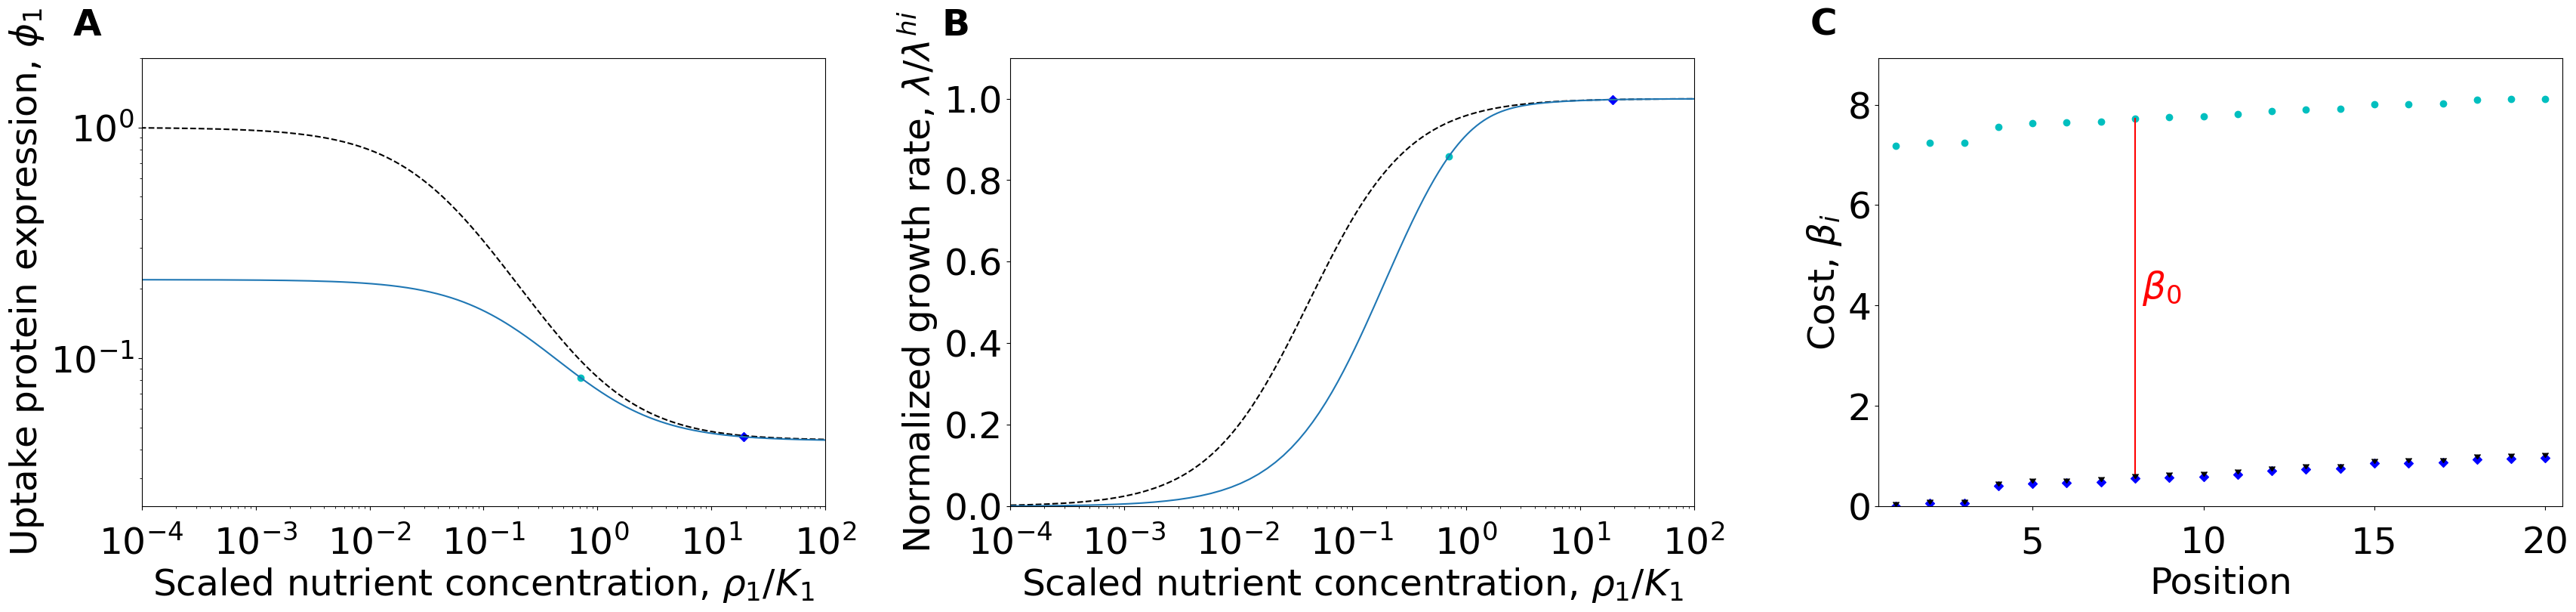

In [14]:
#Figure S3
### The role of the nutrient for a single chain

###Analytical solution for the nutrient-limiting boundary condition
def ConstrainedIterator(kappas, KMs, rho0approx, phiup_0, eps):
    rhos = rhoIteratorInternal(kappas, KMs, rho0approx)
    KM1 = KMs[-1]
    kappa1 = kappas[-1]
    phi1 = phiup_0
    Js = np.cumsum(rhos)-rhos+1
    Ms = Js/kappas[:-1]*(1+KMs[:-1]/rhos)
    sumM = np.sum(Ms)
    J1 = Js[-1]+rhos[-1]
    nu = -((J1*KM1*(-1 + phi1 + eps*phi1))/((1 + eps)*(J1*(-1 + phi1) + kappa1*phi1*sumM)))
    #nu1 = (-J1*KM1-eps*J1*KM1+J1*KM1*phi1+eps*J1*KM1*phi1+eps*J1*KM1*phi1+kappa1*KM1*phi1*sumM+eps*kappa1*KM1*phi1*sumM-np.sqrt(-4*(J1*KM1**2-J1*KM1**2*phi1-eps*J1*KM1**2*phi1)*(eps*J1-eps*J1*phi1-eps*kappa1*phi1*sumM)+(J1*KM1+eps*J1*KM1-J1*KM1*phi1-eps*J1*KM1*phi1-eps*J1*KM1*phi1-kappa1*KM1*phi1*sumM-eps*kappa1*KM1*phi1*sumM)**2))/(2*(eps*J1-eps*J1*phi1-eps*kappa1*phi1*sumM))
    #nu2 = (-J1*KM1-eps*J1*KM1+J1*KM1*phi1+eps*J1*KM1*phi1+eps*J1*KM1*phi1+kappa1*KM1*phi1*sumM+eps*kappa1*KM1*phi1*sumM+np.sqrt(-4*(J1*KM1**2-J1*KM1**2*phi1-eps*J1*KM1**2*phi1)*(eps*J1-eps*J1*phi1-eps*kappa1*phi1*sumM)+(J1*KM1+eps*J1*KM1-J1*KM1*phi1-eps*J1*KM1*phi1-eps*J1*KM1*phi1-kappa1*KM1*phi1*sumM-eps*kappa1*KM1*phi1*sumM)**2))/(2*(eps*J1-eps*J1*phi1-eps*kappa1*phi1*sumM))
    #print(nu-nu1, nu-nu2)
    #nu = max(nu1, nu2)
    rhos = np.append(rhos, nu)
    return rhos

font = {'size'   : 35}
plt.rc('font', **font)

fig, axs =plt.subplots(1, 3, figsize = (35, 9))


Nenzymes = 20

kappamean = 130
KMmean = .0001

kappas = fullensemble[0, 0, 0, :]#np.random.lognormal(np.log(kappamean), 3, Nenzymes) #np.ones(Nenzymes)*kappamean #
KMs = fullensemble[0, 0, 1, :]# np.random.lognormal(np.log(KMmean), 2.5, Nenzymes) #np.ones(Nenzymes)*KMmean #
#bs = fullensemble[0, 0, 2, :]#np.ones(Nenzymes)
nu = fullensemble[0, 0, 3, -1]*100#200*KMs[-1] #0.03*KMmean
lamapprox = fullensemble[0, 0, 5, 0]
phi1 = fullensemble[0, 0, 4, -1]

args = np.array([*kappas, *KMs, nu, lamapprox])
res = minimize(wrapper3, -5, args = args)
rhos = rhoIterator(kappas, KMs, nu, np.exp(res.x[0]))
phis = findPhis(kappas, KMs, rhos)
jouts = calculatejout(rhos, phis, kappas, KMs)

results = []
resultsopt = []
print(res.x[0])
for logrho0 in res.x[0]-np.logspace(-13, 2, 1000):
    rhosC = ConstrainedIterator(kappas, KMs, np.exp(logrho0), phis[-1]/(1+1*5/(1+5*200)), 4)
    phisC = findPhis(kappas, KMs, rhosC)
    #print(phis[-1], phisC[-1])
    joutsC = calculatejout(rhosC, phisC, kappas, KMs)
    results.append([rhosC, phisC, joutsC])
    
    rhosopt = BCIterator(kappas, KMs, np.exp(logrho0))
    phisopt = findPhis(kappas, KMs, rhosopt)
    #print(phis[-1], phisC[-1])
    joutsopt = calculatejout(rhosopt, phisopt, kappas, KMs)
    resultsopt.append([rhosopt, phisopt, joutsopt])
    
    
results = []
print(res.x[0])
for logrho0 in res.x[0]-np.logspace(-13, 2, 1000):#+2.48370e-2:
    rhosC = ConstrainedIterator(kappas, KMs, np.exp(logrho0), phis[-1]/(1+1*5/(1+5*200)), 4)
    phisC = findPhis(kappas, KMs, rhosC)
    #print(phis[-1], phisC[-1])
    joutsC = calculatejout(rhosC, phisC, kappas, KMs)
    results.append([rhosC, phisC, joutsC])

results = np.array(results)
resultsopt = np.array(resultsopt)

cutoff = np.min(np.where(results[:, 0, -1]>0))
results = results[cutoff:]

i0 = 0
iref = 740-cutoff
imedium = 870-cutoff

axs[0].plot(results[iref, 0, -1]/KMs[-1], results[iref, 1, -1], "bD")
axs[0].plot(results[imedium, 0, -1]/KMs[-1], results[imedium, 1, -1], "co")
axs[0].plot(resultsopt[500:, 0, -1]/KMs[-1], resultsopt[500:, 1, -1], "k--")#, label = "optimal expression")
axs[0].plot(results[:, 0, -1]/KMs[-1], results[:, 1, -1])#, label = "constrained expression")
#axs[0].plot(results[:, 0], results[:, 2])
axs[0].set_xscale("log")
#axs[0].set_xlabel(r"Nutrient saturation $\rho_1/K_1$")
axs[0].set_xlabel(r"Scaled nutrient concentration, $\rho_1/K_1$")
axs[0].set_ylabel(r"Uptake protein expression, $\phi_1$")
axs[0].set_yscale("log")
#axs[0].legend(loc = "upper left")
axs[0].set_xlim(1/10000, 100)
axs[0].set_ylim(results[iref, 1, -1]/2, 2)

axs[1].plot(results[iref, 0, -1]/KMs[-1], results[iref, 2, 0]/results[0, 2, 0], "bD")
axs[1].plot(results[imedium, 0, -1]/KMs[-1], results[imedium, 2, 0]/results[0, 2, 0], "co")
axs[1].plot(resultsopt[500:, 0, -1]/KMs[-1], resultsopt[500:, 2, 0]/results[0, 2, 0], "k--")#, label = "optimal expression")
axs[1].plot(results[:, 0, -1]/KMs[-1], results[:, 2, 0]/results[0, 2, 0])#, label = "constrained expression")
axs[1].set_xscale("log")
axs[1].set_ylabel(r"Normalized growth rate, $\lambda/\lambda^{hi}$")
#axs[1].set_xlabel(r"Nutrient saturation $\rho_1/K_1$")
axs[1].set_xlabel(r"Scaled nutrient concentration, $\rho_1/K_1$")
axs[1].set_xlim(1/10000, 100)
axs[1].set_ylim(0, 1.1)


betaref0 = results[i0, 1, :]/(results[i0, 0, :]*(1+results[i0, 0, :]/KMs))   
betaref0[-1] = 0
betaref = results[iref, 1, :]/(results[iref, 0, :]*(1+results[iref, 0, :]/KMs))   
betaref[-1] = 0
betamedium = results[imedium, 1, :]/(results[imedium, 0, :]*(1+results[imedium, 0, :]/KMs))
betamedium[-1] = betamedium[12]-betaref[12]

axs[2].scatter(np.arange(Nenzymes)[::-1]+1, betaref, marker = "D", c = "b")
axs[2].scatter(np.arange(Nenzymes)[::-1]+1, betamedium, marker = "o", c = "c")
axs[2].plot([Nenzymes-12, Nenzymes-12], [betaref[12], betamedium[12]], "r-")
axs[2].text(Nenzymes-11.8, betaref[12]/2+betamedium[12]/2, r"$\beta_0$", color = "r")
#axs[2].set_yscale("log")
axs[2].set_xlim(0.5, Nenzymes+.5)
axs[2].set_ylim(0, 1.1*results[imedium, 1, 0]/(results[imedium, 0, 0]*(1+results[imedium, 0, 0]/KMs[0])))
axs[2].set_xlabel(r"Position")
axs[2].set_xticks([5, 10, 15, 20])
axs[2].set_xticklabels([5, 10, 15, 20])
axs[2].set_ylabel(r"Cost, $\beta_i$")
simplebetas = np.cumsum(results[iref, 1, ::-1])[:-1]
simplebetas = np.append(simplebetas[::-1], 0)
axs[2].plot(np.arange(Nenzymes)[::-1]+1, simplebetas, marker = 7, color = "k", linestyle = "none")

for ax in axs:
    ax.tick_params(axis='x', which='major', pad=15)
    
for n, ax in enumerate(axs):  
    ax.text(-0.1, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')


fig.tight_layout()
#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/SI_constraints.pdf", bbox_inches="tight", format = 'pdf')

(5000, 42)
(5000, 1000, 3, 20)
(5000, 1000, 6, 20)


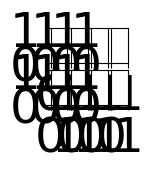

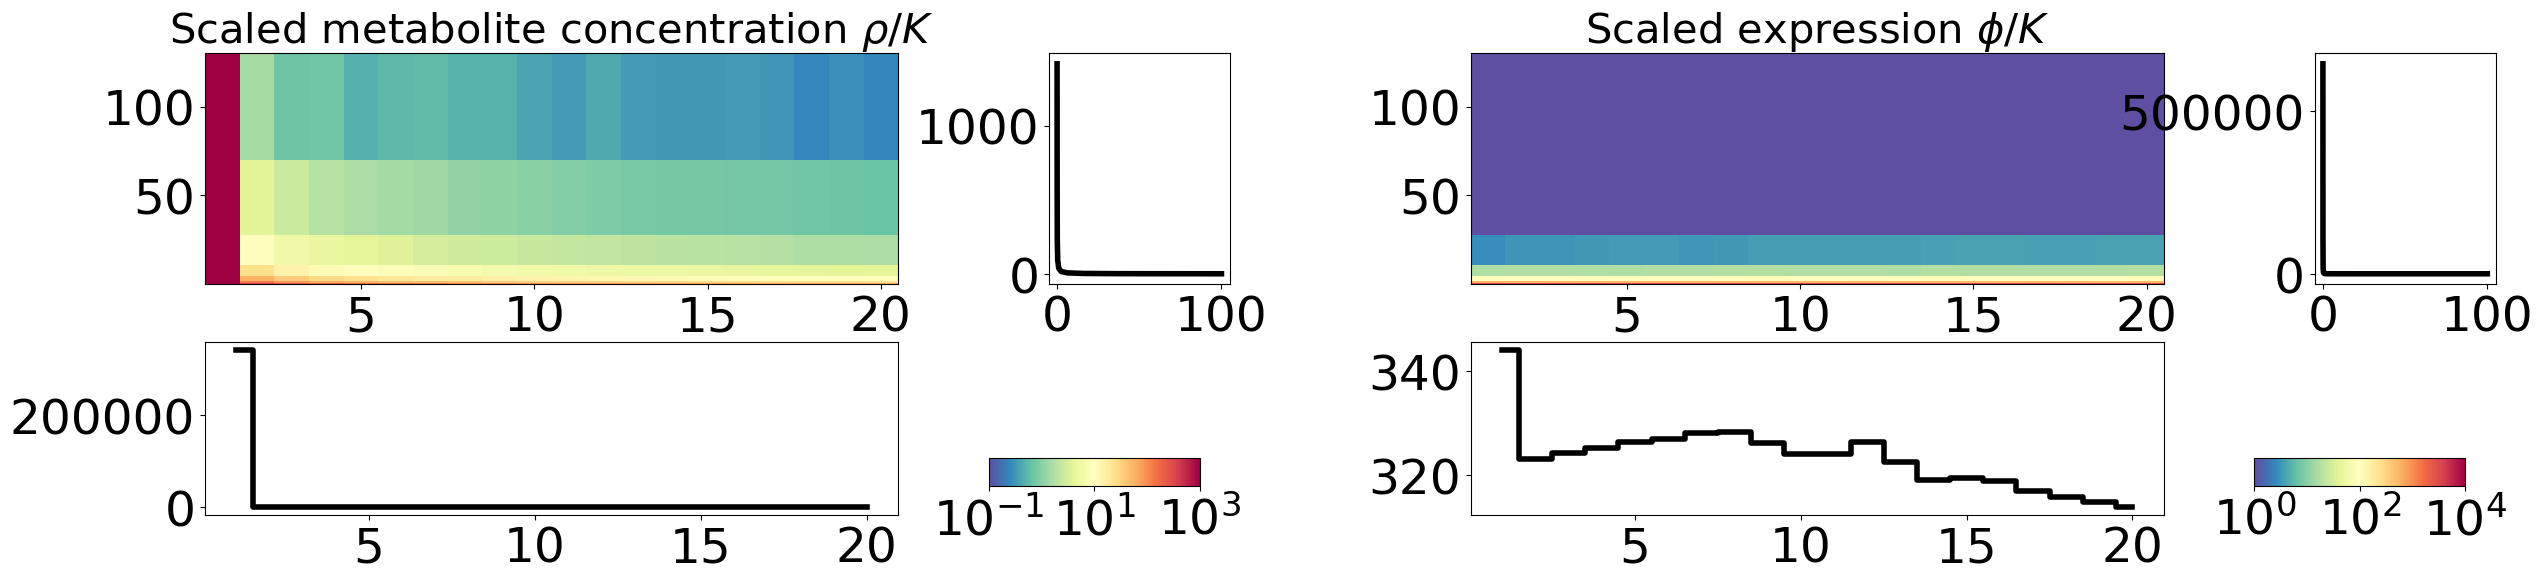

In [15]:
#Illustration of the ensemble in nutrient rich medium as a function of enzyme quality q and reaction position.
#Box must be executed to define plotting properties and plotting functions, but is not part of the final figures. 

fig, axs = plt.subplots(2, 4, figsize = (1, 1))
fig = plt.figure(figsize = (35, 15))
gs = gridspec.GridSpec(40, 90)
gs.update(wspace=0, hspace=0)

axs[0, 0] = plt.subplot(gs[0:8, 10:33])
axs[1, 0] = plt.subplot(gs[10:16, 10:33])
axs[0, 1] = plt.subplot(gs[0:8, 38:44])
axs[1, 1] = plt.subplot(gs[14:15, 36:43])

axs[0, 2] = plt.subplot(gs[0:8, 52:75])
axs[1, 2] = plt.subplot(gs[10:16, 52:75])
axs[0, 3] = plt.subplot(gs[0:8, 80:86])
axs[1, 3] = plt.subplot(gs[14:15, 78:85])

Nenzymes = 20
font = {'size'   : 30}
plt.rc('font', **font)

filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]

print(np.shape(fullensemble))

meancolors = ["k", "dimgrey"]

KMmean = np.exp(np.mean(np.log(fullensemble[:, 0, 1, :])))
efficiencybins = np.logspace(-2.2 , 2.2, 12)
efficiencybins2 = np.copy(efficiencybins)
ilocs = []
ensemble = []

for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    halfgrs[halfgrs<=0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    tenthgrs[tenthgrs<=0] = np.max(tenthgrs)
    
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, :]

efficiencies = np.sqrt(fullensemble[:, 0, 0, :].T*fullensemble[:, 0, 1, :].T/fullensemble[:, 0, 5, 0]).T/np.sqrt(KMmean*Nenzymes)
efficiencies = efficiencies[:, None, :]

branch = 0
colormeshrho = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
colormeshphi = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
for i in range(np.shape(efficiencybins)[0]-1):
    mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
    fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
    maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
    logsaturation = np.log10(maskeddata[:, 0, 3, :]/maskeddata[:, 0, 1, :])
    logexpression = np.log10(maskeddata[:, 0, 4, :]/maskeddata[:, 0, 1, :])
    colormeshrho[:, i] = np.nanmean(logsaturation, 0)
    colormeshphi[:, i] = np.nanmean(logexpression, 0)
    
heatmap = axs[0, 0].pcolormesh(np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshrho.T, cmap = cm, vmin = -1, vmax = 3)
heatmap2 = axs[0, 2].pcolormesh(np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshphi.T, cmap = cm, vmin = 0, vmax = 4)
axs[0, 0].set_title(r'Scaled metabolite concentration $\rho/K$')
axs[0, 2].set_title(r'Scaled expression $\phi/K$')

axcb = axs[1, 1]
cb = fig.colorbar(heatmap, orientation='horizontal', cax=axcb)#, label = r"$\rho/K$")
axcb.set_xticks([-1, 1, 3])
axcb.set_xticklabels([r"$10^{-1}$", r"$10^{1}$", r"$10^{3}$"])

axcb2 = axs[1, 3]
fig.colorbar(heatmap2, orientation='horizontal', cax=axcb2)#, label = r"$\phi/K$")
axcb2.set_xticks([0, 2, 4])
axcb2.set_xticklabels([r"$10^{0}$", r"$10^{2}$", r"$10^{4}$"])

shift = 0
colors = ["k", "r"]
effs = ["L", "H"]
effcolors = ["b", "orange"]


def filtered(data):
    """visually smoothes heatmaps constructed from ensemble averages."""
    logdata = np.log(data[:-1])
    if np.max(logdata)-np.min(logdata)<0.5:
        filtereddata = savgol_filter(logdata, 8, 1)
        final = np.copy(data)
        final[:-1] = np.exp(filtereddata)
    else:
        if np.shape(data)[0]>15:
            filtereddata = savgol_filter(logdata, 10, 3)
            if np.any((logdata-filtereddata)>0.02):
                filtereddata[:10] = savgol_filter(logdata[:10], 7, 3)
                filtereddata[10] = logdata[10]
                filtereddata[11:] = savgol_filter(logdata[11:], 7, 3)
            final = np.copy(data)
            final[:-1] = np.exp(filtereddata)
        else:
            filtereddata = savgol_filter(logdata[1:], 7, 3)
            final = np.copy(data)
            final[1:-1] = np.exp(filtereddata)
    return final

for gr in range(1):
    meanN = np.nanmean(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    stdN = np.nanstd(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    
    efficiencybins = np.logspace(-5, 5, 2)
    meanNs = []
    stdNs = []
    meanNs2 = []
    stdNs2 = []
    piefractions = []
    for i in range(np.shape(efficiencybins)[0]-1):
        #if i%6==3:
        mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
        fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
        maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
        logsaturation = np.log10(maskeddata[:, gr, 3, :]/maskeddata[:, 0, 1, :])
        logexpression = np.log10(maskeddata[:, gr, 4, :]/maskeddata[:, 0, 1, :])
        meanNs.append(10**np.nanmean(logsaturation, 0))
        stdNs.append(10**np.nanstd(logsaturation, 0))
        meanNs2.append(10**(np.nanmean(logexpression, 0)))
        stdNs2.append(10**(np.nanstd(logexpression, 0)))
        
        axs[1, 0].step(np.arange(20)[::-1]+1+shift, filtered(meanNs[-1]), meancolors[i], where = "mid", linewidth = 4)
        axs[1, 2].step(np.arange(20)[::-1]+1+shift, filtered(meanNs2[-1]), meancolors[i], where = "mid", linewidth = 4)
        piefractions.append(np.nanmean(np.nansum(maskeddata[:, gr, 4, :], -1))) 

    axs[0, 1].plot(np.sqrt(efficiencybins2[1:]*efficiencybins2[:-1]), 10**np.mean(colormeshrho[:-1, :], 0), meancolors[i], linewidth = 4)
    axs[0, 3].plot(np.sqrt(efficiencybins2[1:]*efficiencybins2[:-1]), 10**np.mean(colormeshphi[:-1, :], 0), meancolors[i], linewidth = 4)

    x5, y5, z5 = np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins2[1:]*efficiencybins2[:-1]), colormeshrho.T
    x6, y6, z6 = np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins2[1:]*efficiencybins2[:-1]), colormeshphi.T

for ax in axs.flatten():
    ax.set_yscale("log")

axs[0, 1].set_xlim(0.05, 20) 
axs[0, 3].set_xlim(0.05, 20)
axs[0, 1].set_xscale("log")
axs[0, 3].set_xscale("log")

for ax in [axs[0, 0], axs[1, 0], axs[0, 2], axs[1, 2]]:
    ax.set_xlim(0.5, 20.5)
    ax.set_xticks([5, 10, 15, 20])

axs[0, 0].set_ylim(0.1, 10)
axs[0, 2].set_ylim(0.1, 10)

axs[1, 0].set_ylim(1e1, 2e3)
axs[1, 2].set_ylim(1e1, 2e3) 
axs[0, 1].set_ylim(1e-2, 1e4)
axs[0, 3].set_ylim(1e-1, 1e5) 

axs[1, 0].set_xlabel("Position")
axs[1, 2].set_xlabel("Position")


axs[0, 0].yaxis.set_tick_params(which='major', length=17)
axs[0, 0].annotate('', xy=(-0.02, -.06), xycoords='axes fraction', xytext=(-0.02, .48), arrowprops=dict(arrowstyle="->", color='k'))
axs[0, 0].annotate('', xy=(-0.02, 1.06), xycoords='axes fraction', xytext=(-0.02, .51), arrowprops=dict(arrowstyle="->", color='k'))
axs[0, 0].text(-1.3, 2.5, "H")
axs[0, 0].text(-1.2, 1/4, "L")
axs[0, 2].yaxis.set_tick_params(which='major', length=17)
axs[0, 2].annotate('', xy=(-0.02, -.06), xycoords='axes fraction', xytext=(-0.02, .48), arrowprops=dict(arrowstyle="->", color='k'))
axs[0, 2].annotate('', xy=(-0.02, 1.06), xycoords='axes fraction', xytext=(-0.02, .51), arrowprops=dict(arrowstyle="->", color='k'))
axs[0, 2].text(-1.3, 2.5, "H")
axs[0, 2].text(-1.2, 1/4, "L")

axs[1, 0].add_patch(plt.Polygon([[0.5, 1e-3], [0.5, 1e5], [1.3, 1e5], [1.3, 1e-3]],facecolor='silver', clip_on=True, linewidth = 0, alpha = 0.5))
axs[1, 2].add_patch(plt.Polygon([[0.5, 1e-1], [0.5, 1.5e4], [.8, 1.5e4], [.8, 1e-1]],facecolor='silver', clip_on=True, linewidth = 0, alpha = 0.5))
 
axs[0, 0].set_ylabel("Scaled\nquality $q$")
axs[0, 2].set_ylabel("Scaled\nquality $q$")
axs[0, 1].set_xlabel("$q$")
axs[0, 3].set_xlabel("$q$")
axs[1, 0].set_ylabel(r"$\rho/K$")
axs[1, 2].set_ylabel(r"$\phi/K$")
axs[0, 1].set_ylabel(r"$\rho/K$")
axs[0, 3].set_ylabel(r"$\phi/K$")


axlabel = plt.subplot(gs[15, 0])
axlabel.axis("off")
axlabel.text(5, 17, "A", weight = 'bold')
axlabel.text(33.5, 17, "B", weight = 'bold')
axlabel.text(5, 6, "C", weight = 'bold')
axlabel.text(47, 17, "D", weight = 'bold')
axlabel.text(75.5, 17, "E", weight = 'bold')
axlabel.text(47, 6, "F", weight = 'bold')

fig.tight_layout()

#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/MainText2.pdf", bbox_inches="tight", format = 'pdf')

(5000, 42)
(5000, 1000, 3, 20)
(5000, 1000, 6, 20)
(5000, 42)
(5000, 1000, 3, 20)
(1, 1000, 6, 20)
(5000,)
(1, 3, 6, 1, 20)
(1, 1, 20)
(5000, 42)
(5000, 1000, 3, 20)
(1, 1000, 6, 20)
(5000,)
(1, 3, 6, 1, 20)
(1, 1, 20)
(5000, 42)
(5000, 1000, 3, 20)
(1, 1000, 6, 20)
(5000,)
(1, 3, 6, 1, 20)
(1, 1, 20)
(5000, 42)
(5000, 1000, 3, 20)
(5000, 1000, 6, 20)
(5000,)
(5000, 3, 6, 1, 20)
(5000, 1, 20)
rho, rich 0.976561254618242 42.66439963882552
phi, rich 0.981969751502966 55.46235262173441
rho, poor 0.9125309326613587 11.432613041687583
phi, poor 0.9122104948615268 11.39088320890599
(5000, 20)
(5000, 20)
(5000, 3, 6, 1, 20)
(5000, 1, 20)
(5000, 19)


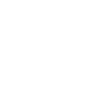

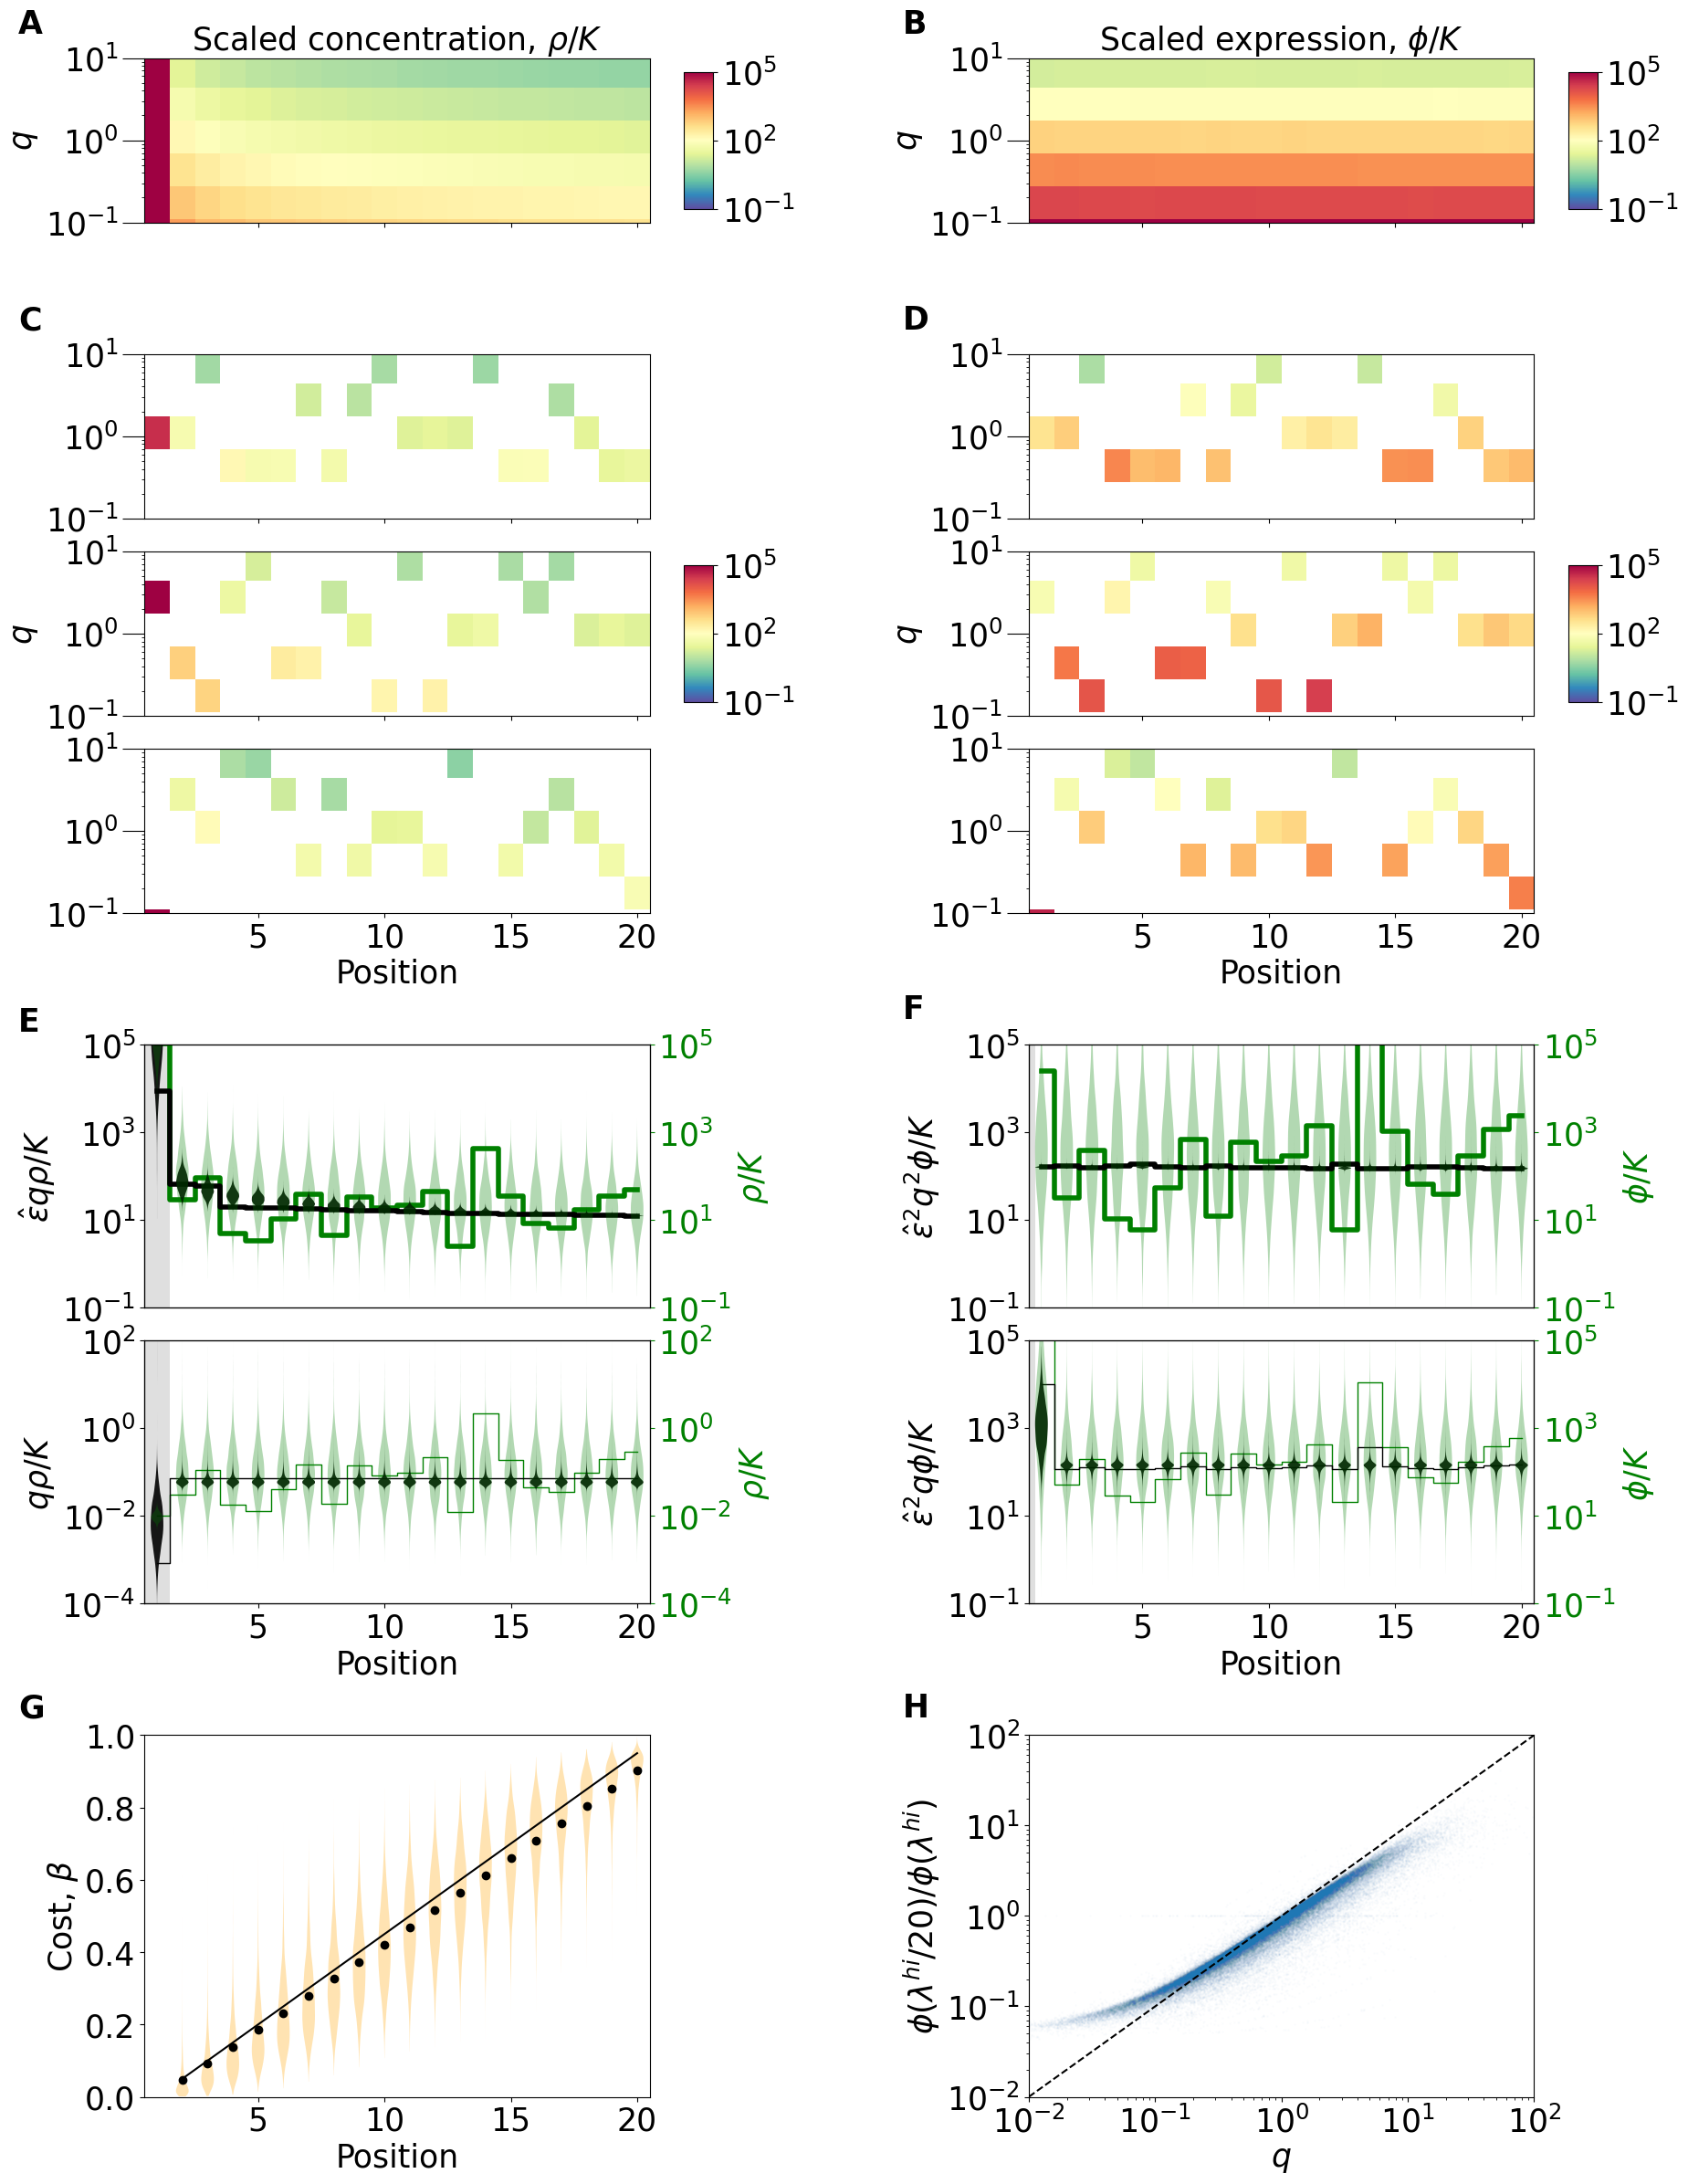

In [16]:
#### Nutrient limitation SI
#fig, axs = plt.subplots(2, 2, figsize = (10, 10))
Nenzymes = 20
font = {'size'   : 25}
plt.rc('font', **font)
fig, axs = plt.subplots(9, 4, figsize = (1, 1))
for ax in axs.flatten():
    ax.axis("off")

fig = plt.figure(figsize = (50, 29))
gs = gridspec.GridSpec(21, 28)
gs.update(wspace=0, hspace=0.5)

axs[0, 0] = plt.subplot(gs[0:2, 0:4])
axs[0, 1] = plt.subplot(gs[0:2, 7:11])

axs[1, 0] = plt.subplot(gs[3:5, 0:4])
axs[1, 1] = plt.subplot(gs[3:5, 7:11])
axs[2, 0] = plt.subplot(gs[5:7, 0:4])
axs[2, 1] = plt.subplot(gs[5:7, 7:11])
axs[3, 0] = plt.subplot(gs[7:9, 0:4])
axs[3, 1] = plt.subplot(gs[7:9, 7:11])

axs[0, 2] = plt.subplot(gs[17:23, 0:4])
axs[3, 2] = plt.subplot(gs[17:23, 7:11])

axs[1, 2] = plt.subplot(gs[10:13, 0:4])
axs[2, 2] = plt.subplot(gs[13:16, 0:4])
axs[1, 3] = plt.subplot(gs[10:13, 7:11])
axs[2, 3] = plt.subplot(gs[13:16, 7:11])

filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]

epsilons = np.sum(np.sqrt((fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]).T/np.sum(1/fullensemble[:, 0, 0, :], 1)), 0)
epsilonshat = epsilons/np.exp(np.mean(np.log(epsilons)))

print(np.shape(fullensemble))

KMmean = np.exp(np.mean(np.log(fullensemble[:, 0, 1, :])))

heatmap = axs[0, 0].pcolormesh(x5, y5, z5, cmap = cm, vmin = -1, vmax = 5)
heatmap2 = axs[0, 1].pcolormesh(x6, y6, z6, cmap = cm, vmin = -1, vmax = 5)


loc = [2, 1, 0]
for ind in range(3):
    filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

    fullensemble = np.load(data_folder+filename)
    parameters = np.load(data_folder+"physiologicalParameterset.npy")
    print(np.shape(parameters))
    print(np.shape(fullensemble))

    parameterensemble = np.ones(np.shape(fullensemble))
    parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
    parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

    fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)
    fullensemble = fullensemble[loc[ind]][None, :, :, :]
    print(np.shape(fullensemble))

    efficiencybins = np.logspace(-1.4, 1.4, 8)#np.logspace(-1, 1, 6)

    ilocs = []
    ensemble = []

    for j in range(np.shape(fullensemble)[0]):
        maxgr = fullensemble[j, 0, 5, 0]
        halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
        halfgrs[halfgrs<=0] = np.max(halfgrs)
        tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/20.1).T
        tenthgrs[tenthgrs<=0] = np.max(tenthgrs)

        iloc = np.where(halfgrs == np.nanmin(halfgrs))
        iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
        ilocs.append(iloc[0][0])
        ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
        #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

    ilocs = np.array(ilocs)
    ensemble = np.array(ensemble)[:, :, :, None, :]

    #print(np.shape(smallensemble))
    #efficiencies = np.sqrt(fullensemble[:, 0, 0, :].T*fullensemble[:, 0, 1, :].T/fullensemble[:, 0, 5, 0]).T/np.sqrt(KMmean*Nenzymes)
    efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
    efficiencies = efficiencies[:, None, :]
    print(np.shape(epsilonshat))
    print(np.shape(ensemble))
    print(np.shape(efficiencies))

    branch = 0
    colormeshrho = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
    colormeshphi = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
    for i in range(np.shape(efficiencybins)[0]-1):
        mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
        fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
        maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
        logsaturation = np.log10(maskeddata[:, 0, 3, :]/maskeddata[:, 0, 1, :])
        logexpression = np.log10(maskeddata[:, 0, 4, :]/maskeddata[:, 0, 1, :])
        colormeshrho[:, i] = np.nanmean(logsaturation, 0)
        colormeshphi[:, i] = np.nanmean(logexpression, 0)

    heatmap = axs[ind+1, 0].pcolormesh(np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshrho.T, cmap = cm, vmin = -1, vmax = 5)
    heatmap2 = axs[ind+1, 1].pcolormesh(np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshphi.T, cmap = cm, vmin = -1, vmax = 5)

axs[0, 0].set_ylabel(r"$q$")
axs[2, 0].set_ylabel(r"$q$")
axs[0, 1].set_ylabel(r"$q$")
axs[2, 1].set_ylabel(r"$q$")

for loc in [(0, 4), (5, 4), (0, 11), (5, 11)]:
    axcb = plt.subplot(gs[loc[0]:loc[0]+2, loc[1]])
    divider = make_axes_locatable(axcb)
    cax = divider.append_axes("top", size="-10%").axis('off')
    cax = divider.append_axes("bottom", size="-10%").axis('off')
    cax = divider.append_axes("left", size="100%", pad=0.05).axis('off')
    cax = divider.append_axes("right", size="200%", pad=0.05).axis('off')
    cb = fig.colorbar(heatmap, cax=axcb)#, label = r"$\rho/K$")
    axcb.set_yticks([-1, 2, 5])
    axcb.set_yticklabels([r"$10^{-1}$", r"$10^{2}$", r"$10^{5}$"])

axs[0, 0].set_title(r'Scaled concentration, $\rho/K$')
axs[0, 1].set_title(r'Scaled expression, $\phi/K$')

axs[0, 0].set_xticklabels([])
axs[0, 1].set_xticklabels([])
axs[1, 0].set_xticklabels([])
axs[1, 1].set_xticklabels([])
axs[2, 0].set_xticklabels([])
axs[2, 1].set_xticklabels([])
axs[3, 0].set_xlabel("Position")
axs[3, 1].set_xlabel("Position")

for ax in [axs[0, 0], axs[1, 0], axs[2, 0], axs[3, 0], axs[0, 1], axs[1, 1], axs[2, 1], axs[3, 1]]:
    ax.set_yscale("log")
    ax.set_ylim(1e-1, 1e1)
    
    ax.yaxis.set_tick_params(which='major', length=17)
    #ax.annotate('', xy=(-0.02, -.06), xycoords='axes fraction', xytext=(-0.02, .48), arrowprops=dict(arrowstyle="->", color='k'))
    #ax.annotate('', xy=(-0.02, 1.06), xycoords='axes fraction', xytext=(-0.02, .51), arrowprops=dict(arrowstyle="->", color='k'))
    #ax.text(-1.3, 2.5, "H")
    #ax.text(-1.2, 1/4, "L")
    

shift = 0
linewidths = [4, 1]
colors = np.array([["k", "k"], ["k", "k"]])#np.array([["chocolate", "chocolate"], ["orange", "orange"]])
#colors = np.array([["k", "chocolate"], ["dimgrey", "orange"]])
colorsPhi = np.array([["k", "k"], ["k", "k"]])#np.array([["darkblue", "darkblue"], ["cyan", "cyan"]])
#colorsPhi = np.array([["k", "darkblue"], ["dimgrey", "cyan"]])
meancolors = ["k", "dimgrey"]
effs = ["L", "H"]
effcolors = ["b", "orange"]

#efficiencies = efficiencies/np.sqrt(KMmean*Nenzymes)

i = 0
for gr in range(2):
    meanN = np.nanmean(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    stdN = np.nanstd(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    
    efficiencybins = np.logspace(-5, 5, 3)
    meanNs = []
    stdNs = []
    meanNs2 = []
    stdNs2 = []
    piefractions = []
    
    maskeddata = ensemble[:, :, :, branch, :]
    logsaturation = np.log10(maskeddata[:, gr*2, 3, :]/maskeddata[:, 0, 1, :])
    logexpression = np.log10(maskeddata[:, gr*2, 4, :]/maskeddata[:, 0, 1, :])
    meanNs.append(10**np.nanmean(logsaturation, 0))
    stdNs.append(10**np.nanstd(logsaturation, 0))
    meanNs2.append(10**(np.nanmean(logexpression, 0)))
    stdNs2.append(10**(np.nanstd(logexpression, 0)))
    
    index = 0
    
    axs[1+gr, 2].step(np.arange(20)[::-1]+1+shift, epsilonshat[index]**(1-gr)*(meanNs[-1]), "g", linewidth = linewidths[gr], where = "mid")
    axs[1+gr, 3].step(np.arange(20)[::-1]+1+shift, epsilonshat[index]**2*(meanNs2[-1]), "g", linewidth = linewidths[gr], where = "mid")
    
    #axs[3, 0].step(np.arange(20)[::-1]+1+shift, ensemble[0, gr*2, 3, 0, :], "g", linewidth = linewidths[gr], where = "mid")
    #axs[3, 1].step(np.arange(20)[::-1]+1+shift, ensemble[0, gr*2, 4, 0, :], "g", linewidth = linewidths[gr], where = "mid")
    
    
    if gr == 0:
        axs[1, 2].step(np.arange(20)[::-1]+1+shift, epsilonshat[index]*efficiencies[index, 0, :]*(meanNs[-1]), colors[i][gr], linewidth = linewidths[gr], where = "mid")
        axs[1, 3].step(np.arange(20)[::-1]+1+shift, epsilonshat[index]**2*efficiencies[index, 0, :]**2*(meanNs2[-1]), colorsPhi[i][gr], linewidth = linewidths[gr], where = "mid")

    if gr == 1:
        axs[2, 2].step(np.arange(20)[::-1]+1+shift, efficiencies[index, 0, :]*(meanNs[-1]), colors[i][gr], linewidth = linewidths[gr], where = "mid")
        axs[2, 3].step(np.arange(20)[::-1]+1+shift, epsilonshat[index]**2*efficiencies[index, 0, :]*(meanNs2[-1]), colorsPhi[i][gr], linewidth = linewidths[gr], where = "mid")

    colorQ = (np.log10(efficiencies[0, 0, :])-np.min(np.log10(efficiencies[0, 0, :])))/np.max(np.log10(efficiencies[0, 0, :])-np.min(np.log10(efficiencies[0, 0, :])))

        
for ax in axs.flatten()[6:]:
    ax.set_yscale("log")
    

filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]

print(np.shape(fullensemble))

shift = 0

efficiencybins = np.logspace(-1.4, 1.4, 8)

ilocs = []
ensemble = []

for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    halfgrs[halfgrs<=0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/20.1).T
    tenthgrs[tenthgrs<=0] = np.max(tenthgrs)
    
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, :]

#print(np.shape(smallensemble))
#efficiencies = np.sqrt(fullensemble[:, 0, 0, :].T*fullensemble[:, 0, 1, :].T/fullensemble[:, 0, 5, 0]).T/np.sqrt(KMmean*Nenzymes)
efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
efficiencies = efficiencies[:, None, :]
epsilons = np.sum(np.sqrt((fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]).T/np.sum(1/fullensemble[:, 0, 0, :], 1)), 0)
epsilonshat = epsilons/np.exp(np.mean(np.log(epsilons)))
print(np.shape(epsilonshat))
print(np.shape(ensemble))
print(np.shape(efficiencies))

ydata = (epsilonshat*(ensemble[:, 0, 3, 0, :]/ensemble[:, 0, 1, 0, :]*efficiencies[:, 0, :]).T).T
axs00 = axs[1, 2].twinx()
axs[1, 2].set_yscale("log")
axs[1, 2].set_ylim(1e-1, 1e5)
#####axs[1, 2].step(np.arange(20)+1, 1/np.sqrt(np.exp(np.mean(np.log(ensemble[:, 0, 1, 0, :]))))/np.sqrt(np.arange(20)), "k-", where = "mid")
axs00.set_ylim(-1, 5)
axs00.set_yticks([])
parts = axs00.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_alpha(0.9)
    pc.set_facecolor('k')
vartheo = np.var(np.log(ydata[:, :-1])+np.log(np.sqrt([np.arange(20)[::-1]]*np.shape(ydata)[0])[:,:-1]))###here)

axs00_2 = axs[1, 2].twinx()
axs00_2.set_yscale("log")
axs00_2.set_ylabel(r"$\rho/K$", color = "g")
axs00_2.tick_params(axis='y', colors='g')
axs00_2.set_ylim(1e-1, 1e5)
ydata = ((ensemble[:, 0, 3, 0, :]/ensemble[:, 0, 1, 0, :]).T).T
parts = axs00.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor("g")
varbefore = np.var(np.log(ensemble[:, 0, 3, 0, :-1]))
#varbefore = np.var(np.log(ydata[:, :-1]))
print("rho, rich", 1-vartheo/varbefore, varbefore/vartheo)

axs[1, 2].add_patch(plt.Polygon([[0.5, 1e-1], [0.5, 1e5], [1.5, 1e5], [1.5, 1e-1]],facecolor='silver', clip_on=False, linewidth = 0, alpha = 0.5))
axs[1, 2].set_ylabel(r"$\hat\epsilon q\rho/K$")
#axs[1, 2].legend(title = r"$\lambda = \lambda^{hi}$")
axs[1, 2].set_xlim(0.5, 20.5)
#axs00.text(2, 3.5, r"$R^2$ before theory: %.3f"%(np.sum((np.log10(ensemble[:, 0, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])-np.mean(np.log10(ensemble[:, 0, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))
#axs00.text(2, 3, r"$R^2$ after theory: %.3f"%(np.sum((np.log10(ensemble[:, 0, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1]*efficiencies[:, 0, :-1])-np.log10(1/np.sqrt(np.exp(np.mean(np.log(ensemble[:, 0, 1, 0, :-1]))))/np.sqrt(np.arange(19)+1)))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))
axs[1, 2].set_xticks([])

ydata = (epsilonshat**2*(ensemble[:, 0, 4, 0, :]/ensemble[:, 0, 1, 0, :]*efficiencies[:, 0, :]**2).T).T
axs01 = axs[1, 3].twinx()
axs[1, 3].set_yscale("log")
axs[1, 3].set_ylim(1e-1, 1e5)
axs01.set_ylim(-1, 5)
axs01.set_yticks([])
parts = axs01.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_alpha(0.9)
    pc.set_facecolor('k')
vartheo = np.var(np.log(ydata[:, :-1]))

axs01_2 = axs[1, 3].twinx()
axs01_2.set_yscale("log")
axs01_2.set_ylabel(r"$\phi/K$", color = "g")
axs01_2.tick_params(axis='y', colors='g')
axs01_2.set_ylim(1e-1, 1e5)
ydata = ((ensemble[:, 0, 4, 0, :]/ensemble[:, 0, 1, 0, :]).T).T
parts = axs01.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor("g")
varbefore = np.var(np.log(ensemble[:, 0, 4, 0, :-1]))
#varbefore = np.var(np.log(ydata[:, :-1]))
print("phi, rich", 1-vartheo/varbefore, varbefore/vartheo)


axs[1, 3].set_ylabel(r"$\hat\epsilon^2 q^2\phi/K$")
#axs[1, 3].legend(title = r"$\lambda = \lambda^{hi}$")
axs[1, 3].add_patch(plt.Polygon([[0.5, 1e-1], [0.5, 1e5], [.75, 1e5], [.75, 1e-1]],facecolor='silver', clip_on=False, linewidth = 0, alpha = 0.5))
axs[1, 3].set_xlim(0.5, 20.5)
#axs01.text(2, 3.66, r"$R^2$ before theory: %.3f"%(np.sum((np.log10(ensemble[:, 0, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1])-np.mean(np.log10(ensemble[:, 0, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1])))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))
#axs01.text(2, 3.33, r"$R^2$ after theory: %.3f"%(np.sum((np.log10(ensemble[:, 0, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1]*efficiencies[:, 0, :-1]**2)-np.mean(np.log10(ensemble[:, 0, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1]*efficiencies[:, 0, :-1]**2)))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))
axs[1, 3].set_xticks([])



#ydata = (epsilonshat*(ensemble[:, 2, 3, 0, :]/ensemble[:, 0, 1, 0, :]*efficiencies[:, 0, :]).T).T
ydata = ((ensemble[:, 2, 3, 0, :]/ensemble[:, 0, 1, 0, :]*efficiencies[:, 0, :]).T).T
axs10 = axs[2, 2].twinx()
axs[2, 2].set_yscale("log")
axs[2, 2].set_ylim(1e-4, 1e2)
axs[2, 2].set_xlabel("Position")
axs10.set_ylim(-4, 2)
axs10.set_yticks([])
parts = axs10.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_alpha(0.9)
    pc.set_facecolor('k')
vartheo = np.var(np.log(ydata[:, :-1]))

axs10_2 = axs[2, 2].twinx()
axs10_2.set_yscale("log")
axs10_2.set_ylabel(r"$\rho/K$", color = "g")
axs10_2.tick_params(axis='y', colors='g')
axs10_2.set_ylim(1e-4, 1e2)
#ydata = (epsilonshat*(ensemble[:, 2, 3, 0, :]/ensemble[:, 0, 1, 0, :]).T).T
ydata = ((ensemble[:, 2, 3, 0, :]/ensemble[:, 0, 1, 0, :]).T).T
parts = axs10.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor("g")
varbefore = np.var(np.log(ensemble[:, 2, 3, 0, :-1]))
#varbefore = np.var(np.log(ydata[:, :-1]))           
print("rho, poor", 1-vartheo/varbefore, varbefore/vartheo)

axs[2, 2].add_patch(plt.Polygon([[0.5, 1e-4], [0.5, 1e2], [1.5, 1e2], [1.5, 1e-4]],facecolor='silver', clip_on=False, linewidth = 0, alpha = 0.5))
axs[2, 2].set_ylabel(r"$q\rho/K$")
#axs[2, 2].legend(title = r"$\lambda = \lambda^{hi}/10$")
axs[2, 2].set_xlim(0.5, 20.5)
#axs10.text(2, 3.5, r"$R^2$ before theory: %.3f"%(np.sum((np.log10(ensemble[:, 2, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])-np.mean(np.log10(ensemble[:, 2, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))
#axs10.text(2, 3, r"$R^2$ after theory: %.3f"%(np.sum((np.log10(ensemble[:, 2, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1]*efficiencies[:, 0, :-1])-np.mean(np.log10(ensemble[:, 2, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1]*efficiencies[:, 0, :-1])))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))

ydata = (epsilonshat**2*(ensemble[:, 2, 4, 0, :]/ensemble[:, 0, 1, 0, :]*efficiencies[:, 0, :]).T).T
axs11 = axs[2, 3].twinx()
axs[2, 3].set_yscale("log")
axs[2, 3].set_ylim(1e-1, 1e5)
axs11.set_ylim(-1, 5)
axs11.set_yticks([])
parts = axs11.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_alpha(0.9)
    pc.set_facecolor('k')
vartheo = np.var(np.log(ydata[:, :-1]))
    
axs11_2 = axs[2, 3].twinx()
axs11_2.set_yscale("log")
axs11_2.set_ylabel(r"$\phi/K$", color = "g")
axs11_2.tick_params(axis='y', colors='g')
axs11_2.set_ylim(1e-1, 1e5)
ydata = ((ensemble[:, 2, 4, 0, :]/ensemble[:, 0, 1, 0, :]).T).T
parts = axs11.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor("g")
varbefore = np.var(np.log(ensemble[:, 2, 4, 0, :-1]))
#varbefore = np.var(np.log(ydata[:, :-1]))
print("phi, poor", 1-vartheo/varbefore, varbefore/vartheo)
    

axs[2, 3].set_ylabel(r"$\hat\epsilon^2 q\phi/K$")
#axs[2, 3].legend(title = r"$\lambda = \lambda^{hi}/10$")
axs[2, 3].add_patch(plt.Polygon([[0.5, 1e-1], [0.5, 1e5], [.75, 1e5], [.75, 1e-1]],facecolor='silver', clip_on=False, linewidth = 0, alpha = 0.5))
axs[2, 3].set_xlim(0.5, 20.5)
axs[2, 3].set_xlabel("Position")
#axs11.text(2, 3.66, r"$R^2$ before theory: %.3f"%(np.sum((np.log10(ensemble[:, 2, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1])-np.mean(np.log10(ensemble[:, 2, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1])))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))
#axs11.text(2, 3.33, r"$R^2$ after theory: %.3f"%(np.sum((np.log10(ensemble[:, 2, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1]*efficiencies[:, 0, :-1])-np.mean(np.log10(ensemble[:, 2, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1]*efficiencies[:, 0, :-1])))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))

print(np.shape(efficiencies[:, 0, :]))
print(np.shape(ensemble[:, -1, 4, 0, :]/ensemble[:, 0, 4, 0, :]))

efficiencieshat = np.copy(efficiencies)
print(np.shape(ensemble))
print(np.shape(efficiencieshat))
axs[3, 2].plot(np.logspace(-2, 2, 100), np.logspace(-2, 2, 100), "k--")
axs[3, 2].scatter(efficiencieshat[:, 0, :-1].flatten(), (ensemble[:, -1, 4, 0, :-1]/ensemble[:, 0, 4, 0, :-1]).flatten(), s = 1, alpha = 0.01)
axs[3, 2].set_xscale("log")
axs[3, 2].set_yscale("log")
axs[3, 2].set_xlim(1e-2, 1e2)
axs[3, 2].set_ylim(1e-2, 1e2)
axs[3, 2].set_xlabel(r"$q$")
axs[3, 2].set_ylabel(r"$\phi(\lambda^{hi}/20)/\phi(\lambda^{hi})$")


betas = ensemble[:, 0, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1]/(ensemble[:, 0, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])/(1+ensemble[:, 0, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])
print(np.shape(betas))
parts = axs[0, 2].violinplot(betas, np.arange(19)[::-1]+2, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor("orange")
axs[0, 2].plot(np.arange(19)[::-1]+2, (np.arange(19)[::-1]+2-1)/20, "k-")
axs[0, 2].plot(np.arange(19)[::-1]+2, np.mean(betas,0), "ko")
axs[0, 2].set_xlabel("Position")
axs[0, 2].set_ylabel(r"Cost, $\beta$")
axs[0, 2].set_yscale("linear")
axs[0, 2].set_xlim(0.5, 20.5)
axs[0, 2].set_ylim(0, 1)


for n, ax in enumerate([axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1], axs[1, 2], axs[1, 3], axs[0, 2], axs[3, 2]]):  
    ax.text(-0.25, 1.15-0.1*(n==4)-0.05*(n==5)-0.1*(n>5), string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

    
#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/SI_rescaling.pdf", bbox_inches="tight", format = 'pdf')

In [17]:
#Simulation of feed-back control with stabilization
def Pproduction_S(rho, KM, kappa, sumoverkappa, sumKMoverkappa):
    phii0 = KM/kappa/(np.sqrt(KM/kappa)*sumKMoverkappa)
    ai = (1/kappa/(1+sumoverkappa)-phii0)
    Kregi = np.sqrt(KM/kappa)*sumKMoverkappa/(1+sumoverkappa)
    return phii0 +ai/(1+Kregi/rho)
    #return 1/kappa*(rho+KM)/(rho*sumoverkappa+np.sqrt(KM/kappa)*sumKMoverkappa)

def Pproduction_fb_S(rho, KM, kappa, KMplus1, kappaplus1, sumoverkappa, sumKMoverkappa):
    phii0 = KM/kappa/(np.sqrt(KM/kappa)*sumKMoverkappa)
    ai = (1/kappa/(1+sumoverkappa)-phii0)
    Kregiplus1 = np.sqrt(KMplus1/kappaplus1)*sumKMoverkappa/(1+sumoverkappa)
    return phii0 +ai/(1+Kregiplus1/rho)

def iterate(phistart, KMs, kappas, nu, phiUptake, Nsteps = 500000):
    sumoverkappa = np.sum(1/kappas)
    sumKMoverkappa = np.sum(np.sqrt(KMs/kappas))
    phis = phistart
    phis = phis/np.sum(phis)
    lam = 0
    rhos = KMs*np.sqrt(phistart/KMs)
    rhos[-1] = nu
    
    dt = 3e-5
    savephis = [phis]
    saverhos = [rhos]
    times = [0]
    steps = np.arange(Nsteps)
    for i in steps:
        fluxes = Rproduction(phis, rhos, KMs, kappas)
        shiftedfluxes = np.append(fluxes[1:], np.zeros(1))
        drhos = -lam*rhos-fluxes+shiftedfluxes

        dMs = Pproduction_S(rhos, KMs, kappas, sumoverkappa, sumKMoverkappa)*(1-phiUptake) #compute the last enzyme feed-forward
        dMs[1:] = Pproduction_fb_S(rhos[:-1], KMs[1:], kappas[1:], KMs[:-1], kappas[:-1], sumoverkappa, sumKMoverkappa)*(1-phiUptake) #all other by feed-back
        dMs = dMs/np.sum(dMs[:-1])*(1-phiUptake)
        dMs[-1] = phiUptake #and set the uptake by the constraint.
        
        phis += (-lam*phis+lam*dMs/np.sum(dMs))*dt
        phis = phis/np.sum(phis)
        rhos += drhos*dt
        
        lam = fluxes[0]
        rhos[-1] = nu
        rhos[rhos<0] = 1e-15
        if i%100 == 0:
            times.append(dt*steps[i])
            savephis.append(phis)
            saverhos.append(np.copy(rhos))
            
    savephis = np.array(savephis)
    saverhos = np.array(saverhos)
    
    #fig, axs = plt.subplots(1, 2, figsize = (15, 5))
    allrhos = np.logspace(-3, 3, 100)
    productions = []
    
    for rho in allrhos:
        productions.append(Pproduction(rho*KMs, KMs, kappas, sumoverkappa, sumKMoverkappa))
    productions = np.array(productions)
    
    return times, saverhos, savephis, allrhos, productions[:, 0]/productions[-1, 0], rhos, phis, fluxes

reduction0 = np.min(np.where(onechain[:, 5, 0] <= onechain[0, 5, 0]/1.01))
reduction1 = np.min(np.where(onechain[:, 5, 0] <= onechain[0, 5, 0]/2))
reduction2 = np.min(np.where(onechain[:, 5, 0] <= onechain[0, 5, 0]/1.5))

richref = onechain[reduction0]
ref = onechain[reduction1]
ref2 = onechain[reduction2]

kappas = richref[0]
KMs = richref[1]
phistart = ref2[4]#*np.random.lognormal(0, 2, 20)
richref = onechain[0]
nu = richref[3, -1]
phimin = richref[4, -1]
phimax = 5*phimin/(1+(5-1)*phimin)
phiUptake = (1/phimax+(1/phimin-1/phimax)*nu/(nu+KMs[-1]))**(-1)

times0, saverhos0, savephis0, allrhos0, normproductions0, rhos0, phis0, fluxes0 = iterate(phistart, KMs, kappas, nu, phiUptake)

#phistart = richref[4]*np.random.lognormal(0, 2, 20)
phistart = np.copy(phis0)
nu = richref[3, -1]
phiUptake = (1/phimax+(1/phimin-1/phimax)*nu/(nu+KMs[-1]))**(-1)

times, saverhos, savephis, allrhos, normproductions, rhos, phis, fluxes = iterate(phistart, KMs, kappas, nu, phiUptake, Nsteps = 250000)


phistart = np.copy(phis)#richref[4]*np.random.lognormal(0, 1, 20)*ref[5, 0]/richref[5, 0]
nu = ref[3, -1]
phiUptake = (1/phimax+(1/phimin-1/phimax)*nu/(nu+KMs[-1]))**(-1)

times2, saverhos2, savephis2, allrhos2, normproductions2, rhos2, phis2, fluxes2 = iterate(phistart, KMs, kappas, nu, phiUptake)


phistart = np.copy(phis2)#richref[4]*np.random.lognormal(0, 1, 20)*ref[5, 0]/richref[5, 0]
nu = ref2[3, -1]
phiUptake = (1/phimax+(1/phimin-1/phimax)*nu/(nu+KMs[-1]))**(-1)

times3, saverhos3, savephis3, allrhos3, normproductions3, rhos3, phis3, fluxes3 = iterate(phistart, KMs, kappas, nu, phiUptake)

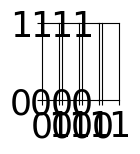

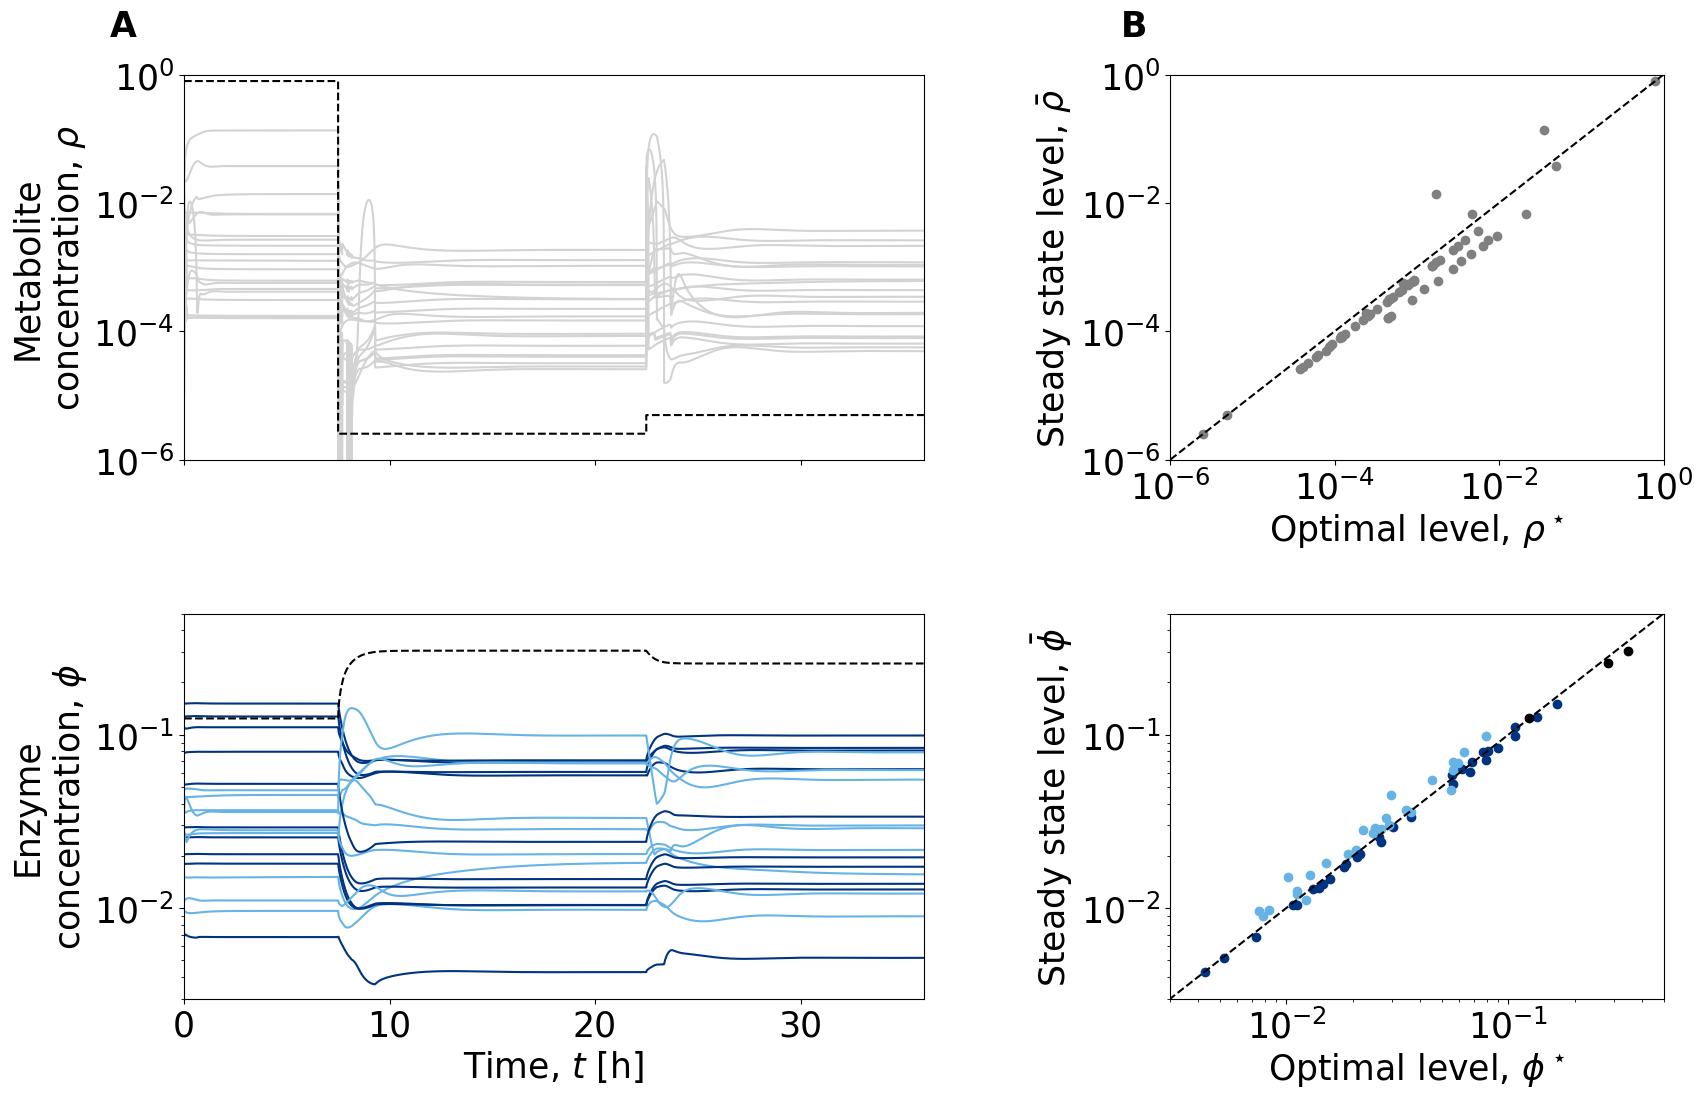

In [18]:
#Figure S5
times = np.array(times)
savephis = np.array(savephis)
saverhos = np.array(saverhos)
times2 = np.array(times2)
savephis2 = np.array(savephis2)
saverhos2 = np.array(saverhos2)
times3 = np.array(times3)
savephis3 = np.array(savephis3)
saverhos3 = np.array(saverhos3)

alltimes = np.concatenate((times, times2+times[-1], times3+times2[-1]+times[-1]))
allphis = np.concatenate((savephis, savephis2, savephis3))
allrhos = np.concatenate((saverhos, saverhos2, saverhos3))

lammax = 1/np.sum(1/kappas)
Qs = np.sqrt(kappas*KMs)
qis = Qs/(np.sum(Qs/kappas)*lammax)

RYG = plt.cm.get_cmap('RdYlGn')


font = {'size'   : 25}
plt.rc('font', **font)
dt = 3e-5
fig, axs = plt.subplots(1, 4, figsize = (1, 1))
fig = plt.figure(figsize = (35, 12))
gs = gridspec.GridSpec(12, 11)
gs.update(wspace=0, hspace=0)

axs[1] = plt.subplot(gs[:5, 5:8])
ax1 = plt.subplot(gs[7:, 5:8])
ax2 = plt.subplot(gs[7:, 9:])
axs[2] = plt.subplot(gs[:5, 9:])
#axs[2, 2] = plt.subplot(gs[7:10, 9:])
#axs[3, 0] = plt.subplot(gs[11:13, 1:6])
#axs[3, 1] = plt.subplot(gs[11:13, 7:])
#axs[4, 0] = plt.subplot(gs[14:17, 1:4])
#axs[4, 1] = plt.subplot(gs[14:17, 5:8])
#axs[4, 2] = plt.subplot(gs[14:17, 9:])
isample = 0
xs = np.linspace(0, 0.5, 100)

vmin = -5
vmax = 1

if False:
    axs[0] = plt.subplot(gs[:6, 2:4])
    ax0 = plt.subplot(gs[6:, 2:4])
    j = 1
    axs[0].annotate("", xy = (j+0.8, 1), xytext = (j+0.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
    axs[0].annotate("", xy = (j+1.8, 1), xytext = (j+1.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
    axs[0].annotate("", xy = (j+1.4, .5), xytext = (j+1.1, 0.8), arrowprops=dict(arrowstyle="-|>", color='grey'))
    
    axs[0].plot(j+1-xs, (1.4+j**2*8*np.sqrt(0.27**2-(xs-0.27)**2))*1.3, "k--", linewidth = 7)
    axs[0].add_patch(plt.Polygon([[j+.88, 1], [j+1, 1.3], [j+1.12, 1], [j+1, 1/1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=RYG((7-2.5*j)/(vmax-vmin))))
    axs[0].add_patch(plt.Polygon([[j+1-.16/j+.5-1, 2*1.3*j], [j+1-.16/j+.5-1, 2/1.3], [j+1+.16/j+.5-1, 2/1.3], [j+1+.16/j+.5-1, 2*1.3*j]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=RYG((5-2*j)/(vmax-vmin))))   
    axs[0].annotate("", xy = (j-1+1.6, 3.2), xytext = (j-1+1.4, 3.3), arrowprops=dict(arrowstyle="-", color='k', linewidth = 7))
    #axs[0].annotate(r"q>1", xy = (j+1.1, 5), xytext = (j+1.1, 5), arrowprops=dict(arrowstyle="-", color='white'))
    axs[0].text(1, 8, r"$q\gtrsim 1$, strong repression")
    
    
    axs[0].set_yscale("log")
    axs[0].set_xlim(1, 4)
    axs[0].set_ylim(0.2, 20)
    axs[0].axis("off")
    
    j = 2
    ax0.annotate("", xy = (j-1+0.8, 1), xytext = (j-1+0.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
    ax0.annotate("", xy = (j+.8, 1), xytext = (j+.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
    ax0.annotate("", xy = (j+.4, .5), xytext = (j+.1, 0.8), arrowprops=dict(arrowstyle="-|>", color='grey'))
    
    ax0.plot(j-xs, (1.4+j**2*8*np.sqrt(0.27**2-(xs-0.27)**2))*1.3, "k--", linewidth = 3)
    ax0.add_patch(plt.Polygon([[j-1+.88, 1], [j, 1.3], [j+.12, 1], [j, 1/1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=RYG((7-2.5*j)/(vmax-vmin))))
    ax0.add_patch(plt.Polygon([[j-.16/j+.5-1, 2*1.3*j], [j-.16/j+.5-1, 2/1.3], [j+.16/j+.5-1, 2/1.3], [j+.16/j+.5-1, 2*1.3*j]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=RYG((5-2*j)/(vmax-vmin))))   
    ax0.annotate("", xy = (j-1+.6, 3.3*2), xytext = (j-1+.4, 3.4*2), arrowprops=dict(arrowstyle="-", color='k', linewidth = 3))
    #ax0.annotate("", xy = (j-1+.495, 3*2), xytext = (j-1+.505, 3.5*2), arrowprops=dict(arrowstyle="-|>", color='k', linewidth = 4))
    #ax0.annotate(r"q<1", xy = (j+.1, 5*3), xytext = (j+.1, 5*3), arrowprops=dict(arrowstyle="-", color='white'))
    ax0.text(1, 25, r"$q\lesssim 1$, weak repression")
    
    ax0.set_yscale("log")
    ax0.set_xlim(1, 4)
    ax0.set_ylim(0.4, 40)
    ax0.axis("off")


xs = np.linspace(0, 0.5, 100)


for i in range(Nenzymes-1):
    ax1.plot(alltimes, allphis[:, i], color = basecolors[int(qis[i]>1), 0])#RYG(np.log(qis)[i]/4+1/2))
    axs[1].plot(alltimes, allrhos[:, i], color = "lightgrey")

i = Nenzymes-1
ax1.plot(alltimes, allphis[:, i], color = "k", linestyle = "--")
axs[1].plot(alltimes, allrhos[:, i], color = "k", linestyle = "--")

ax1.set_yscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("")
ax1.set_ylabel("Enzyme\n"+r"concentration, $\phi$")
axs[1].set_ylabel("Metabolite\n"+r"concentration, $\rho$")
ax1.set_ylim(3e-3, 5e-1)
axs[1].set_ylim(1e-6, 1e0)
ax1.set_xlabel("Time, $t$ [h]")
axs[1].set_xlim(0, 36)
ax1.set_xlim(0, 36)
axs[1].set_xticklabels([])

axs[2].scatter(richref[3], rhos, color = "grey")
axs[2].scatter(ref[3], rhos2, color = "grey")
axs[2].scatter(ref2[3], rhos3, color = "grey")
axs[2].plot([1e-6, 1], [1e-6, 1], "k--")
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlim(1e-6, 1)
axs[2].set_ylim(1e-6, 1)
axs[2].set_ylabel(r"Steady state level, $\bar \rho$")
axs[2].set_xlabel(r"Optimal level, $\rho^\star$")
#axs[3].set_xlabel("Optimal resource allocation")
#axs[3].set_ylabel("Regulatory steady state")

for i in range(Nenzymes-1):
    ax2.scatter(richref[4, i], phis[i], color = basecolors[int(qis[i]>1), 0])
    ax2.scatter(ref[4, i], phis2[i], color = basecolors[int(qis[i]>1), 0])
    ax2.scatter(ref2[4, i], phis3[i], color = basecolors[int(qis[i]>1), 0])
    
i = Nenzymes -1
ax2.scatter(richref[4, i], phis[i], color = "k")
ax2.scatter(ref[4, i], phis2[i], color = "k")
ax2.scatter(ref2[4, i], phis3[i], color = "k")

ax2.plot([1e-3, 1], [1e-3, 1], "k--")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlim(3e-3, 5e-1)
ax2.set_ylim(3e-3, 5e-1)
ax2.set_xlabel(r"Optimal level, $\phi^\star$")
ax2.set_ylabel(r"Steady state level, $\bar \phi$")
#ax2.yaxis.set_label_coords(-0.25, 1.25)

#fig.tight_layout()
for n, ax in enumerate([axs[1], axs[2]]): 
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/SIRegulation.pdf", bbox_inches="tight", format = 'pdf')